<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Fine_tune_gpt_3_5_Turbo_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU openai datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 132.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.5 MB/s eta 0:00:00


## Load Dataset

In [11]:
from datasets import load_dataset
#
ds = load_dataset("nomic-ai/gpt4all-j-prompt-generations",split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/808812 [00:00<?, ? examples/s]

In [12]:
ds

Dataset({
    features: ['prompt', 'response', 'source'],
    num_rows: 808812
})

##get a subset ofd 1000 rows for simplicity

In [13]:
ds_sample = ds.select(range(1000))
ds_sample

Dataset({
    features: ['prompt', 'response', 'source'],
    num_rows: 1000
})

In [14]:
ds_sample[1]

{'prompt': "<h2>Hi, How can I generate a pdf with the screen visual data, or generate a pdf of the data being generated by selecting a date?</h2>\n<p>I would like to generate a pdf with the data to be visualized when selecting, which in this case is the registration data. But I'm having a hard time. Sorry if my question is too stupid, but I'm a beginner.</p>\n<p><strong>My code:</strong></p>\n<pre><code>&quot;&quot;    // ignore: unused_import\n    import 'dart:math';\n    \n    import 'package:date_format/date_format.dart';\n    import 'package:flutter/cupertino.dart';\n    import 'package:flutter/material.dart';\n    // ignore: unused_import\n    import 'package:flutter_datetime_picker/flutter_datetime_picker.dart';\n    import 'package:font_awesome_flutter/font_awesome_flutter.dart';\n    // ignore: unused_import\n    import 'package:line_awesome_icons/line_awesome_icons.dart';\n    import 'package:solidarioweb/constants/meses.dart';\n    import 'package:solidarioweb/models/agendame

## Format the data for finetuning
for finetuning a consistent format is maintained for each pair of questions and answers across the entire training and testing datasets.

```
{
  message = [
    {"role":"system","content":"Sytem's Role"},
    {"role":"user","content":"User's Question"},
    {"role":"assistant","content":"Sytem's Response"}
  ]
}

```

## Function to format the data required by GPT-3.5-Turbo

In [15]:
import random
def format_data(data):

  formatted_data = []
  for message in data:
    msg = {"messages" :
          [
          {"role":"system",
            "content":"""You are the Yahoo platform user's assistant. Please reply users' answer using polite,clear and respectful language."""
          },
          {"role":"user",
          "content":message["prompt"]
          },
          {"role":"assistant",
          "content":message["response"]
          }
          ]
          }
    formatted_data.append(msg)
  random.shuffle(formatted_data)
  return formatted_data




In [16]:
formatted_data = format_data(ds_sample)
#
formatted_data[0]

{'messages': [{'role': 'system',
   'content': "You are the Yahoo platform user's assistant. Please reply users' answer using polite,clear and respectful language."},
  {'role': 'user',
   'content': "Summarize the following instructions: Contact emergency services. That way, even if you have to deliver the baby yourself, help will arrive soon if you experience complications. The dispatcher should also be able to either talk you through the delivery or connect you to someone who can.\n\n\nIf the mother has a doctor or midwife, call that person too. The medical professional can often stay on the phone and help guide you through the process.;\n, The first stage of labor is called the “latent” stage, where the body is getting ready to deliver by dilating the cervix. It can take a long time, especially if this is the woman's first child.The second, or “active” stage occurs when the cervix has completely dilated.Women may not experience as much pain or discomfort during this stage as later 

## Training and Validation Data

In [17]:
# 70% of the overall 500 observation
TRAIN_SIZE = 700

training_data = formatted_data[:TRAIN_SIZE]
validation_data = formatted_data[TRAIN_SIZE:]

print(f"Training Size: {len(training_data)}")
print(f"Validation Size: {len(validation_data)}")

Training Size: 700
Validation Size: 300


## Save the training and validation data

In [18]:
import json

def save_data(dictionary_data, file_name):

  with open(file_name, 'w') as outfile:
    for entry in dictionary_data:
      json.dump(entry, outfile)
      outfile.write('\n')

In [19]:
#
save_data(training_data, "training_data.jsonl")
save_data(validation_data, "validation_data.jsonl")

In [20]:
%%bash
ls

sample_data
training_data.jsonl
validation_data.jsonl


## Upload data to openai

In [25]:
import openai
from openai import FineTuningJob, ChatCompletion
from getpass import getpass
#
openai.api_key = getpass()

··········


## Training an validation data formatter function

In [22]:
def upload_fine_tuning_data(data_path):

  oploaded_file = openai.File.create(
    file=open(data_path, "rb"),
    purpose='fine-tune'
  )

  return oploaded_file

##Training Data ID

In [30]:
uploaded_training_data = upload_fine_tuning_data("training_data.jsonl")
uploaded_training_data

<File file id=file-qfEbp4Gh16nMQgb85ejS5dvY at 0x7aab240898f0> JSON: {
  "object": "file",
  "id": "file-qfEbp4Gh16nMQgb85ejS5dvY",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 12447994,
  "created_at": 1693061276,
  "status": "uploaded",
  "status_details": null
}

In [31]:
uploaded_training_id = uploaded_training_data["id"]
print(uploaded_training_id)

file-qfEbp4Gh16nMQgb85ejS5dvY


## Validation Data ID

In [32]:
uploaded_validation_data = upload_fine_tuning_data("validation_data.jsonl")
uploaded_validation_data

<File file id=file-0yisBLZ9fEyXPiuUM2VqL7WB at 0x7aab2c2c3fb0> JSON: {
  "object": "file",
  "id": "file-0yisBLZ9fEyXPiuUM2VqL7WB",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 5355095,
  "created_at": 1693061285,
  "status": "uploaded",
  "status_details": null
}

In [33]:
uploaded_validation_id = uploaded_validation_data["id"]
print(uploaded_validation_id)

file-0yisBLZ9fEyXPiuUM2VqL7WB


## Fine Tuning Helper function

In [35]:
def create_fine_tuning(model_name, train_id, val_id):

  fine_tuning_response = FineTuningJob.create(
      training_file=train_id,
      #validation_file=val_id,
      model=model_name
  )

  return fine_tuning_response

## Initiate fine-tuning

In [36]:
#
model_name = "gpt-3.5-turbo"
#
fine_tuning_response = create_fine_tuning(model_name,
                                          uploaded_training_id,
                                          uploaded_validation_id)
#
print(fine_tuning_response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-DDgbZCd3Kzgfz1VbaxYO7rlI",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693061533,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-h5B0ahlHzJHWTVOx8vC442tb",
  "result_files": [],
  "status": "created",
  "validation_file": null,
  "training_file": "file-qfEbp4Gh16nMQgb85ejS5dvY",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null
}


## Get the finetuning jobid

In [37]:
fine_tuning_job_ID = fine_tuning_response['id']
#
print(fine_tuning_job_ID)

ftjob-DDgbZCd3Kzgfz1VbaxYO7rlI


## Track the Finetuning job

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gV0Azldl3zIkYBn5IZavw4dn",
      "created_at": 1693061534,
      "level": "info",
      "message": "Fine tuning job started",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gV0Azldl3zIkYBn5IZavw4dn",
      "created_at": 1693061534,
      "level": "info",
      "message": "Fine tuning job started",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gV0Azldl3zIkYBn5IZavw4dn",
      "created_at": 1693061534,
      "level": "info",
      "message": "Fine tuning job started",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "

<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


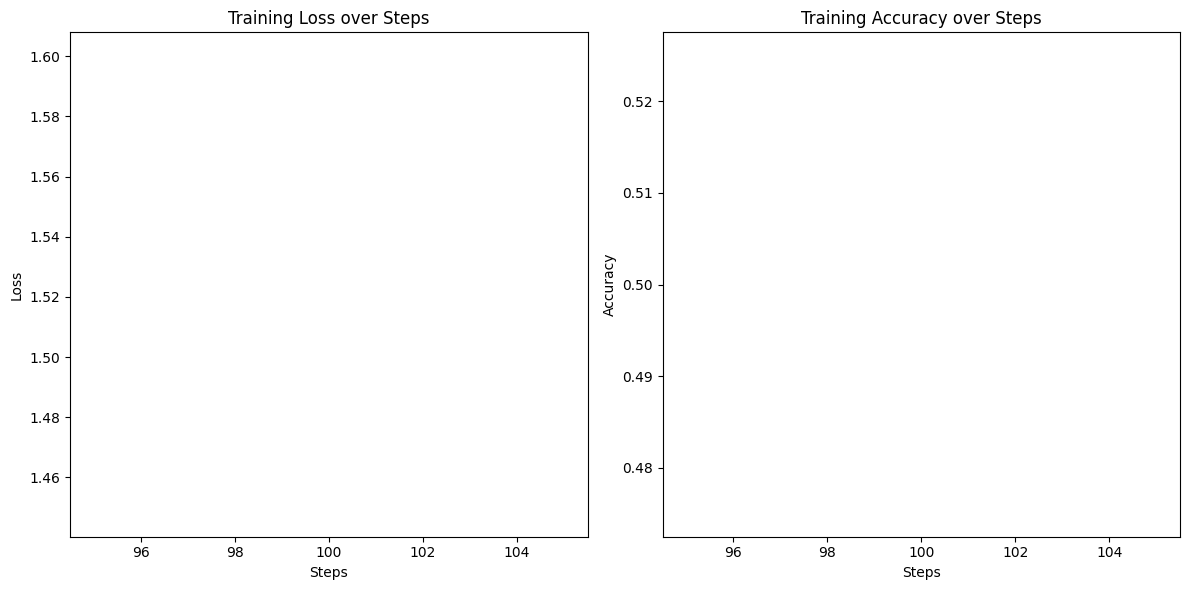

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-PMOKR1F9NsRaxuhzJ8pOGIzf",
      "created_at": 1693061939,
      "level": "info",
      "message": "Step 100/2100: training loss=1.52",
      "data": {
        "step": 100,
        "train_loss": 1.524132251739502,
        "train_mean_token_accuracy": 0.5
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 100 | Loss: 1.524132251739502 | Accuracy: 0.5


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

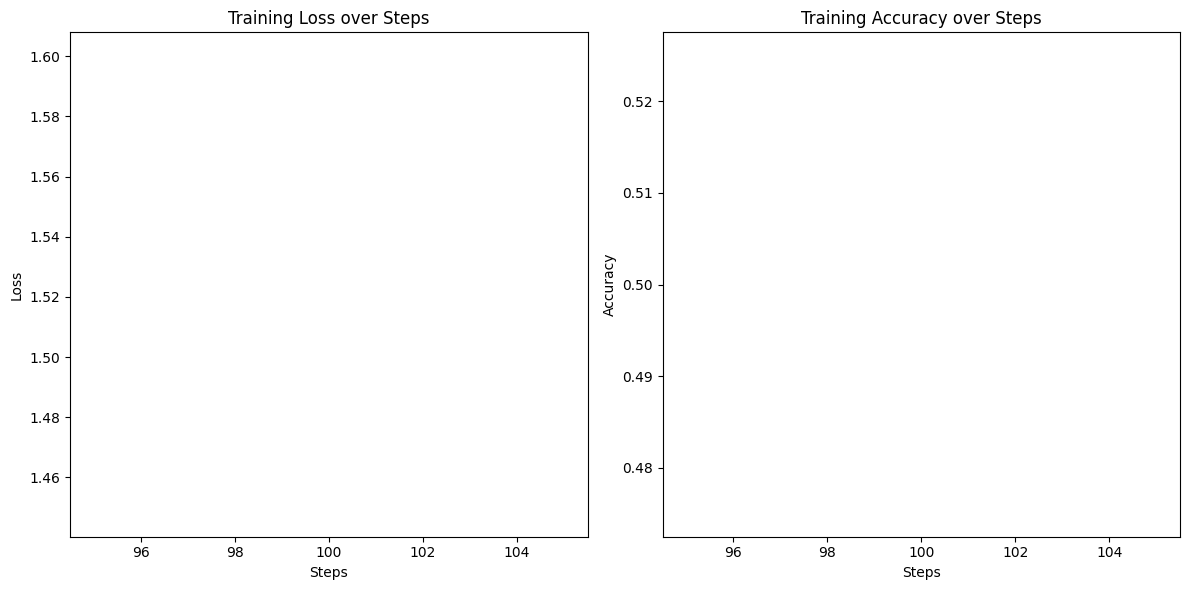

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-PMOKR1F9NsRaxuhzJ8pOGIzf",
      "created_at": 1693061939,
      "level": "info",
      "message": "Step 100/2100: training loss=1.52",
      "data": {
        "step": 100,
        "train_loss": 1.524132251739502,
        "train_mean_token_accuracy": 0.5
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 100 | Loss: 1.524132251739502 | Accuracy: 0.5


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

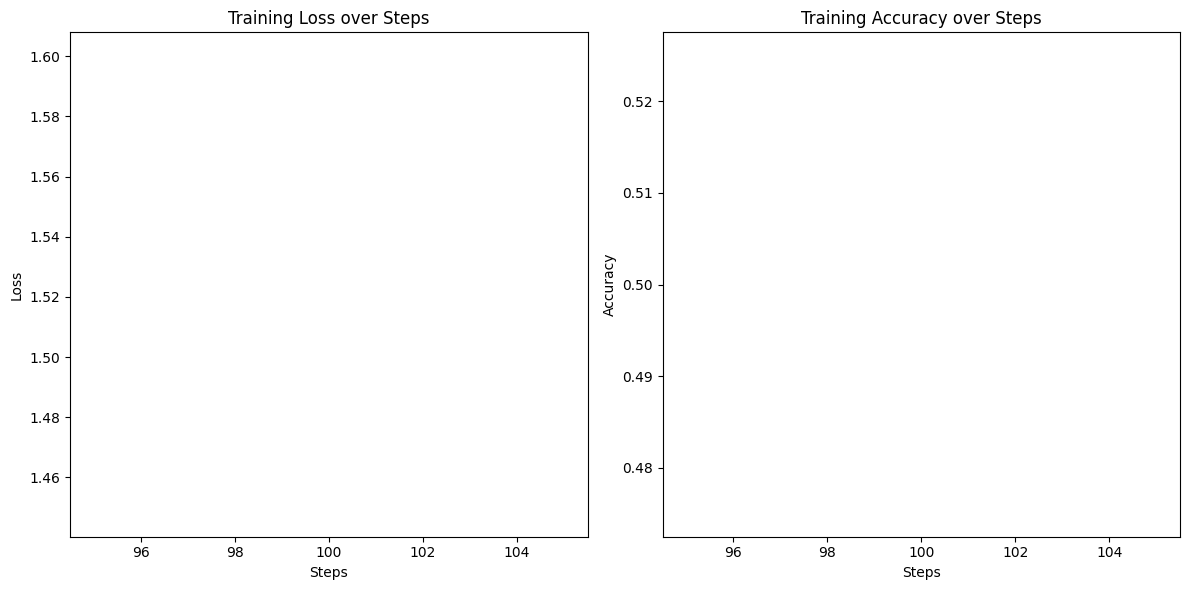

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-PMOKR1F9NsRaxuhzJ8pOGIzf",
      "created_at": 1693061939,
      "level": "info",
      "message": "Step 100/2100: training loss=1.52",
      "data": {
        "step": 100,
        "train_loss": 1.524132251739502,
        "train_mean_token_accuracy": 0.5
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 100 | Loss: 1.524132251739502 | Accuracy: 0.5


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

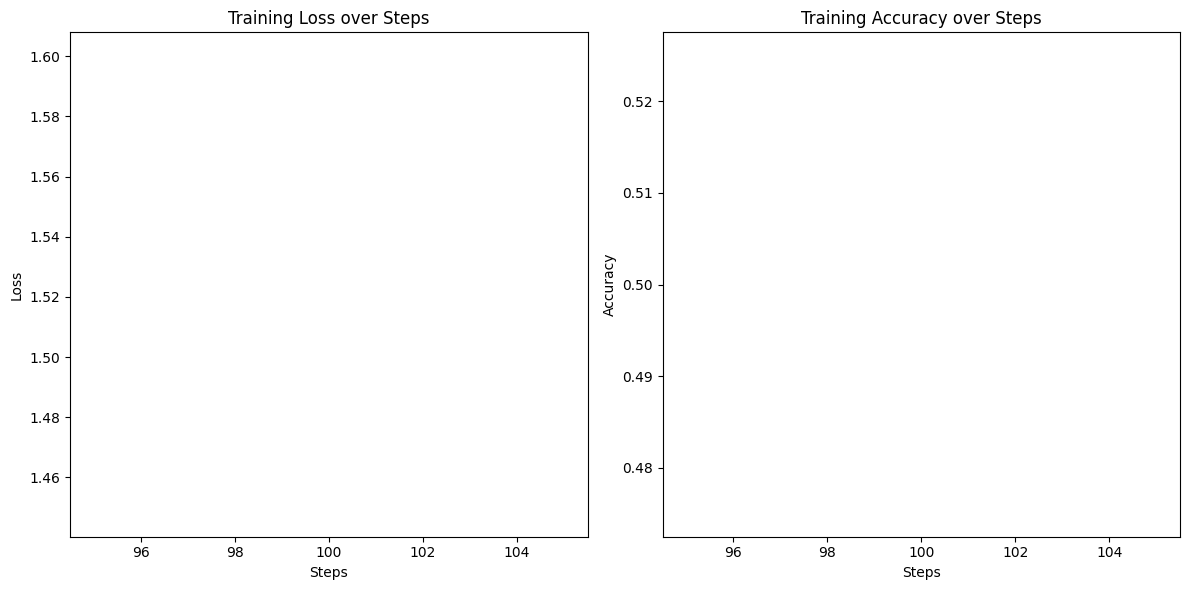

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-lnAzoGDGnqepk5ppFEtTFZkG",
      "created_at": 1693062058,
      "level": "info",
      "message": "Step 200/2100: training loss=0.69",
      "data": {
        "step": 200,
        "train_loss": 0.6903777718544006,
        "train_mean_token_accuracy": 0.7878788113594055
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 200 | Loss: 0.6903777718544006 | Accuracy: 0.7878788113594055


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

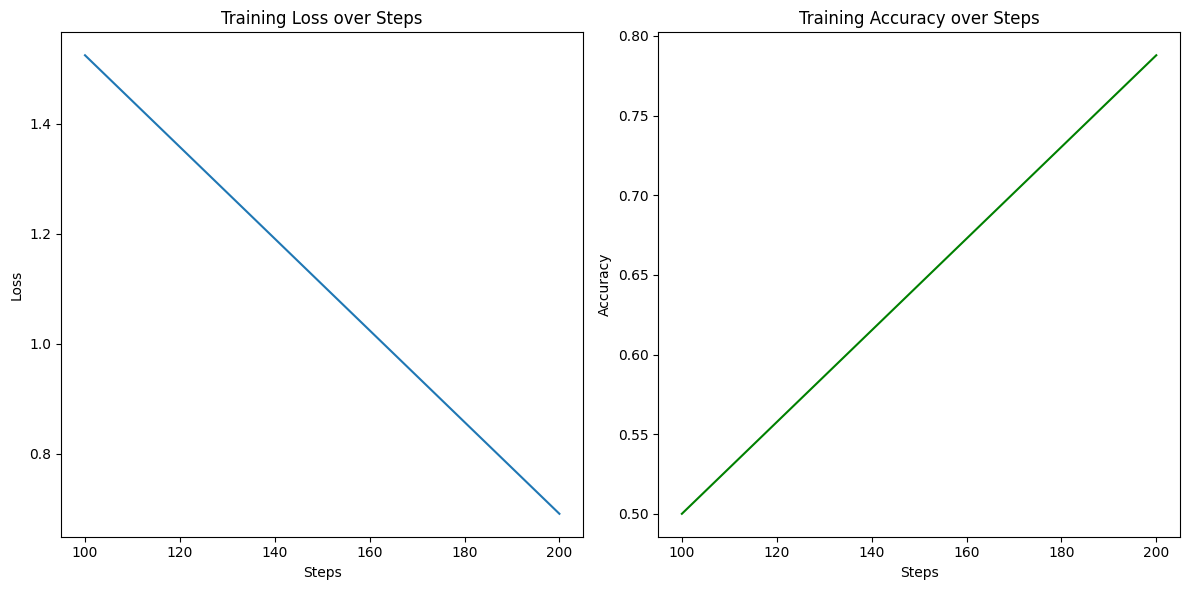

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-lnAzoGDGnqepk5ppFEtTFZkG",
      "created_at": 1693062058,
      "level": "info",
      "message": "Step 200/2100: training loss=0.69",
      "data": {
        "step": 200,
        "train_loss": 0.6903777718544006,
        "train_mean_token_accuracy": 0.7878788113594055
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 200 | Loss: 0.6903777718544006 | Accuracy: 0.7878788113594055


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

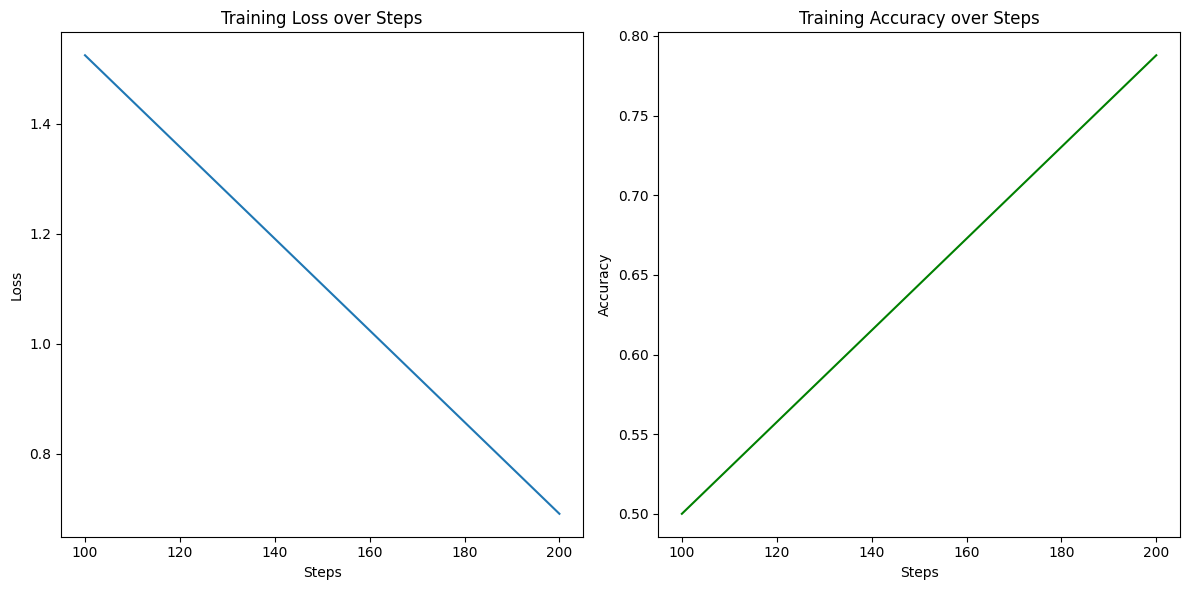

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-lnAzoGDGnqepk5ppFEtTFZkG",
      "created_at": 1693062058,
      "level": "info",
      "message": "Step 200/2100: training loss=0.69",
      "data": {
        "step": 200,
        "train_loss": 0.6903777718544006,
        "train_mean_token_accuracy": 0.7878788113594055
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 200 | Loss: 0.6903777718544006 | Accuracy: 0.7878788113594055


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

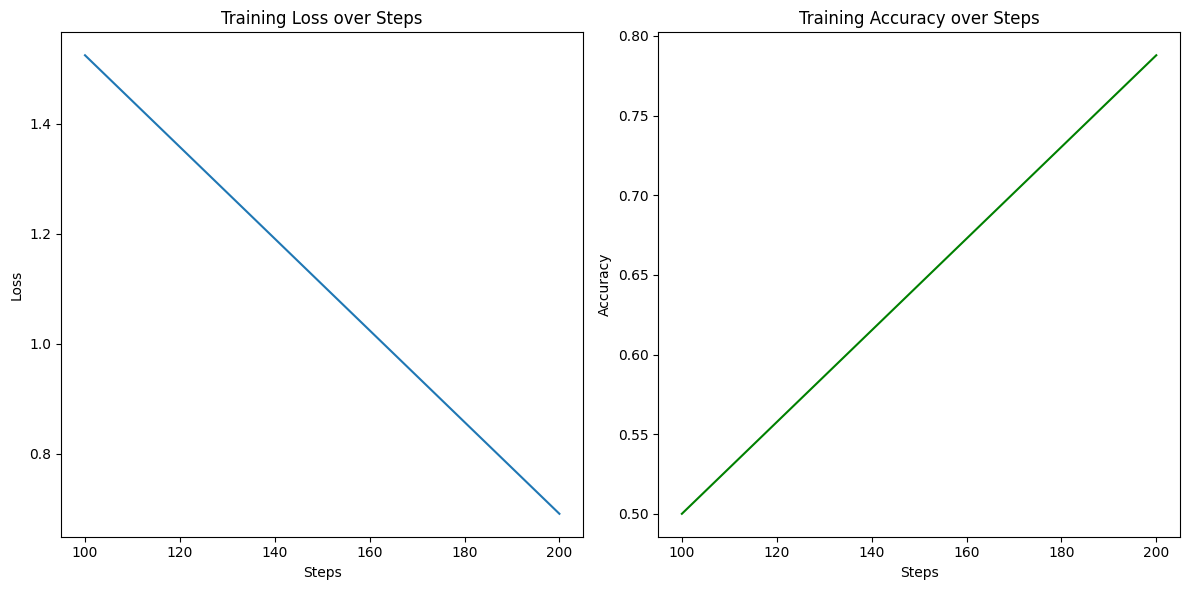

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-lnAzoGDGnqepk5ppFEtTFZkG",
      "created_at": 1693062058,
      "level": "info",
      "message": "Step 200/2100: training loss=0.69",
      "data": {
        "step": 200,
        "train_loss": 0.6903777718544006,
        "train_mean_token_accuracy": 0.7878788113594055
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 200 | Loss: 0.6903777718544006 | Accuracy: 0.7878788113594055


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

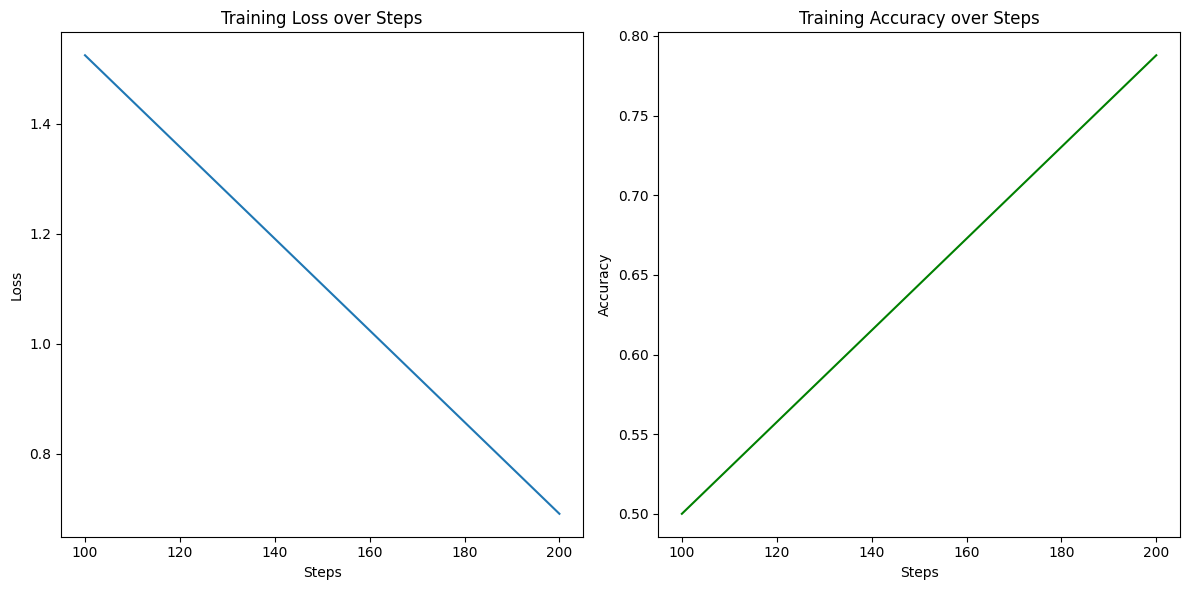

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-pTwQfyXl6K89J9ThdaN5gqhC",
      "created_at": 1693062179,
      "level": "info",
      "message": "Step 300/2100: training loss=0.86",
      "data": {
        "step": 300,
        "train_loss": 0.8557578921318054,
        "train_mean_token_accuracy": 0.7346938848495483
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 300 | Loss: 0.8557578921318054 | Accuracy: 0.7346938848495483


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

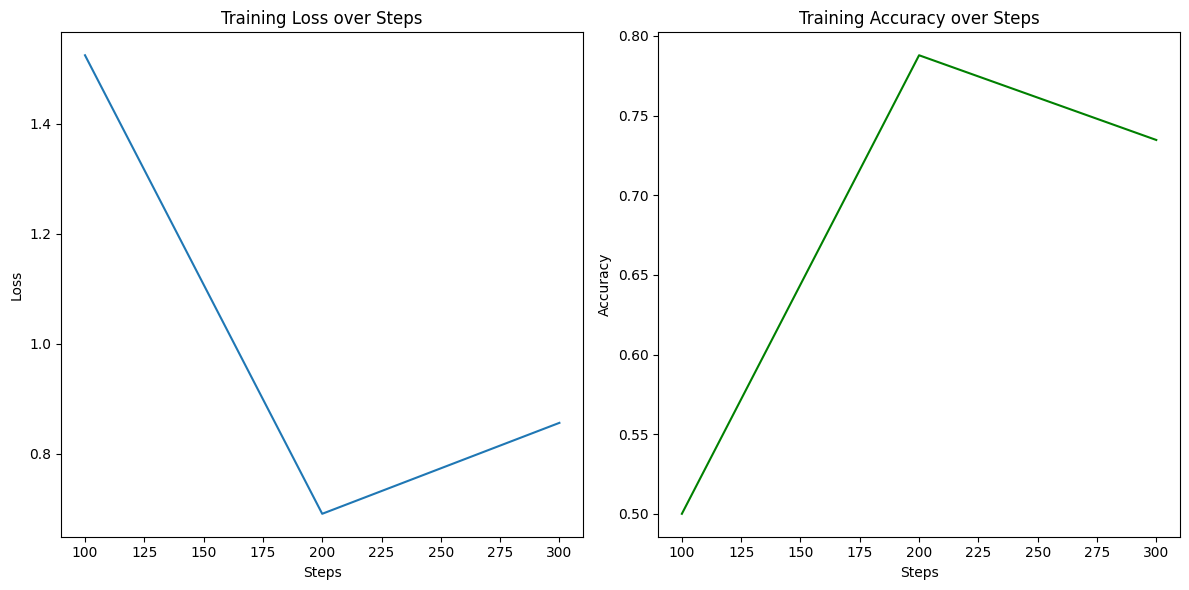

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-pTwQfyXl6K89J9ThdaN5gqhC",
      "created_at": 1693062179,
      "level": "info",
      "message": "Step 300/2100: training loss=0.86",
      "data": {
        "step": 300,
        "train_loss": 0.8557578921318054,
        "train_mean_token_accuracy": 0.7346938848495483
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 300 | Loss: 0.8557578921318054 | Accuracy: 0.7346938848495483


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

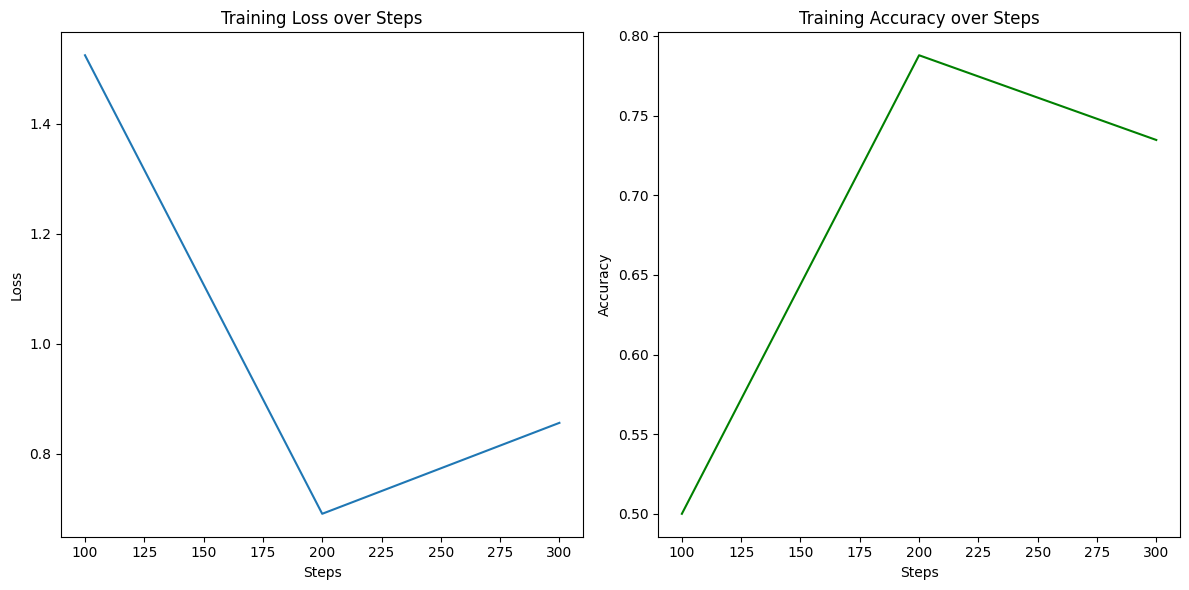

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-pTwQfyXl6K89J9ThdaN5gqhC",
      "created_at": 1693062179,
      "level": "info",
      "message": "Step 300/2100: training loss=0.86",
      "data": {
        "step": 300,
        "train_loss": 0.8557578921318054,
        "train_mean_token_accuracy": 0.7346938848495483
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 300 | Loss: 0.8557578921318054 | Accuracy: 0.7346938848495483


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

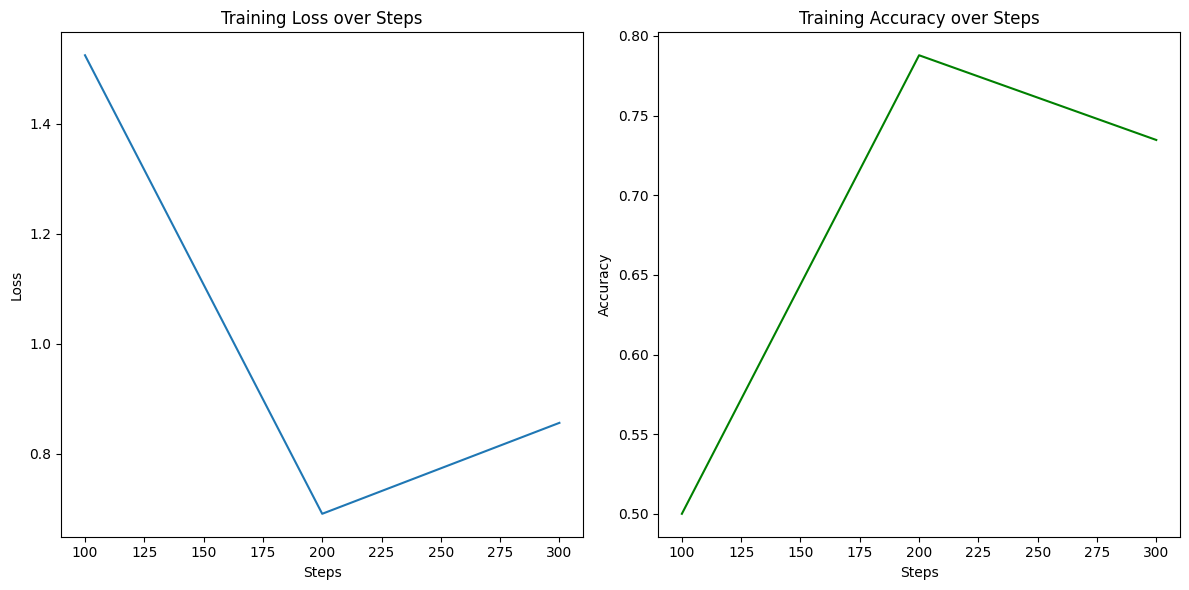

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-pTwQfyXl6K89J9ThdaN5gqhC",
      "created_at": 1693062179,
      "level": "info",
      "message": "Step 300/2100: training loss=0.86",
      "data": {
        "step": 300,
        "train_loss": 0.8557578921318054,
        "train_mean_token_accuracy": 0.7346938848495483
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 300 | Loss: 0.8557578921318054 | Accuracy: 0.7346938848495483


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

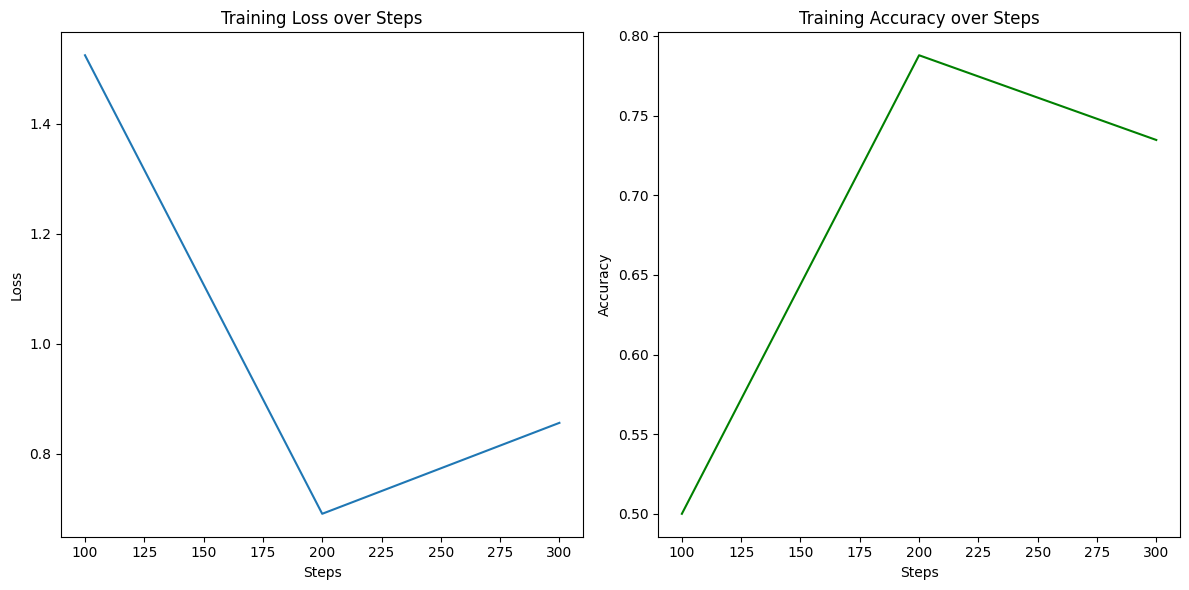

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-vaD9YFWdTgZXEhyO8xA5RbXy",
      "created_at": 1693062300,
      "level": "info",
      "message": "Step 400/2100: training loss=0.59",
      "data": {
        "step": 400,
        "train_loss": 0.5927334427833557,
        "train_mean_token_accuracy": 0.7867133021354675
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 400 | Loss: 0.5927334427833557 | Accuracy: 0.7867133021354675


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

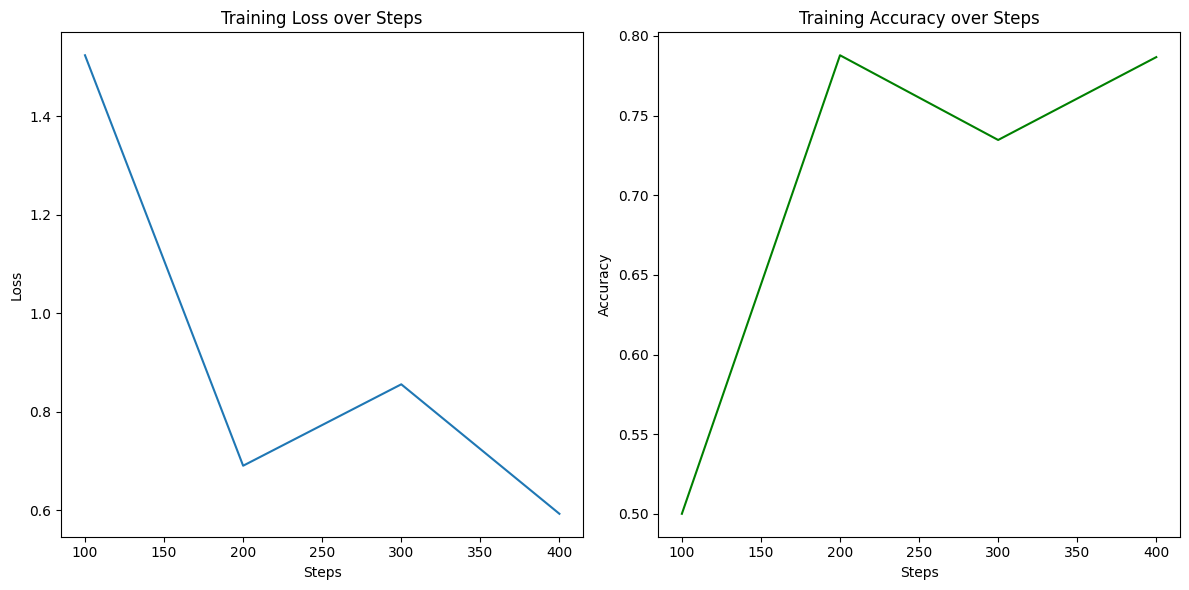

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-vaD9YFWdTgZXEhyO8xA5RbXy",
      "created_at": 1693062300,
      "level": "info",
      "message": "Step 400/2100: training loss=0.59",
      "data": {
        "step": 400,
        "train_loss": 0.5927334427833557,
        "train_mean_token_accuracy": 0.7867133021354675
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 400 | Loss: 0.5927334427833557 | Accuracy: 0.7867133021354675


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

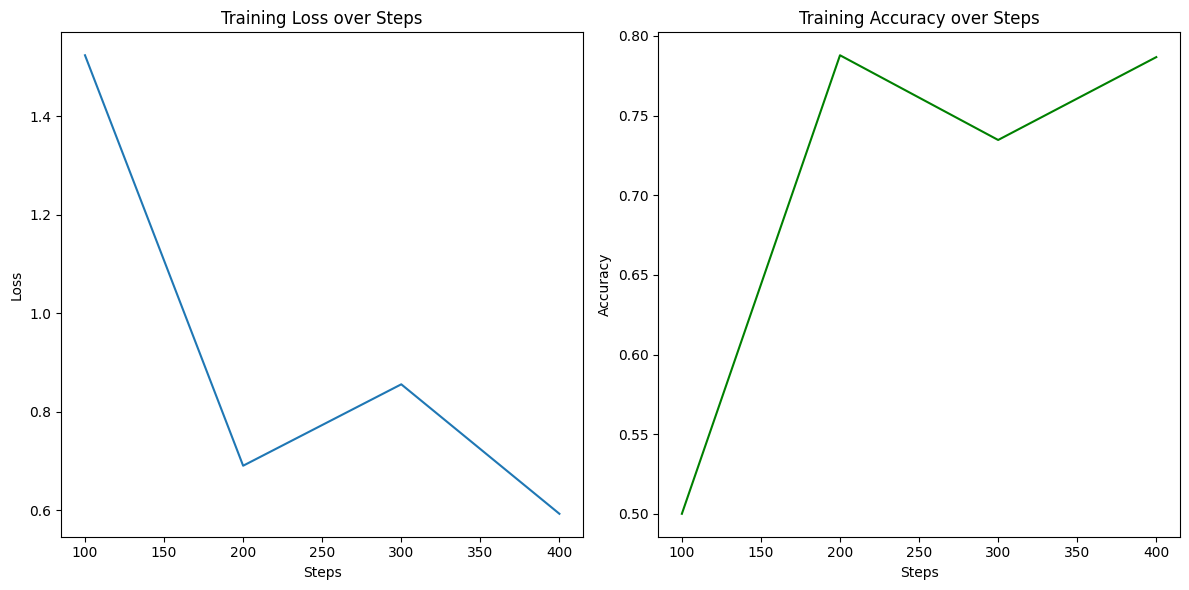

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-vaD9YFWdTgZXEhyO8xA5RbXy",
      "created_at": 1693062300,
      "level": "info",
      "message": "Step 400/2100: training loss=0.59",
      "data": {
        "step": 400,
        "train_loss": 0.5927334427833557,
        "train_mean_token_accuracy": 0.7867133021354675
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 400 | Loss: 0.5927334427833557 | Accuracy: 0.7867133021354675


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

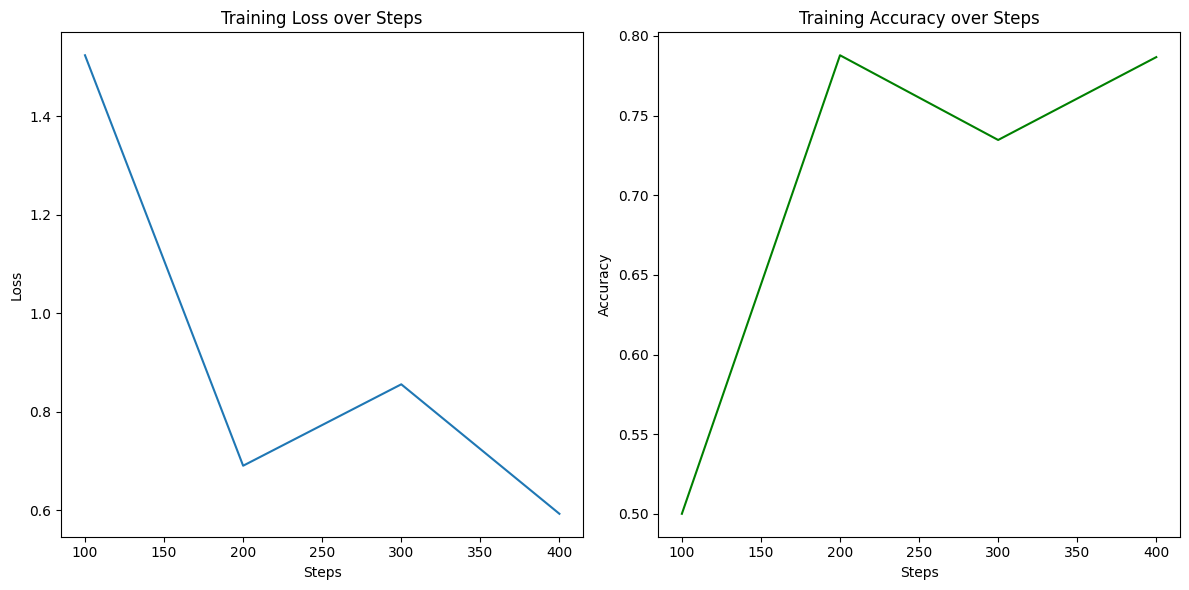

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-vaD9YFWdTgZXEhyO8xA5RbXy",
      "created_at": 1693062300,
      "level": "info",
      "message": "Step 400/2100: training loss=0.59",
      "data": {
        "step": 400,
        "train_loss": 0.5927334427833557,
        "train_mean_token_accuracy": 0.7867133021354675
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 400 | Loss: 0.5927334427833557 | Accuracy: 0.7867133021354675


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

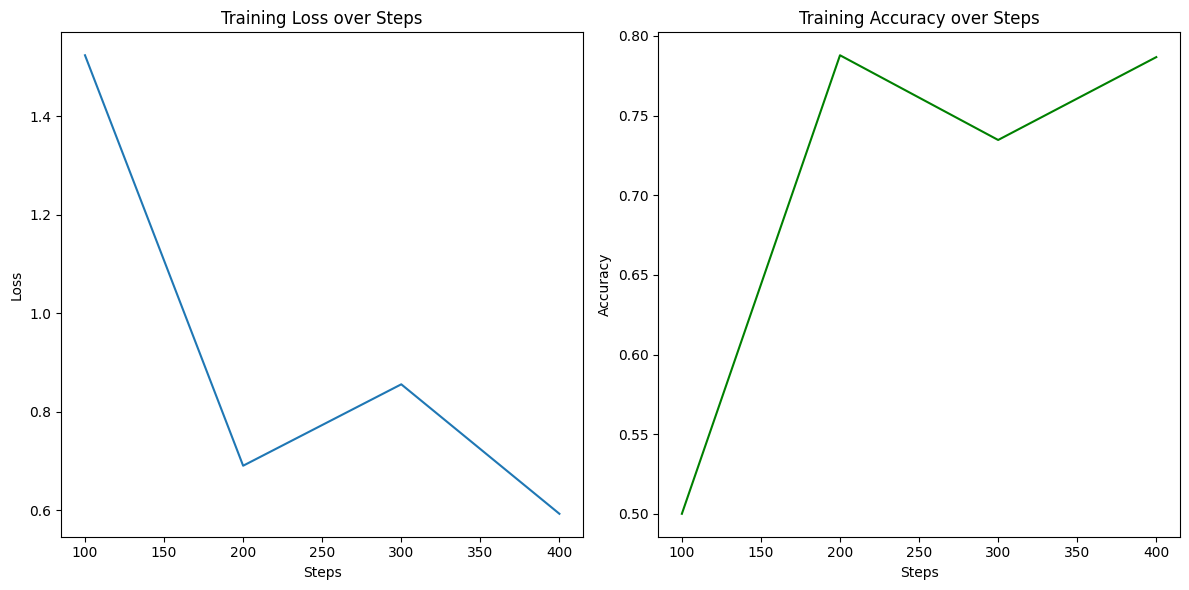

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-eXU3mDigZZIC2I9y2Cseu5UD",
      "created_at": 1693062421,
      "level": "info",
      "message": "Step 500/2100: training loss=0.70",
      "data": {
        "step": 500,
        "train_loss": 0.7030047178268433,
        "train_mean_token_accuracy": 0.770629346370697
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 500 | Loss: 0.7030047178268433 | Accuracy: 0.770629346370697


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

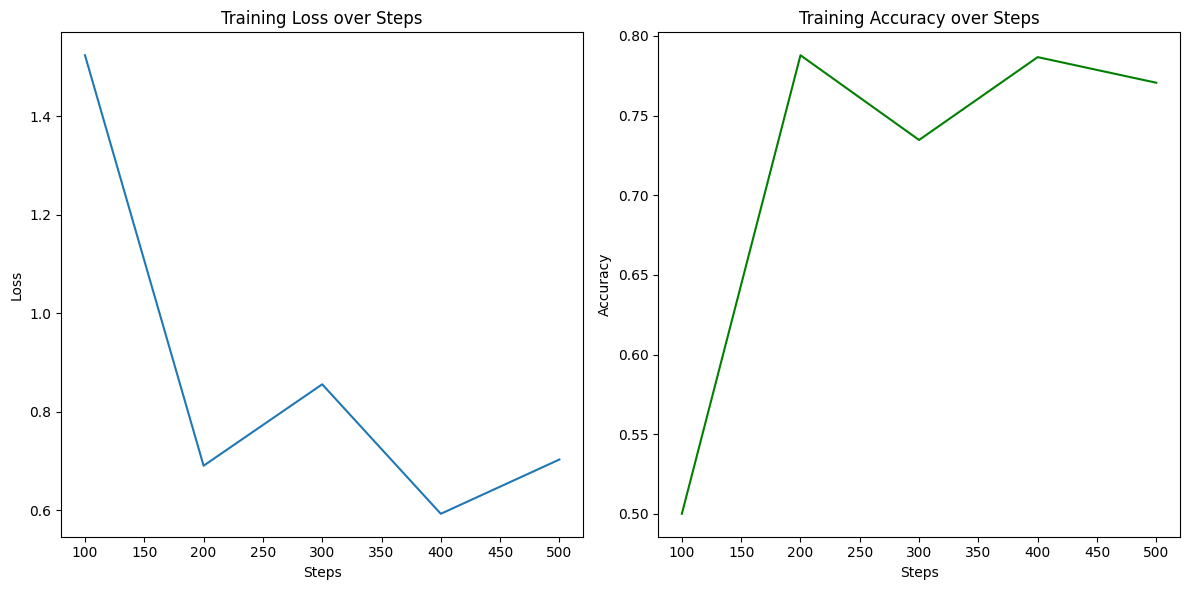

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-eXU3mDigZZIC2I9y2Cseu5UD",
      "created_at": 1693062421,
      "level": "info",
      "message": "Step 500/2100: training loss=0.70",
      "data": {
        "step": 500,
        "train_loss": 0.7030047178268433,
        "train_mean_token_accuracy": 0.770629346370697
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 500 | Loss: 0.7030047178268433 | Accuracy: 0.770629346370697


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

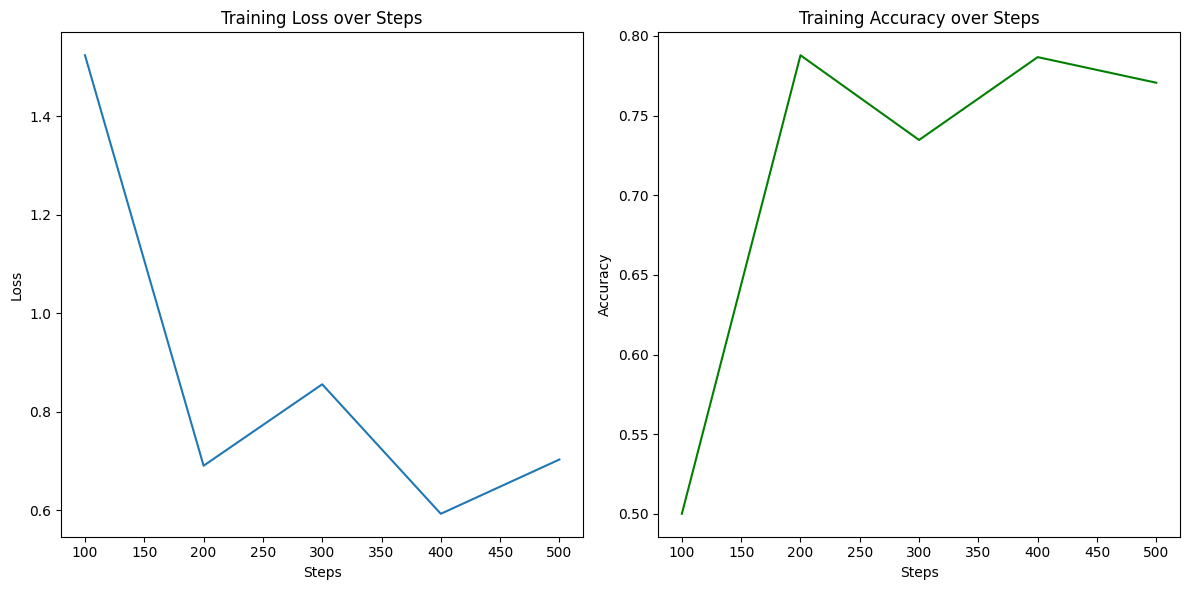

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-eXU3mDigZZIC2I9y2Cseu5UD",
      "created_at": 1693062421,
      "level": "info",
      "message": "Step 500/2100: training loss=0.70",
      "data": {
        "step": 500,
        "train_loss": 0.7030047178268433,
        "train_mean_token_accuracy": 0.770629346370697
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 500 | Loss: 0.7030047178268433 | Accuracy: 0.770629346370697


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

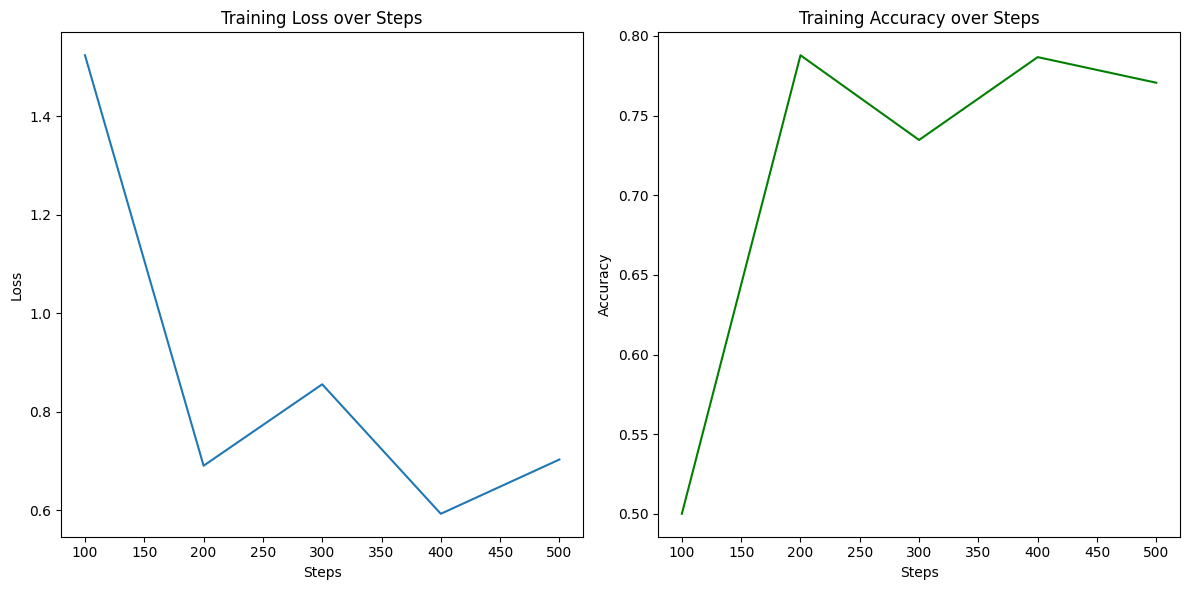

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-eXU3mDigZZIC2I9y2Cseu5UD",
      "created_at": 1693062421,
      "level": "info",
      "message": "Step 500/2100: training loss=0.70",
      "data": {
        "step": 500,
        "train_loss": 0.7030047178268433,
        "train_mean_token_accuracy": 0.770629346370697
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 500 | Loss: 0.7030047178268433 | Accuracy: 0.770629346370697


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

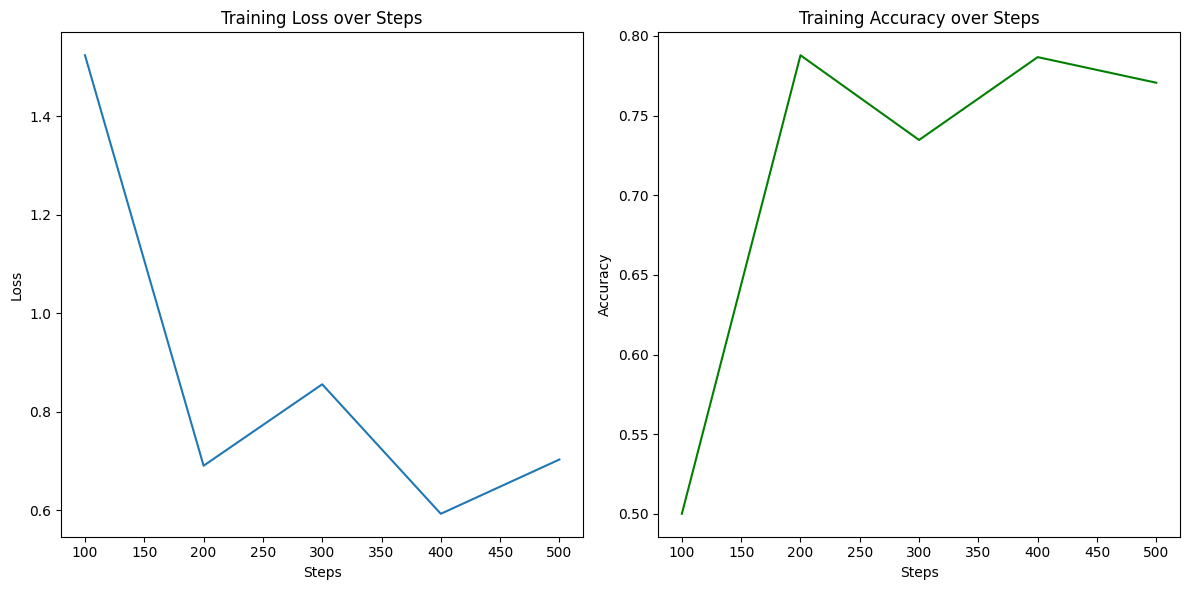

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ylJNIYiOTg11Lm2CbDzIudsj",
      "created_at": 1693062546,
      "level": "info",
      "message": "Step 600/2100: training loss=0.26",
      "data": {
        "step": 600,
        "train_loss": 0.2632487416267395,
        "train_mean_token_accuracy": 0.8986486196517944
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 600 | Loss: 0.2632487416267395 | Accuracy: 0.8986486196517944


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

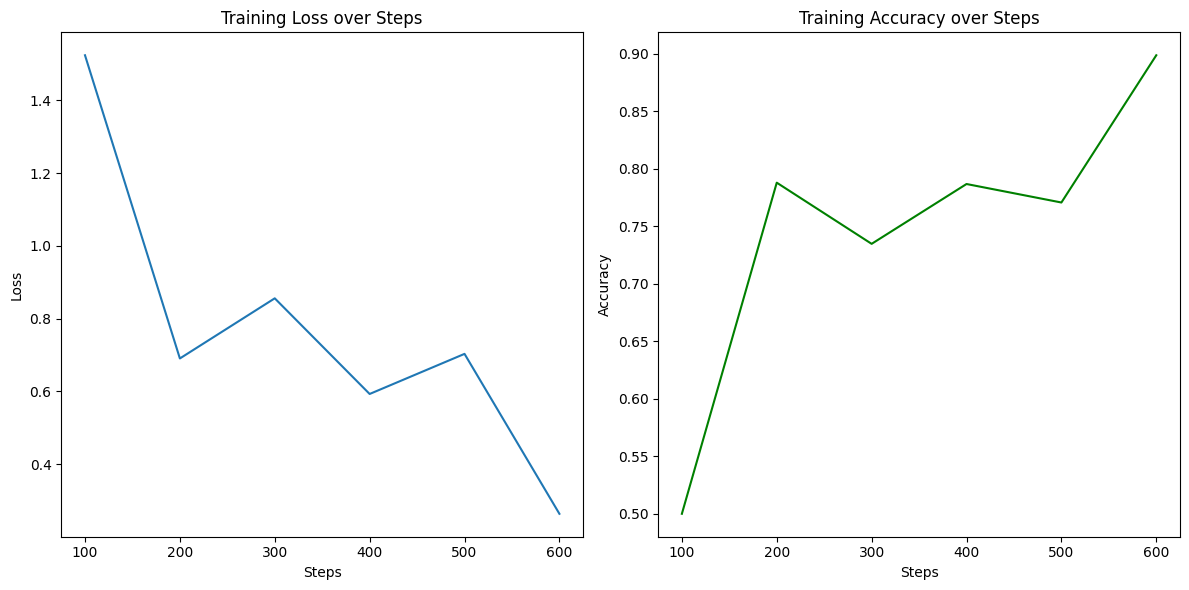

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ylJNIYiOTg11Lm2CbDzIudsj",
      "created_at": 1693062546,
      "level": "info",
      "message": "Step 600/2100: training loss=0.26",
      "data": {
        "step": 600,
        "train_loss": 0.2632487416267395,
        "train_mean_token_accuracy": 0.8986486196517944
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 600 | Loss: 0.2632487416267395 | Accuracy: 0.8986486196517944


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

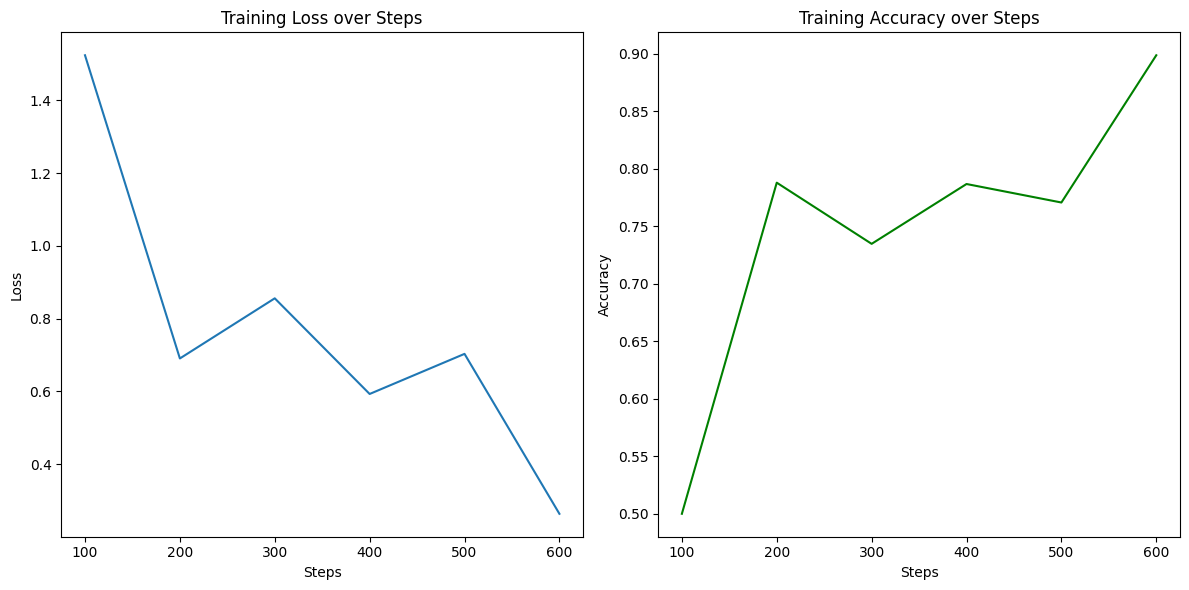

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ylJNIYiOTg11Lm2CbDzIudsj",
      "created_at": 1693062546,
      "level": "info",
      "message": "Step 600/2100: training loss=0.26",
      "data": {
        "step": 600,
        "train_loss": 0.2632487416267395,
        "train_mean_token_accuracy": 0.8986486196517944
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 600 | Loss: 0.2632487416267395 | Accuracy: 0.8986486196517944


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

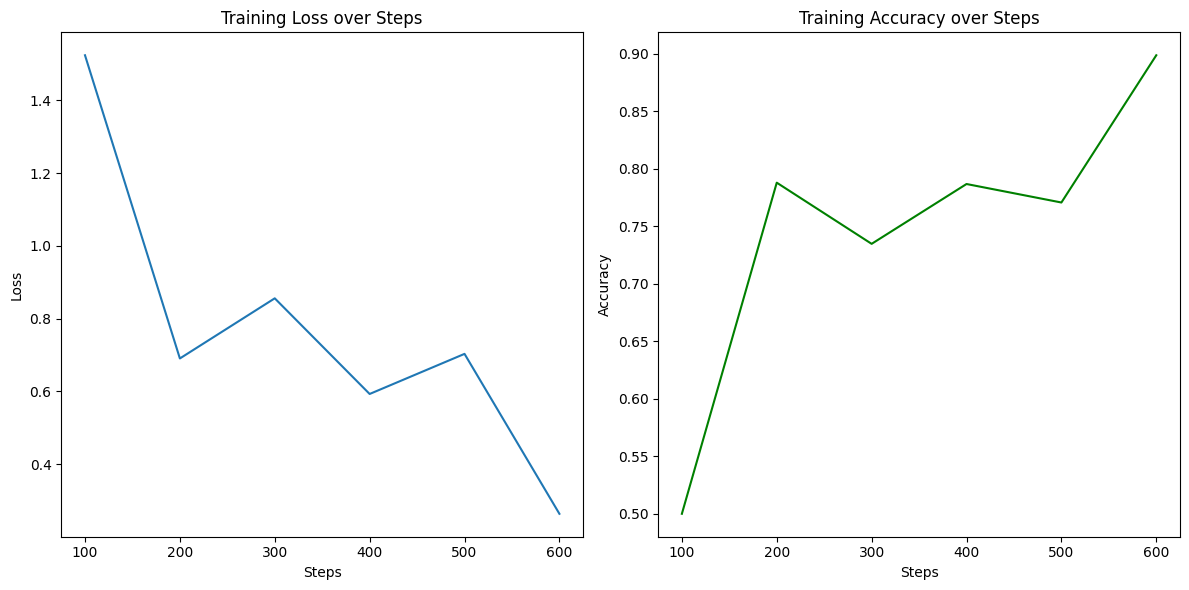

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gff9w06XaI0gws0fJxq0WNgc",
      "created_at": 1693062667,
      "level": "info",
      "message": "Step 700/2100: training loss=2.07",
      "data": {
        "step": 700,
        "train_loss": 2.0678586959838867,
        "train_mean_token_accuracy": 0.49514561891555786
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 700 | Loss: 2.0678586959838867 | Accuracy: 0.49514561891555786


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

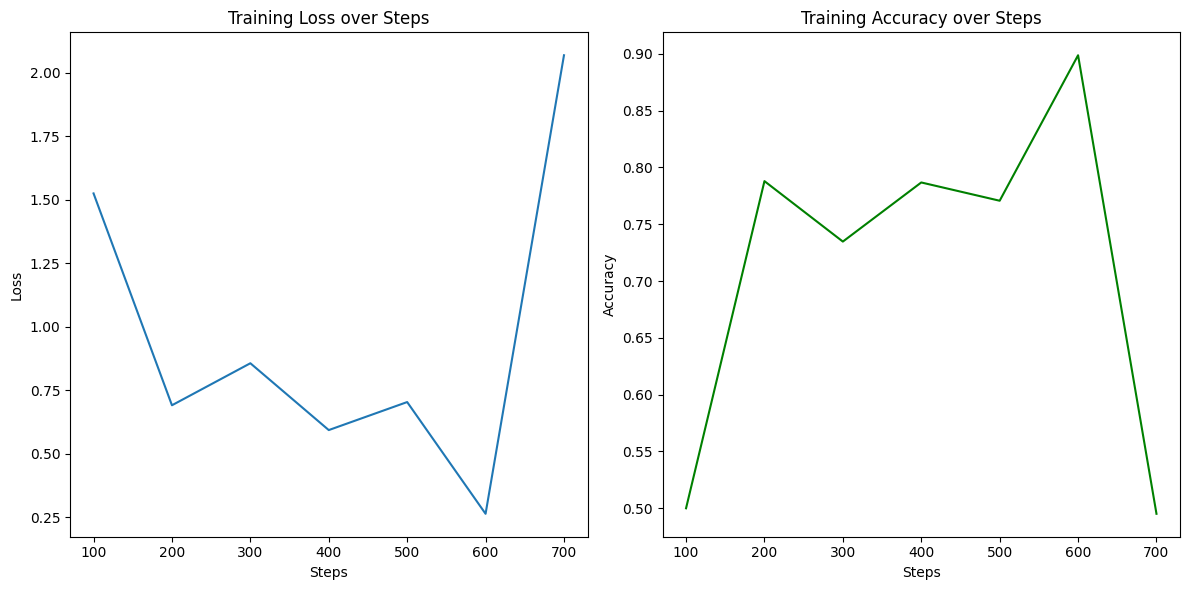

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gff9w06XaI0gws0fJxq0WNgc",
      "created_at": 1693062667,
      "level": "info",
      "message": "Step 700/2100: training loss=2.07",
      "data": {
        "step": 700,
        "train_loss": 2.0678586959838867,
        "train_mean_token_accuracy": 0.49514561891555786
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 700 | Loss: 2.0678586959838867 | Accuracy: 0.49514561891555786


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

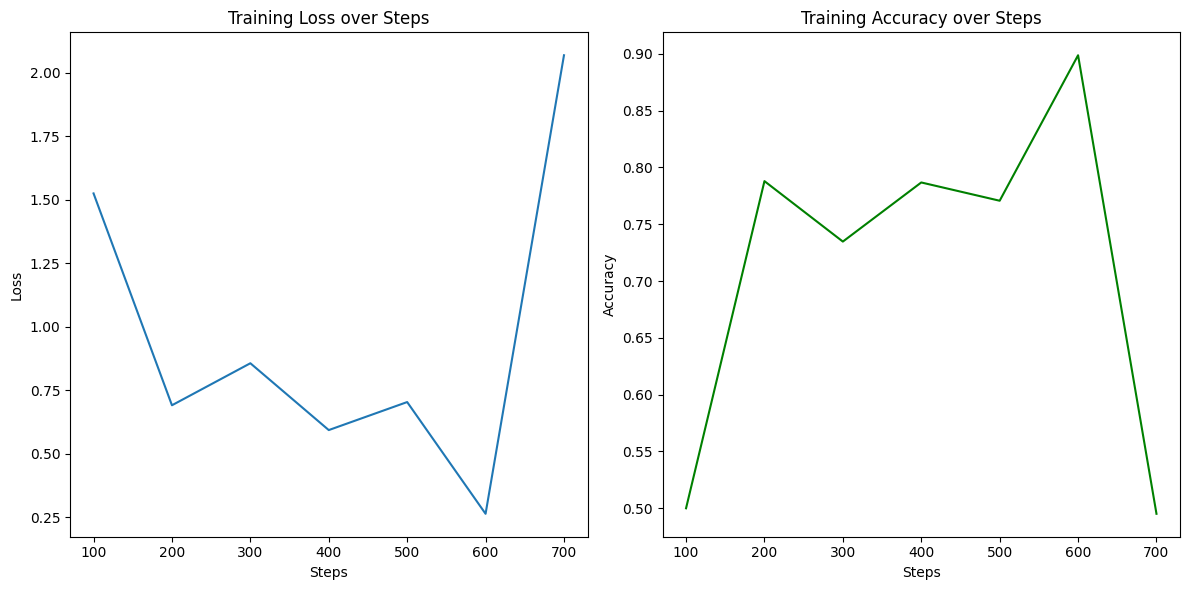

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gff9w06XaI0gws0fJxq0WNgc",
      "created_at": 1693062667,
      "level": "info",
      "message": "Step 700/2100: training loss=2.07",
      "data": {
        "step": 700,
        "train_loss": 2.0678586959838867,
        "train_mean_token_accuracy": 0.49514561891555786
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 700 | Loss: 2.0678586959838867 | Accuracy: 0.49514561891555786


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

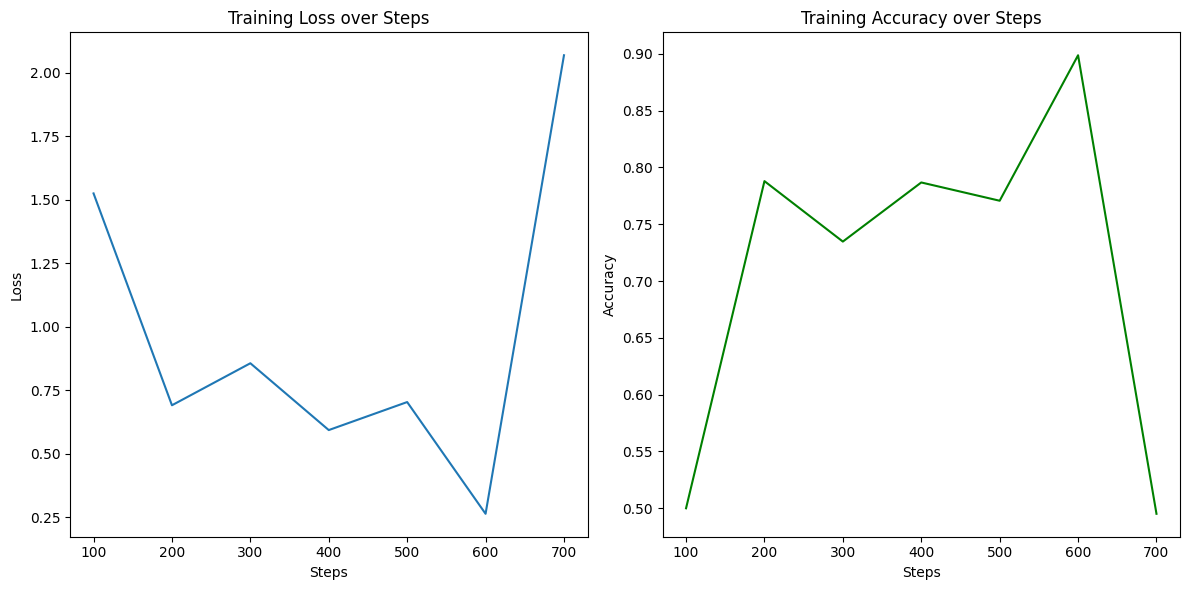

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-gff9w06XaI0gws0fJxq0WNgc",
      "created_at": 1693062667,
      "level": "info",
      "message": "Step 700/2100: training loss=2.07",
      "data": {
        "step": 700,
        "train_loss": 2.0678586959838867,
        "train_mean_token_accuracy": 0.49514561891555786
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 700 | Loss: 2.0678586959838867 | Accuracy: 0.49514561891555786


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

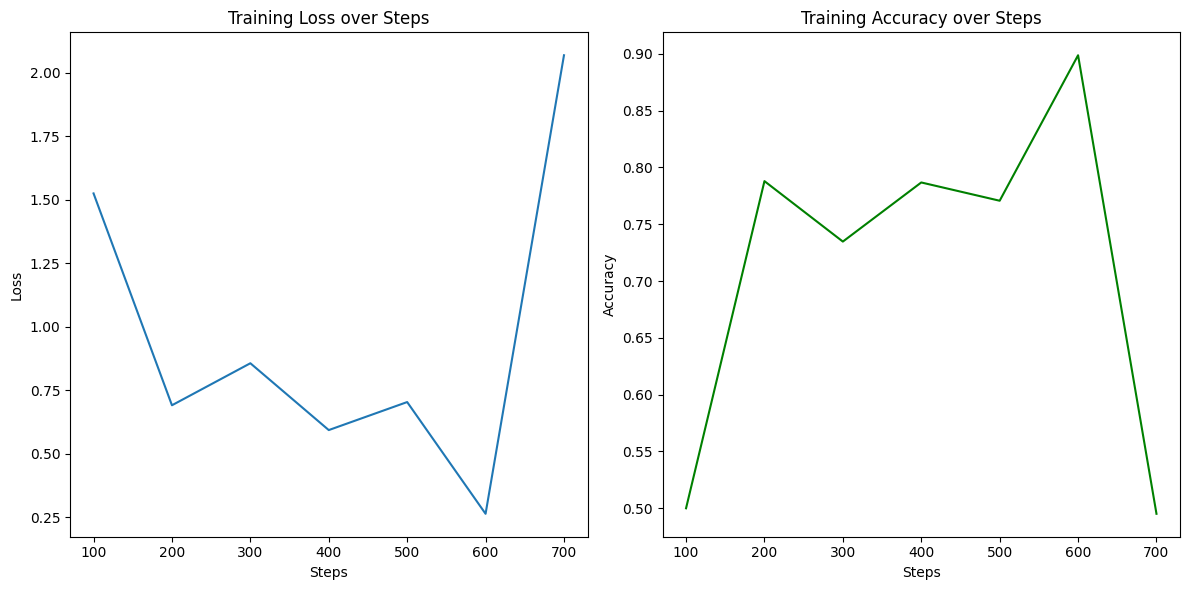

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-YFiEGOB5PWhZEp25QnhU5tLm",
      "created_at": 1693062788,
      "level": "info",
      "message": "Step 800/2100: training loss=0.00",
      "data": {
        "step": 800,
        "train_loss": 3.93382906622719e-05,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 800 | Loss: 3.93382906622719e-05 | Accuracy: 1.0


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

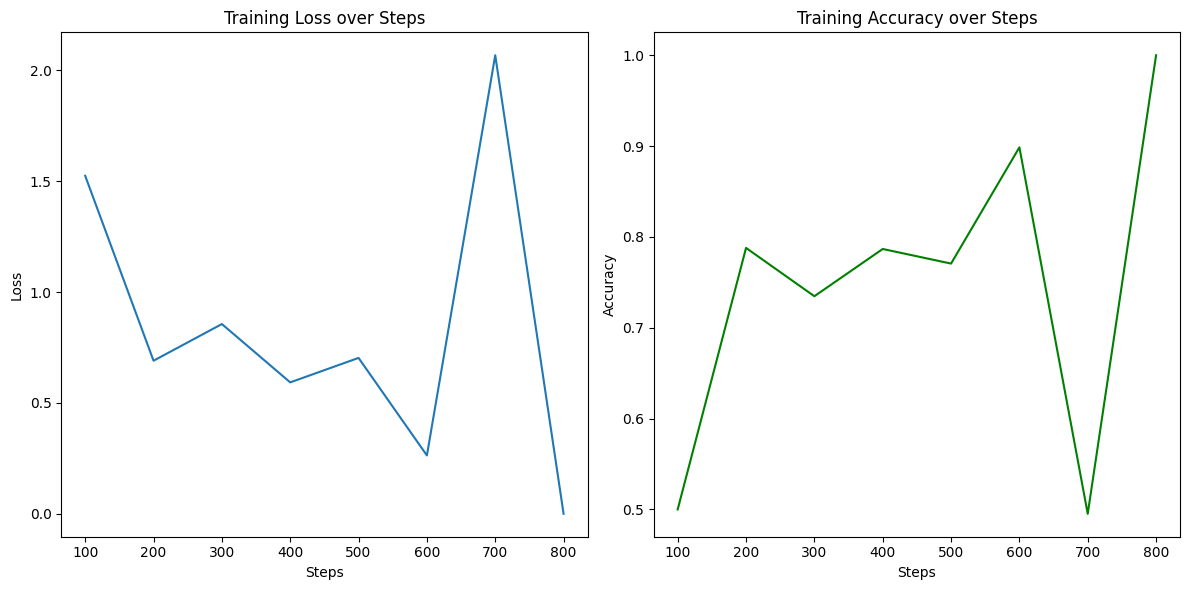

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-YFiEGOB5PWhZEp25QnhU5tLm",
      "created_at": 1693062788,
      "level": "info",
      "message": "Step 800/2100: training loss=0.00",
      "data": {
        "step": 800,
        "train_loss": 3.93382906622719e-05,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 800 | Loss: 3.93382906622719e-05 | Accuracy: 1.0


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

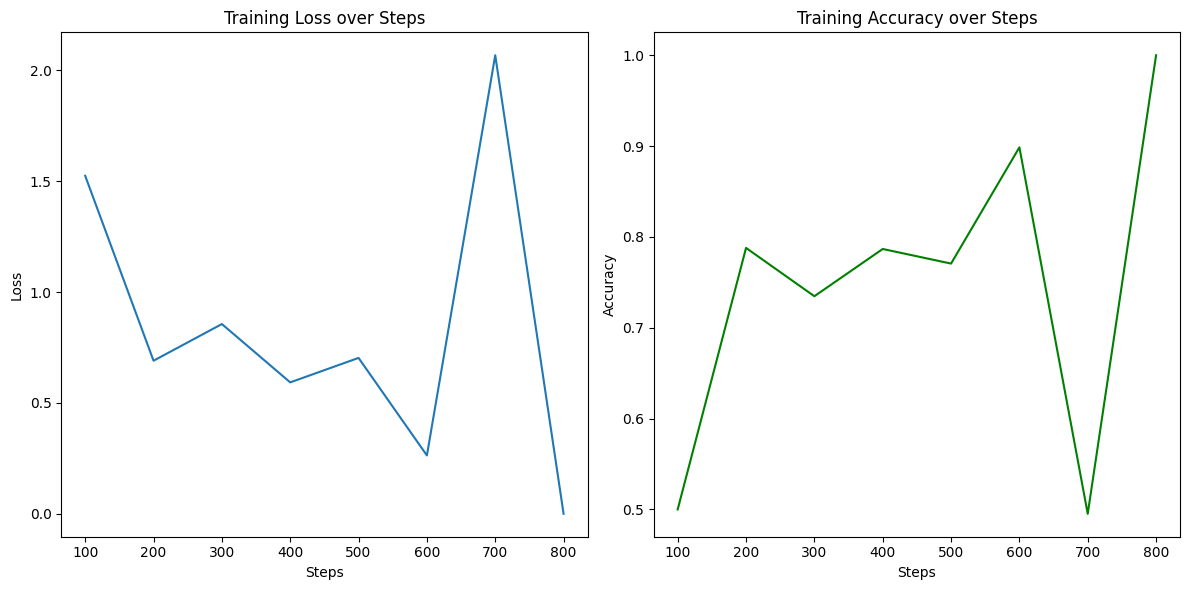

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-YFiEGOB5PWhZEp25QnhU5tLm",
      "created_at": 1693062788,
      "level": "info",
      "message": "Step 800/2100: training loss=0.00",
      "data": {
        "step": 800,
        "train_loss": 3.93382906622719e-05,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 800 | Loss: 3.93382906622719e-05 | Accuracy: 1.0


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

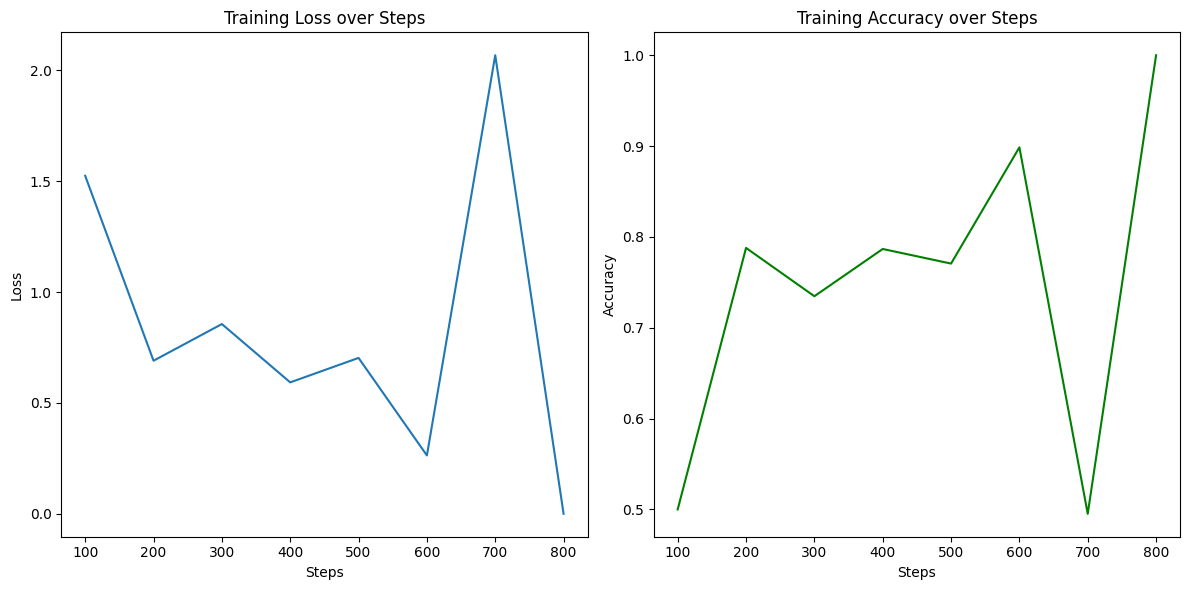

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-YFiEGOB5PWhZEp25QnhU5tLm",
      "created_at": 1693062788,
      "level": "info",
      "message": "Step 800/2100: training loss=0.00",
      "data": {
        "step": 800,
        "train_loss": 3.93382906622719e-05,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 800 | Loss: 3.93382906622719e-05 | Accuracy: 1.0


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

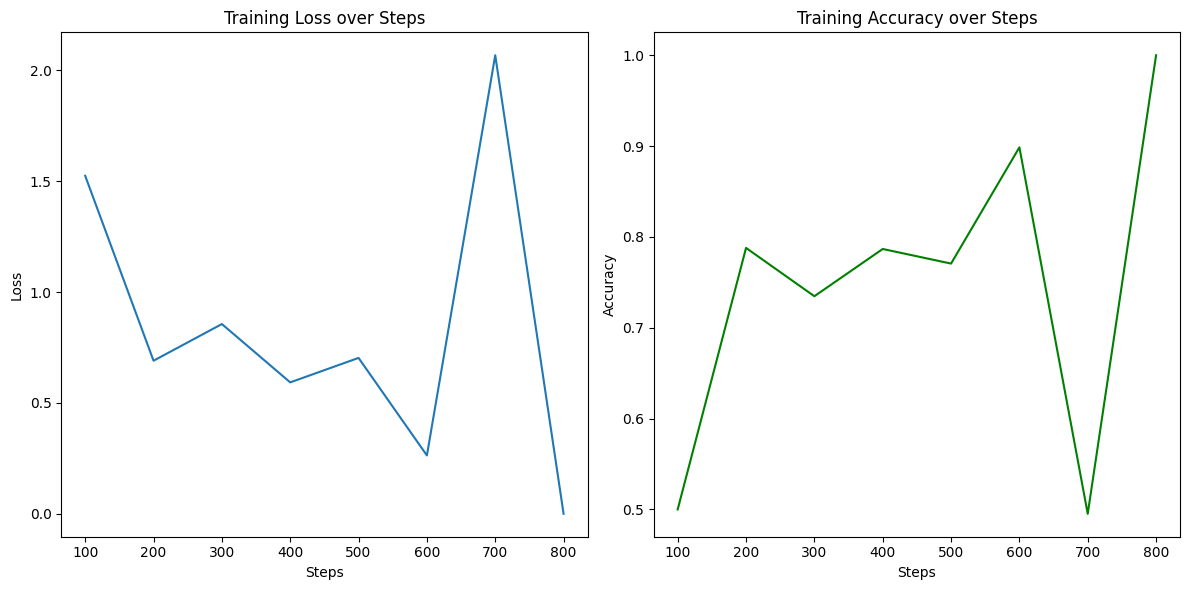

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ehbx8qLAxRzs5An0SrCDWas2",
      "created_at": 1693062909,
      "level": "info",
      "message": "Step 900/2100: training loss=0.92",
      "data": {
        "step": 900,
        "train_loss": 0.919586718082428,
        "train_mean_token_accuracy": 0.6967930197715759
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 900 | Loss: 0.919586718082428 | Accuracy: 0.6967930197715759


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

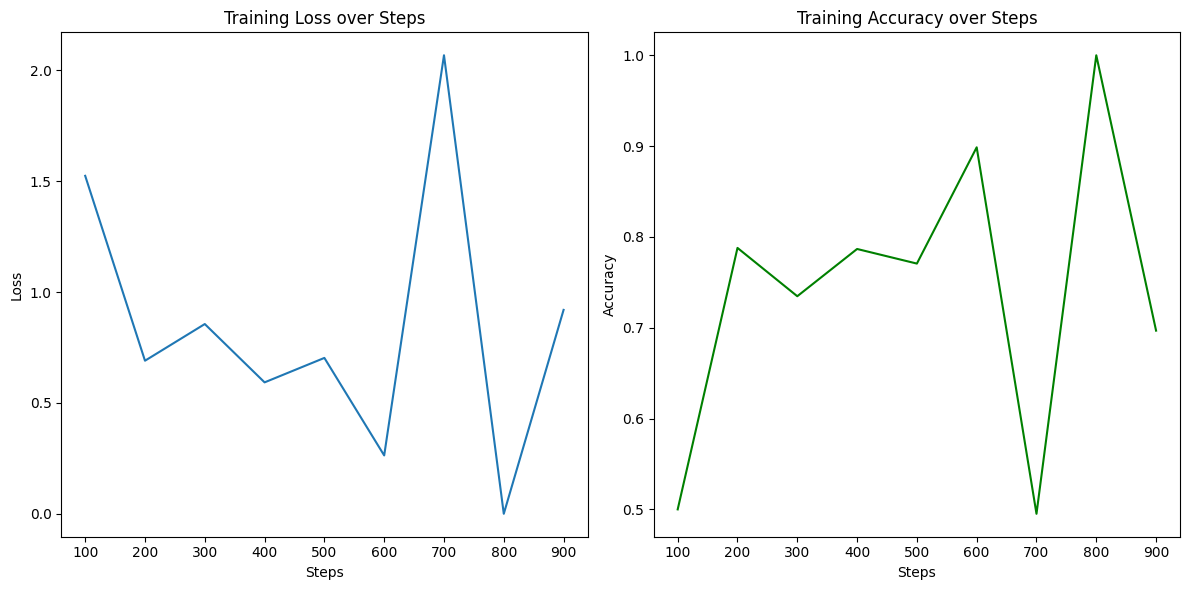

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ehbx8qLAxRzs5An0SrCDWas2",
      "created_at": 1693062909,
      "level": "info",
      "message": "Step 900/2100: training loss=0.92",
      "data": {
        "step": 900,
        "train_loss": 0.919586718082428,
        "train_mean_token_accuracy": 0.6967930197715759
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 900 | Loss: 0.919586718082428 | Accuracy: 0.6967930197715759


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

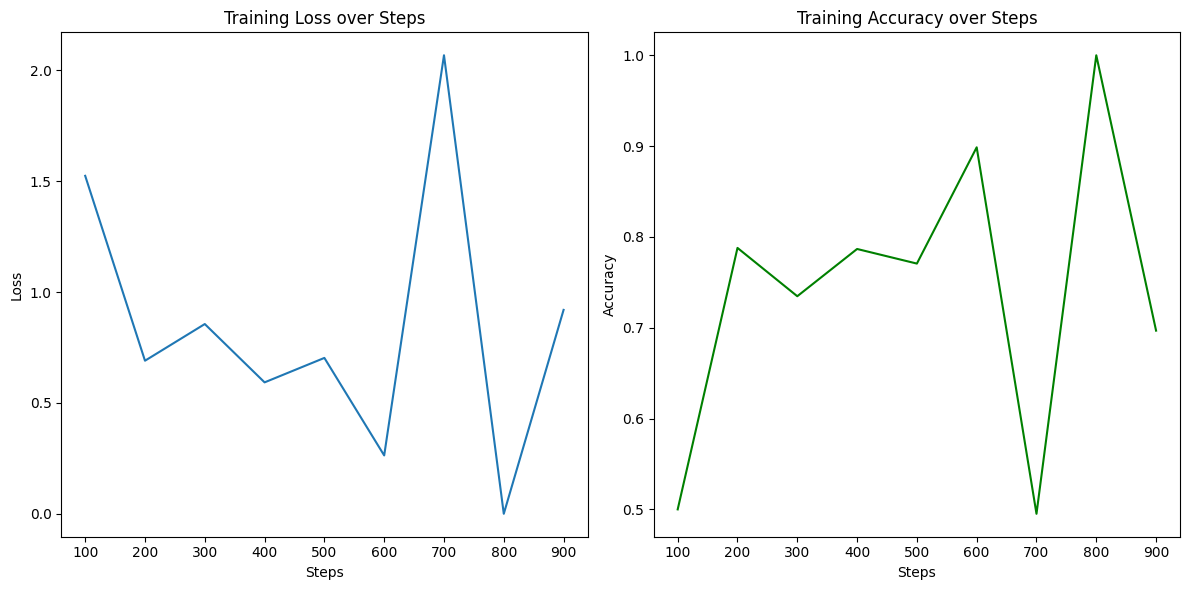

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ehbx8qLAxRzs5An0SrCDWas2",
      "created_at": 1693062909,
      "level": "info",
      "message": "Step 900/2100: training loss=0.92",
      "data": {
        "step": 900,
        "train_loss": 0.919586718082428,
        "train_mean_token_accuracy": 0.6967930197715759
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 900 | Loss: 0.919586718082428 | Accuracy: 0.6967930197715759


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

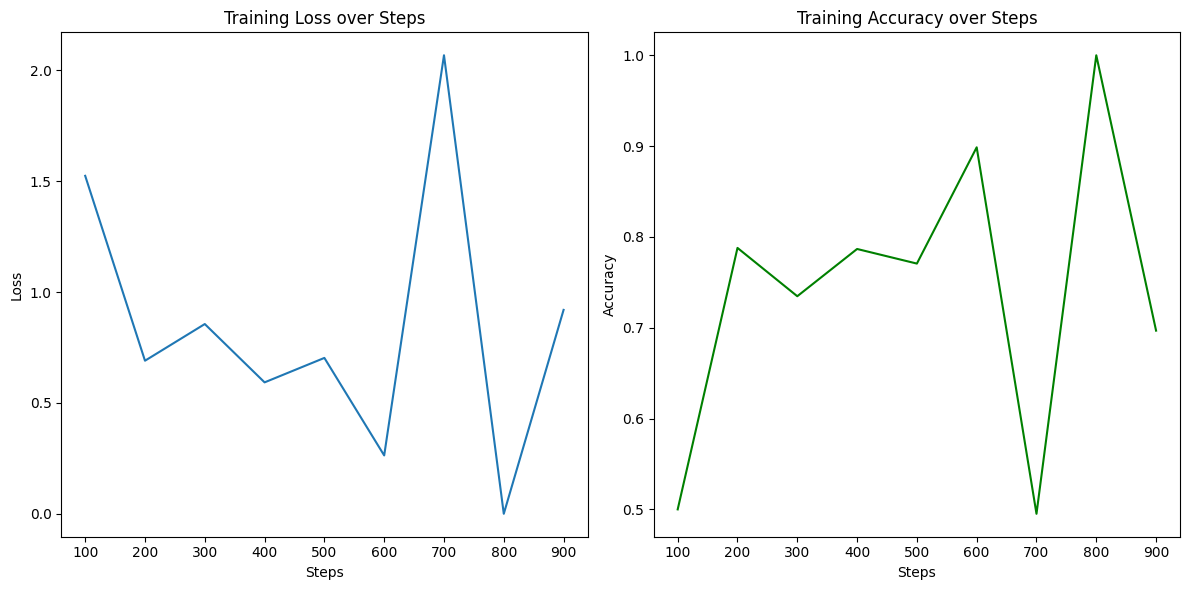

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ehbx8qLAxRzs5An0SrCDWas2",
      "created_at": 1693062909,
      "level": "info",
      "message": "Step 900/2100: training loss=0.92",
      "data": {
        "step": 900,
        "train_loss": 0.919586718082428,
        "train_mean_token_accuracy": 0.6967930197715759
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 900 | Loss: 0.919586718082428 | Accuracy: 0.6967930197715759


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

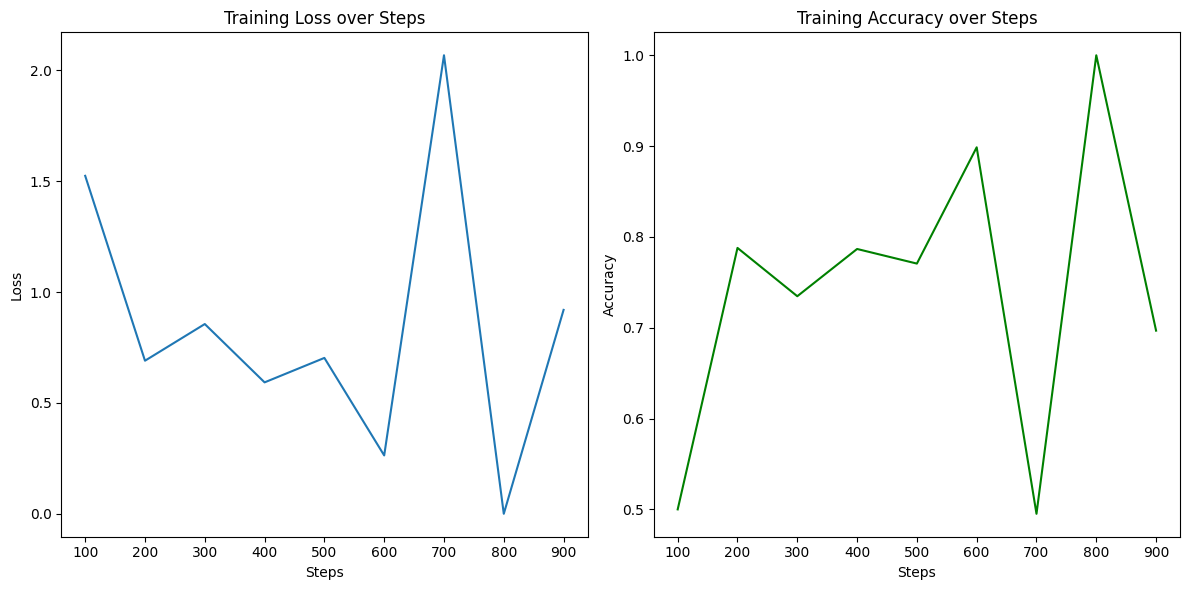

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-kyRpW43uuLcRi26ijJGy1hrq",
      "created_at": 1693063028,
      "level": "info",
      "message": "Step 1000/2100: training loss=0.21",
      "data": {
        "step": 1000,
        "train_loss": 0.20716716349124908,
        "train_mean_token_accuracy": 0.9298596978187561
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1000 | Loss: 0.20716716349124908 | Accuracy: 0.9298596978187561


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

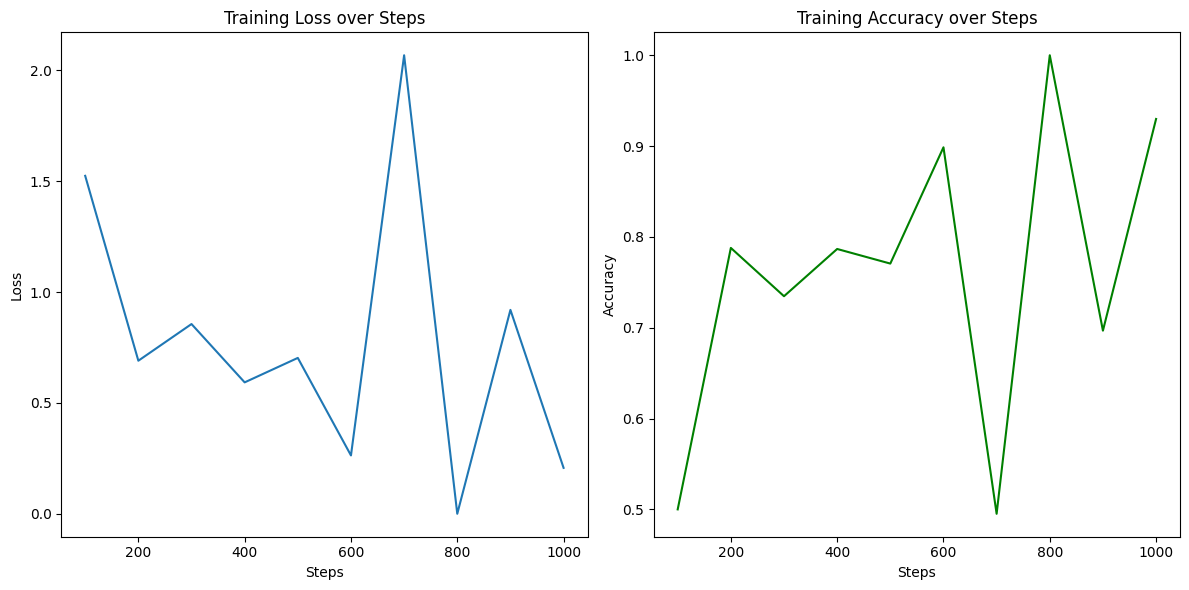

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-kyRpW43uuLcRi26ijJGy1hrq",
      "created_at": 1693063028,
      "level": "info",
      "message": "Step 1000/2100: training loss=0.21",
      "data": {
        "step": 1000,
        "train_loss": 0.20716716349124908,
        "train_mean_token_accuracy": 0.9298596978187561
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1000 | Loss: 0.20716716349124908 | Accuracy: 0.9298596978187561


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

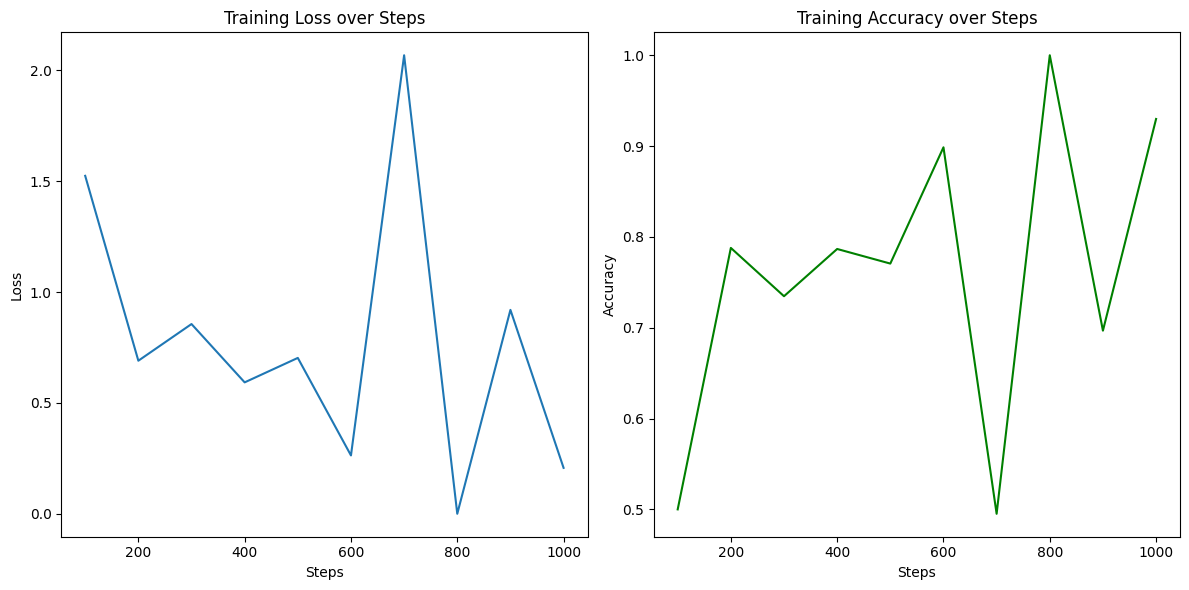

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-kyRpW43uuLcRi26ijJGy1hrq",
      "created_at": 1693063028,
      "level": "info",
      "message": "Step 1000/2100: training loss=0.21",
      "data": {
        "step": 1000,
        "train_loss": 0.20716716349124908,
        "train_mean_token_accuracy": 0.9298596978187561
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1000 | Loss: 0.20716716349124908 | Accuracy: 0.9298596978187561


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

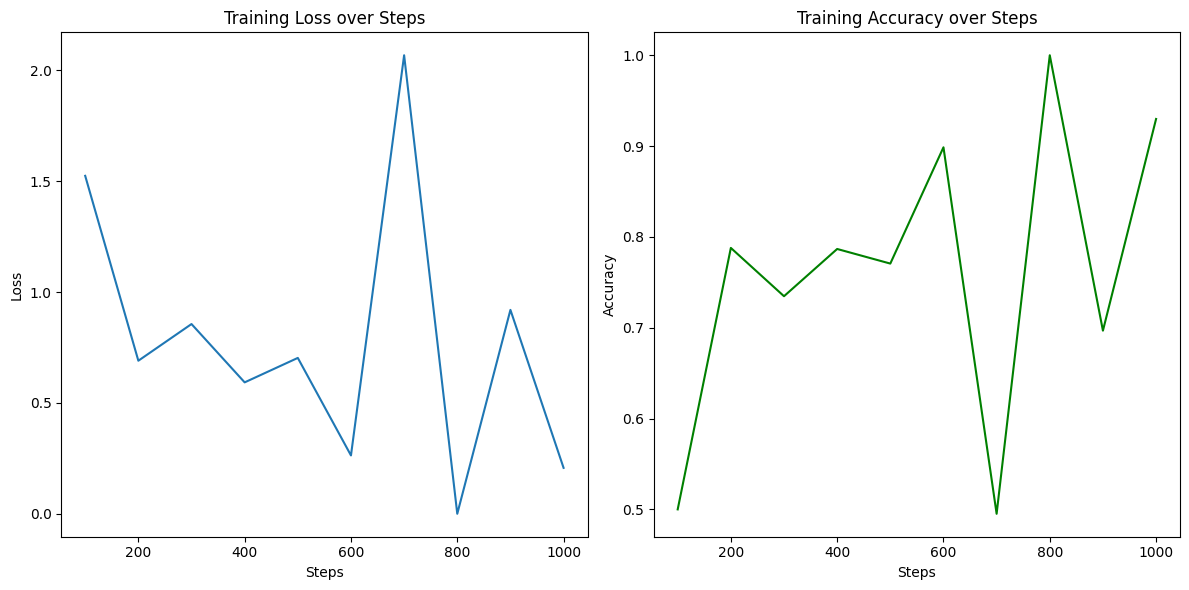

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-kyRpW43uuLcRi26ijJGy1hrq",
      "created_at": 1693063028,
      "level": "info",
      "message": "Step 1000/2100: training loss=0.21",
      "data": {
        "step": 1000,
        "train_loss": 0.20716716349124908,
        "train_mean_token_accuracy": 0.9298596978187561
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1000 | Loss: 0.20716716349124908 | Accuracy: 0.9298596978187561


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

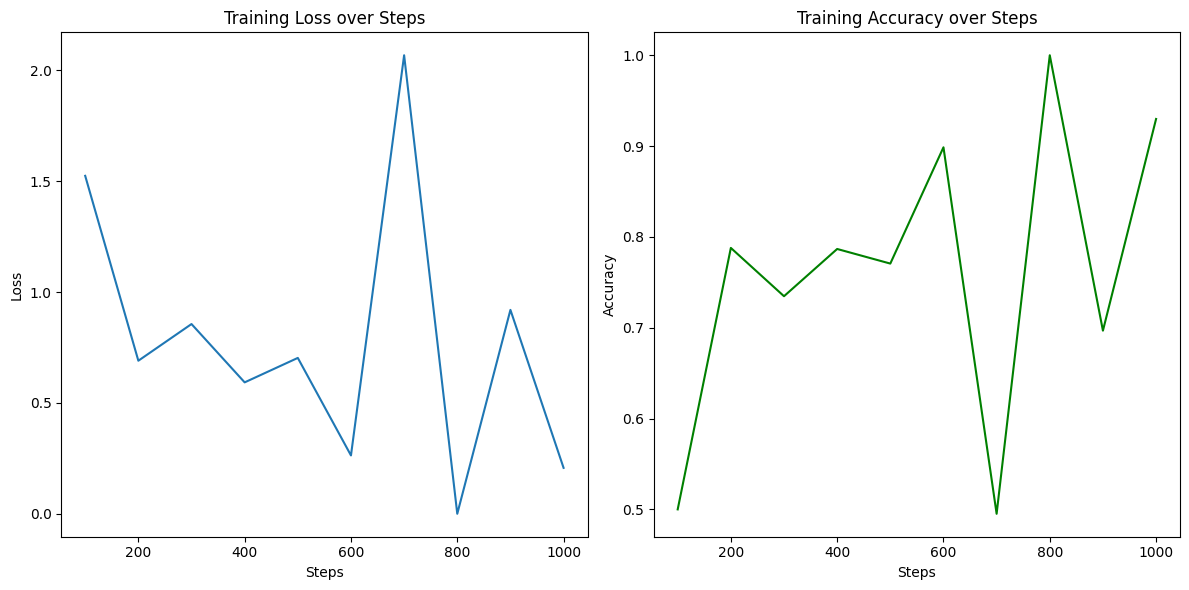

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ibYPhFOjZYne4x4jtsP4pE1C",
      "created_at": 1693063149,
      "level": "info",
      "message": "Step 1100/2100: training loss=0.49",
      "data": {
        "step": 1100,
        "train_loss": 0.4926701486110687,
        "train_mean_token_accuracy": 0.8292682766914368
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1100 | Loss: 0.4926701486110687 | Accuracy: 0.8292682766914368


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

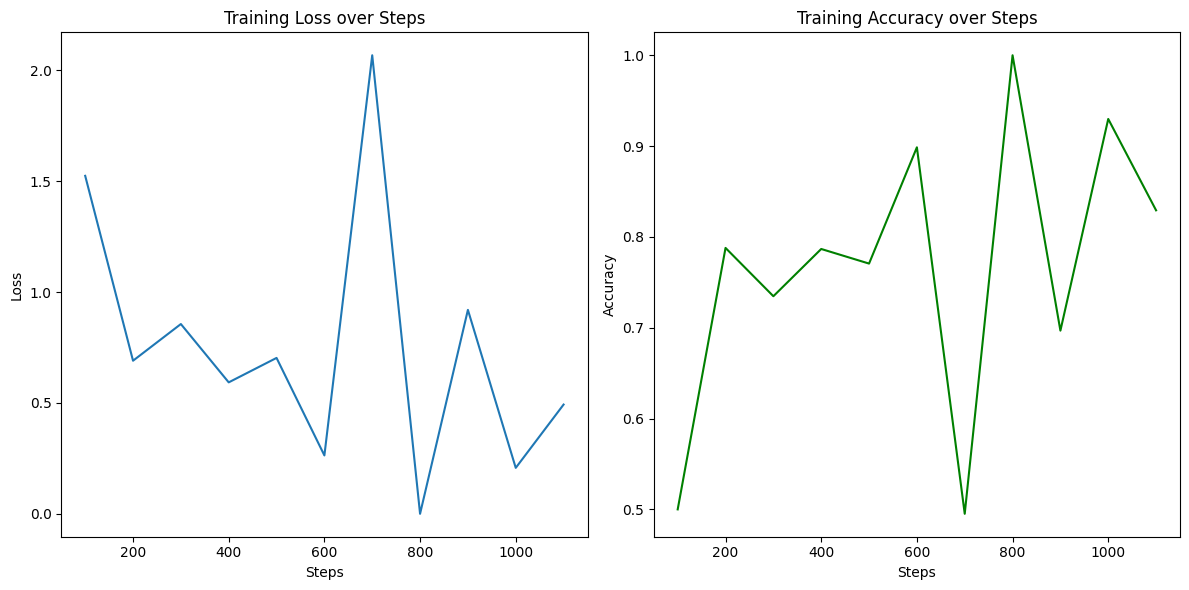

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ibYPhFOjZYne4x4jtsP4pE1C",
      "created_at": 1693063149,
      "level": "info",
      "message": "Step 1100/2100: training loss=0.49",
      "data": {
        "step": 1100,
        "train_loss": 0.4926701486110687,
        "train_mean_token_accuracy": 0.8292682766914368
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1100 | Loss: 0.4926701486110687 | Accuracy: 0.8292682766914368


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

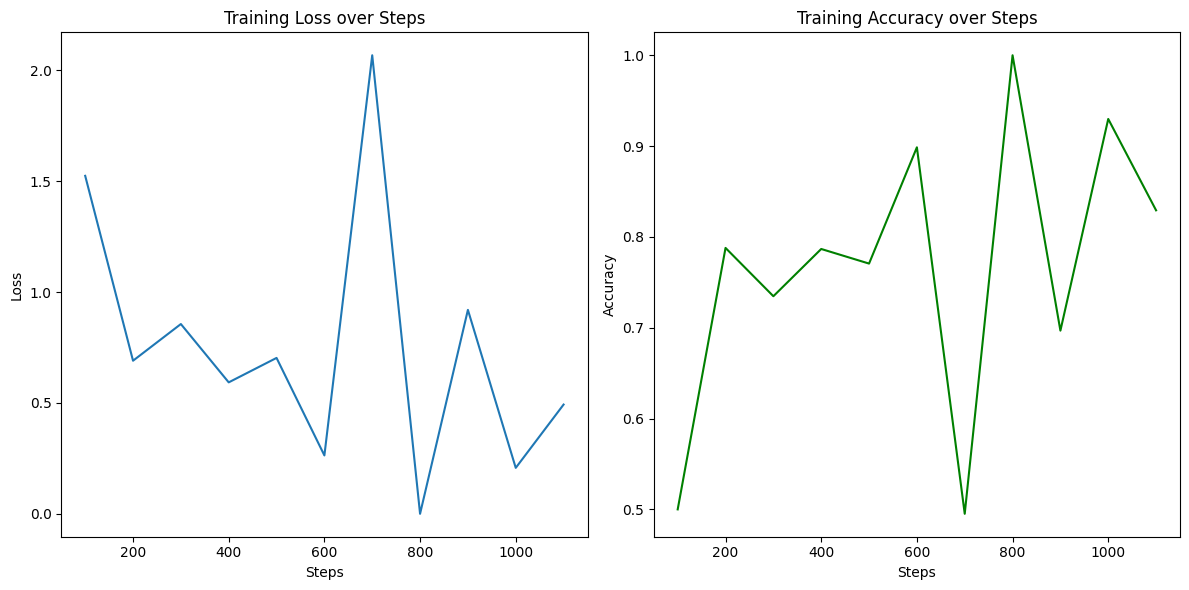

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ibYPhFOjZYne4x4jtsP4pE1C",
      "created_at": 1693063149,
      "level": "info",
      "message": "Step 1100/2100: training loss=0.49",
      "data": {
        "step": 1100,
        "train_loss": 0.4926701486110687,
        "train_mean_token_accuracy": 0.8292682766914368
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1100 | Loss: 0.4926701486110687 | Accuracy: 0.8292682766914368


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

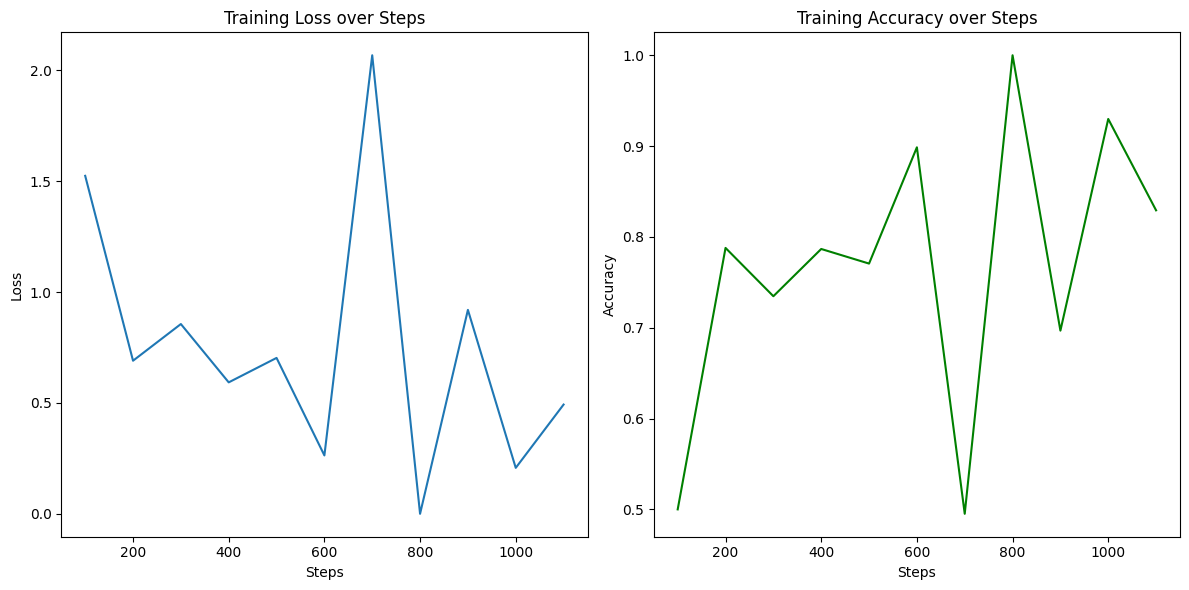

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-ibYPhFOjZYne4x4jtsP4pE1C",
      "created_at": 1693063149,
      "level": "info",
      "message": "Step 1100/2100: training loss=0.49",
      "data": {
        "step": 1100,
        "train_loss": 0.4926701486110687,
        "train_mean_token_accuracy": 0.8292682766914368
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1100 | Loss: 0.4926701486110687 | Accuracy: 0.8292682766914368


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

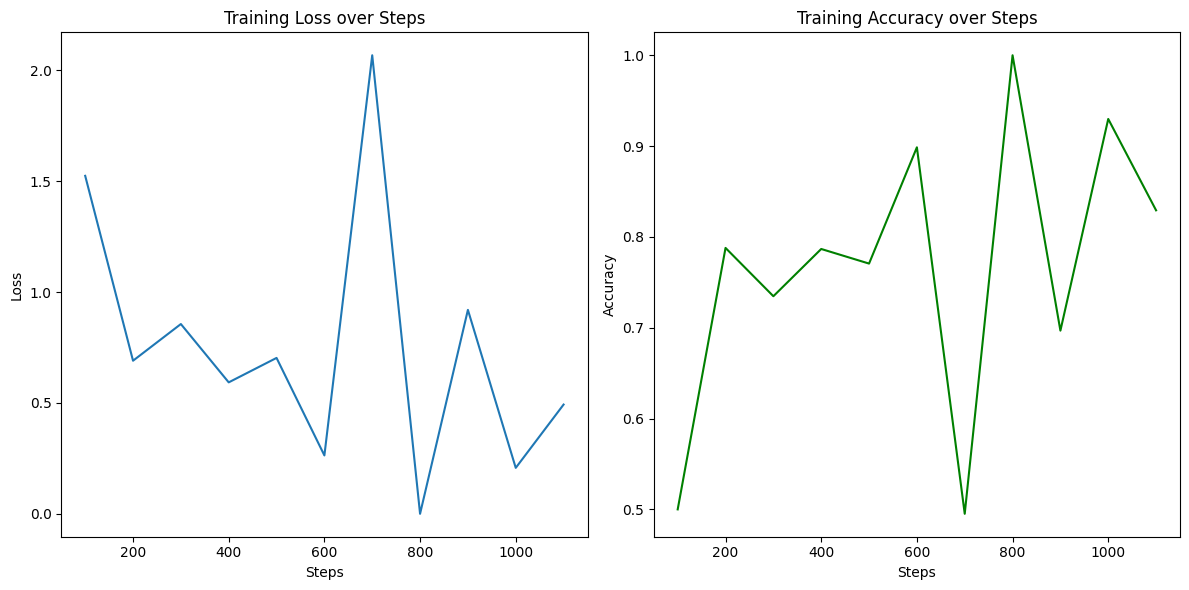

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-uKKyPVaouNPA5VlKFB8V9ZDt",
      "created_at": 1693063270,
      "level": "info",
      "message": "Step 1200/2100: training loss=0.42",
      "data": {
        "step": 1200,
        "train_loss": 0.41695380210876465,
        "train_mean_token_accuracy": 0.8736842274665833
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1200 | Loss: 0.41695380210876465 | Accuracy: 0.8736842274665833


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

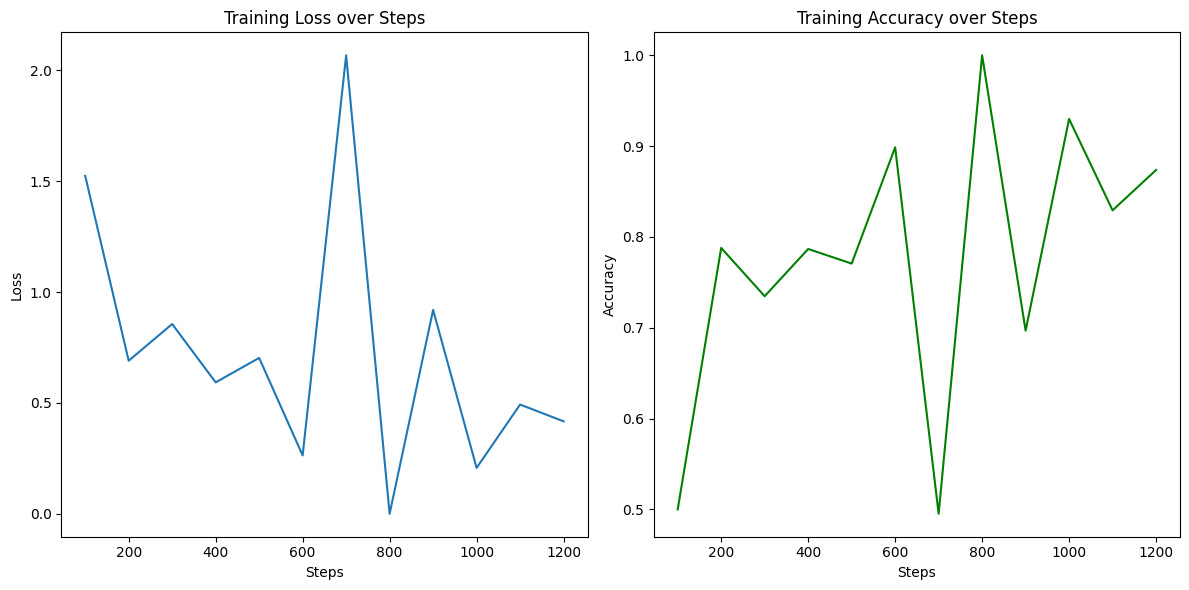

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-uKKyPVaouNPA5VlKFB8V9ZDt",
      "created_at": 1693063270,
      "level": "info",
      "message": "Step 1200/2100: training loss=0.42",
      "data": {
        "step": 1200,
        "train_loss": 0.41695380210876465,
        "train_mean_token_accuracy": 0.8736842274665833
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1200 | Loss: 0.41695380210876465 | Accuracy: 0.8736842274665833


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

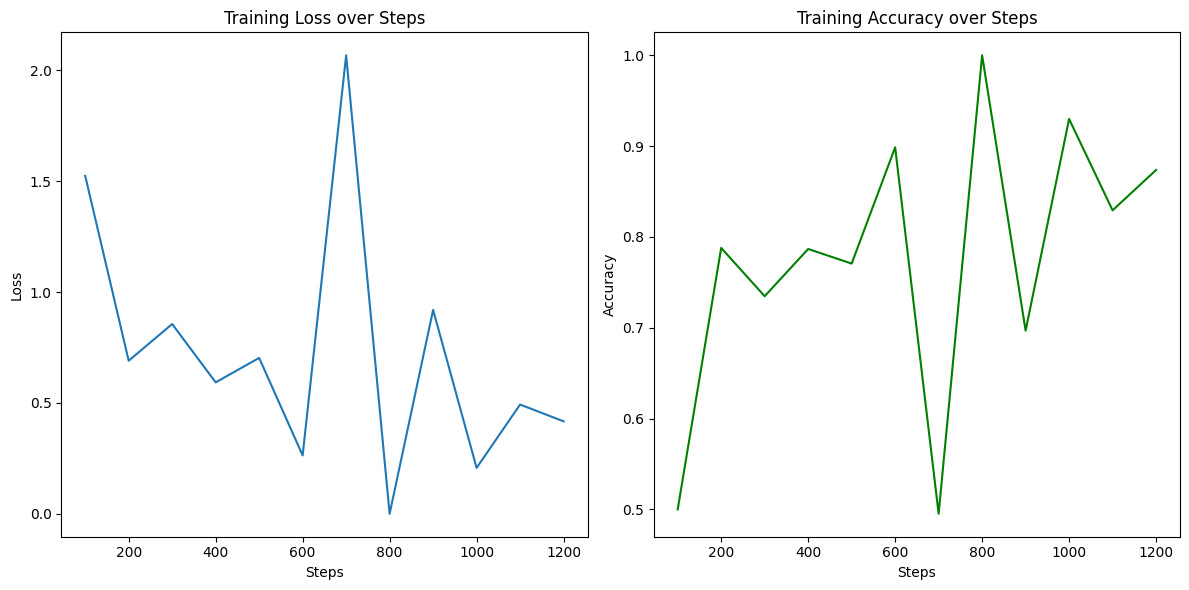

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-uKKyPVaouNPA5VlKFB8V9ZDt",
      "created_at": 1693063270,
      "level": "info",
      "message": "Step 1200/2100: training loss=0.42",
      "data": {
        "step": 1200,
        "train_loss": 0.41695380210876465,
        "train_mean_token_accuracy": 0.8736842274665833
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1200 | Loss: 0.41695380210876465 | Accuracy: 0.8736842274665833


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

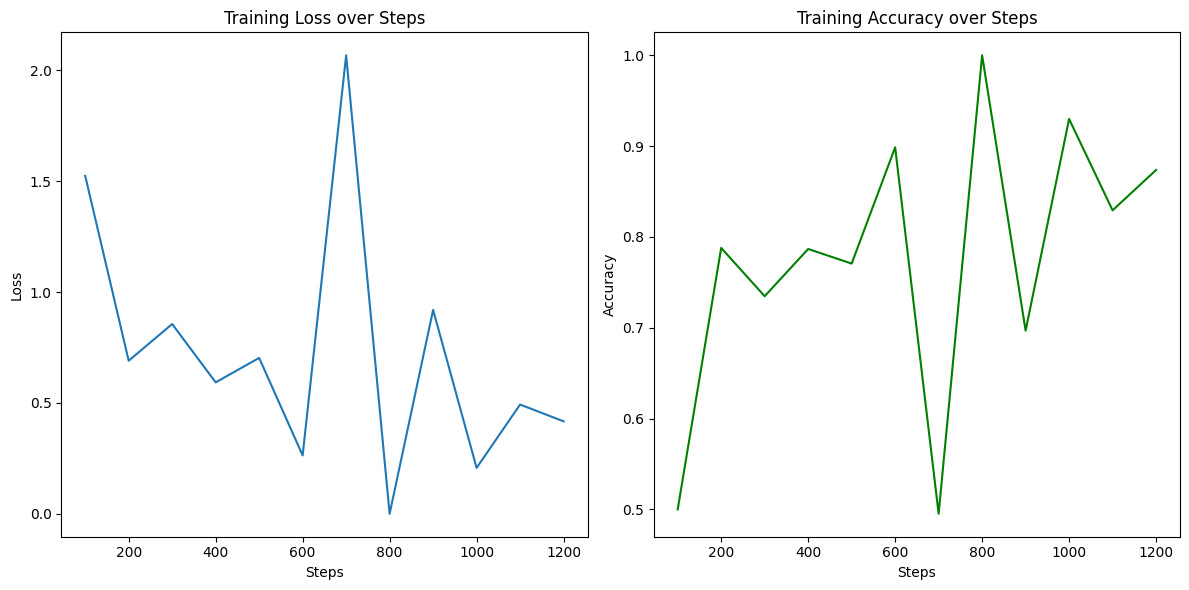

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-Glo8Lc3chREPbhOjUt23IeNa",
      "created_at": 1693063393,
      "level": "info",
      "message": "Step 1300/2100: training loss=0.39",
      "data": {
        "step": 1300,
        "train_loss": 0.3895539343357086,
        "train_mean_token_accuracy": 0.8787878751754761
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1300 | Loss: 0.3895539343357086 | Accuracy: 0.8787878751754761


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

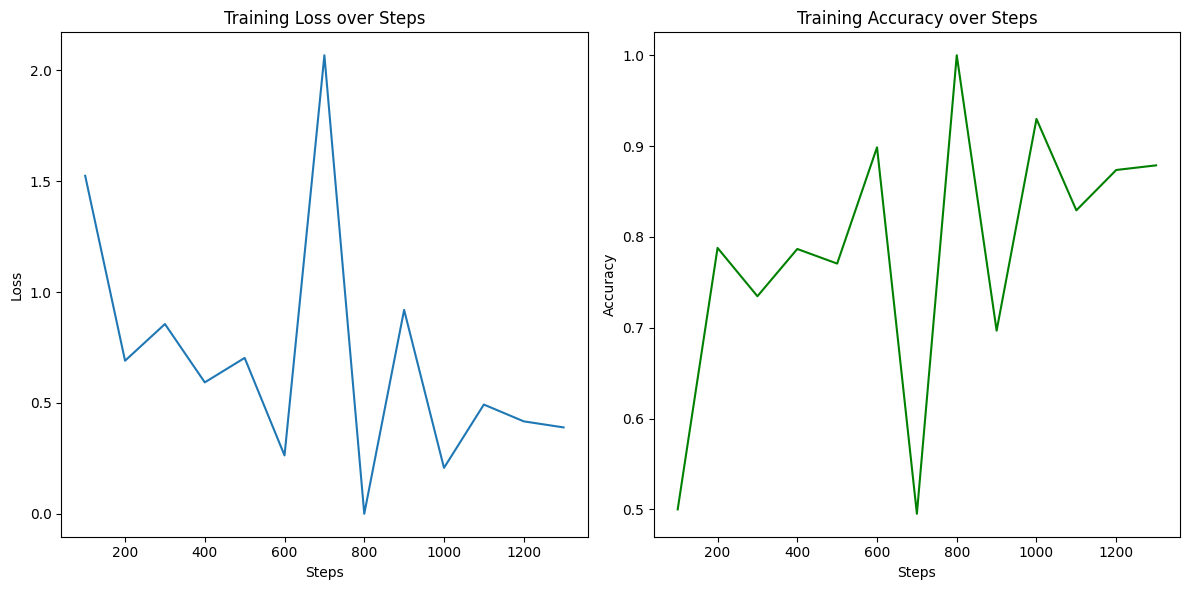

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-Glo8Lc3chREPbhOjUt23IeNa",
      "created_at": 1693063393,
      "level": "info",
      "message": "Step 1300/2100: training loss=0.39",
      "data": {
        "step": 1300,
        "train_loss": 0.3895539343357086,
        "train_mean_token_accuracy": 0.8787878751754761
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1300 | Loss: 0.3895539343357086 | Accuracy: 0.8787878751754761


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

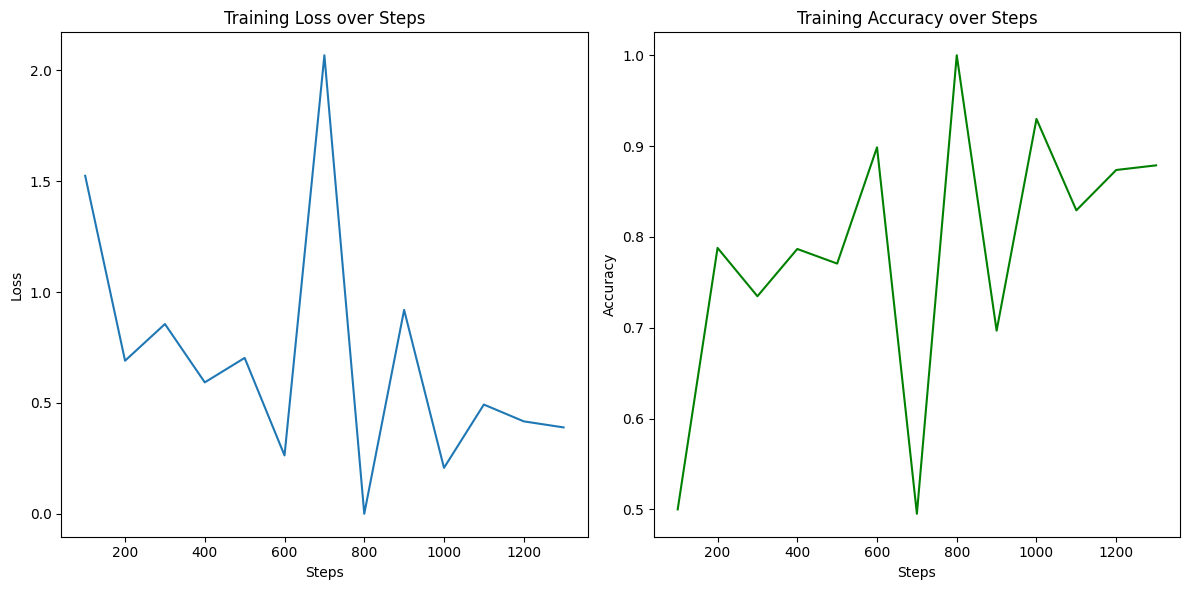

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-Glo8Lc3chREPbhOjUt23IeNa",
      "created_at": 1693063393,
      "level": "info",
      "message": "Step 1300/2100: training loss=0.39",
      "data": {
        "step": 1300,
        "train_loss": 0.3895539343357086,
        "train_mean_token_accuracy": 0.8787878751754761
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1300 | Loss: 0.3895539343357086 | Accuracy: 0.8787878751754761


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

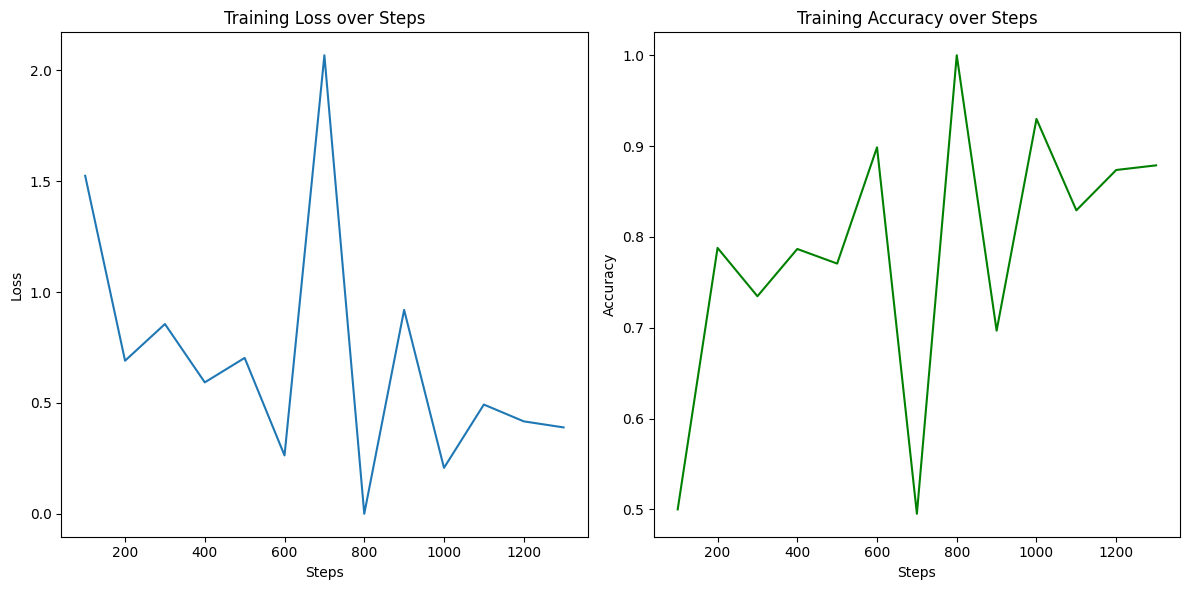

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-Glo8Lc3chREPbhOjUt23IeNa",
      "created_at": 1693063393,
      "level": "info",
      "message": "Step 1300/2100: training loss=0.39",
      "data": {
        "step": 1300,
        "train_loss": 0.3895539343357086,
        "train_mean_token_accuracy": 0.8787878751754761
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1300 | Loss: 0.3895539343357086 | Accuracy: 0.8787878751754761


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

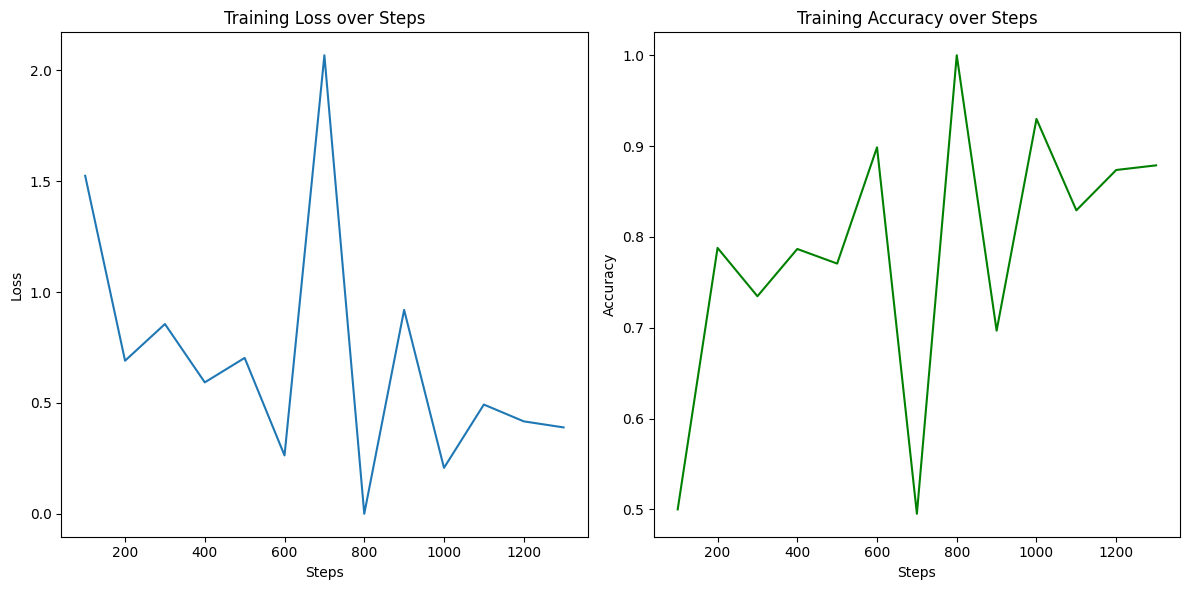

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-CvMyNML6mljPRbgiOsnhpssE",
      "created_at": 1693063514,
      "level": "info",
      "message": "Step 1400/2100: training loss=1.30",
      "data": {
        "step": 1400,
        "train_loss": 1.2972763776779175,
        "train_mean_token_accuracy": 0.6714285612106323
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1400 | Loss: 1.2972763776779175 | Accuracy: 0.6714285612106323


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

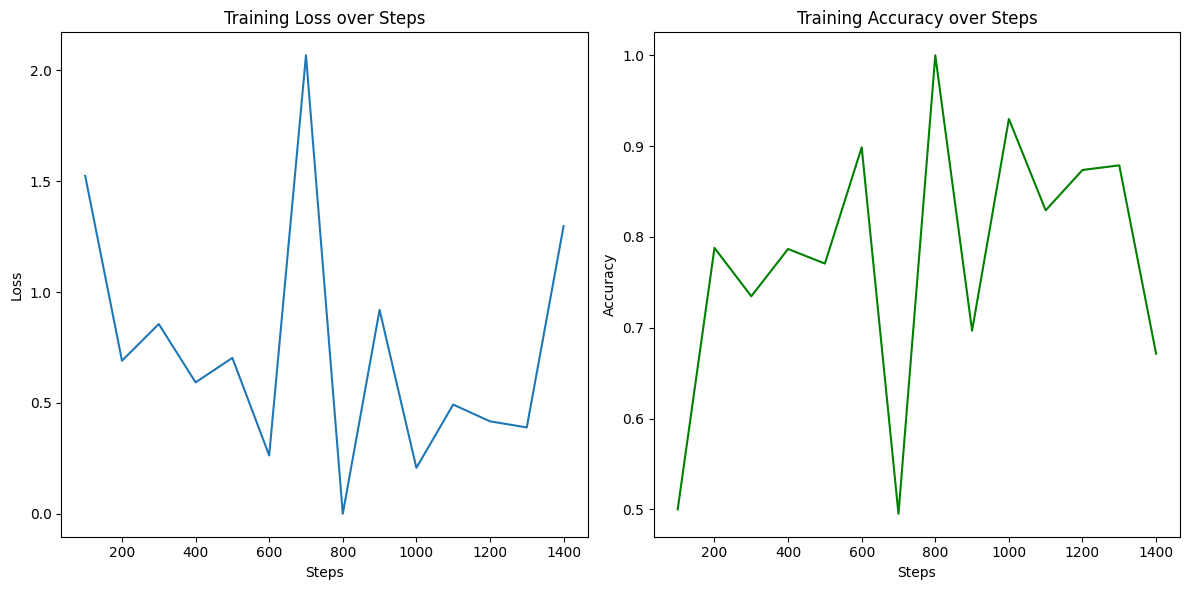

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-CvMyNML6mljPRbgiOsnhpssE",
      "created_at": 1693063514,
      "level": "info",
      "message": "Step 1400/2100: training loss=1.30",
      "data": {
        "step": 1400,
        "train_loss": 1.2972763776779175,
        "train_mean_token_accuracy": 0.6714285612106323
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1400 | Loss: 1.2972763776779175 | Accuracy: 0.6714285612106323


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

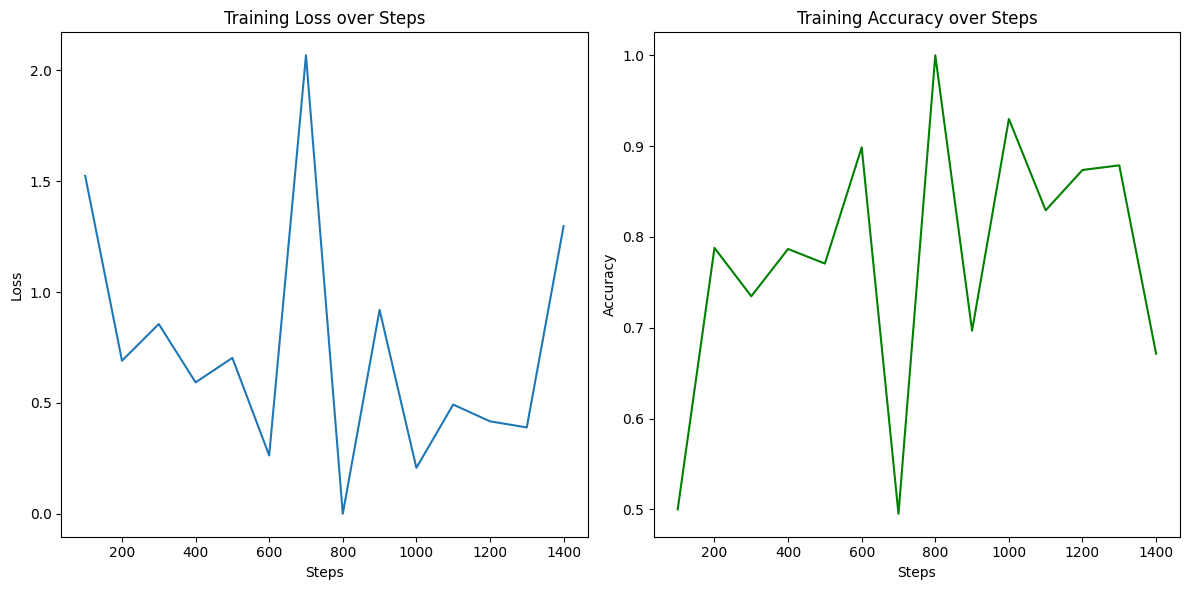

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-CvMyNML6mljPRbgiOsnhpssE",
      "created_at": 1693063514,
      "level": "info",
      "message": "Step 1400/2100: training loss=1.30",
      "data": {
        "step": 1400,
        "train_loss": 1.2972763776779175,
        "train_mean_token_accuracy": 0.6714285612106323
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1400 | Loss: 1.2972763776779175 | Accuracy: 0.6714285612106323


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

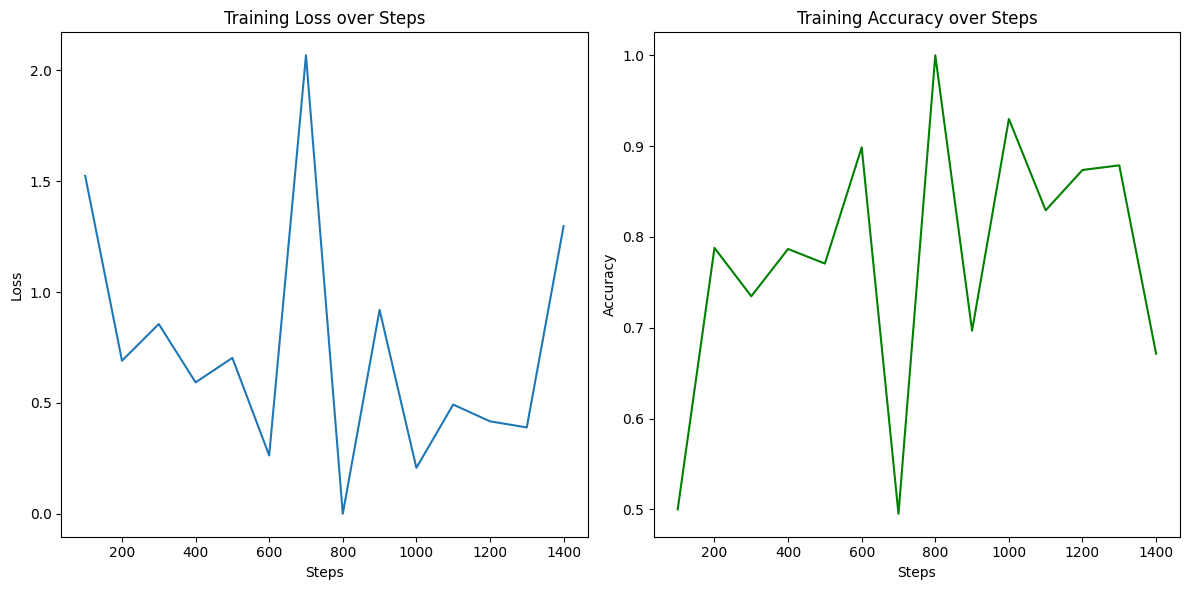

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-CvMyNML6mljPRbgiOsnhpssE",
      "created_at": 1693063514,
      "level": "info",
      "message": "Step 1400/2100: training loss=1.30",
      "data": {
        "step": 1400,
        "train_loss": 1.2972763776779175,
        "train_mean_token_accuracy": 0.6714285612106323
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1400 | Loss: 1.2972763776779175 | Accuracy: 0.6714285612106323


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

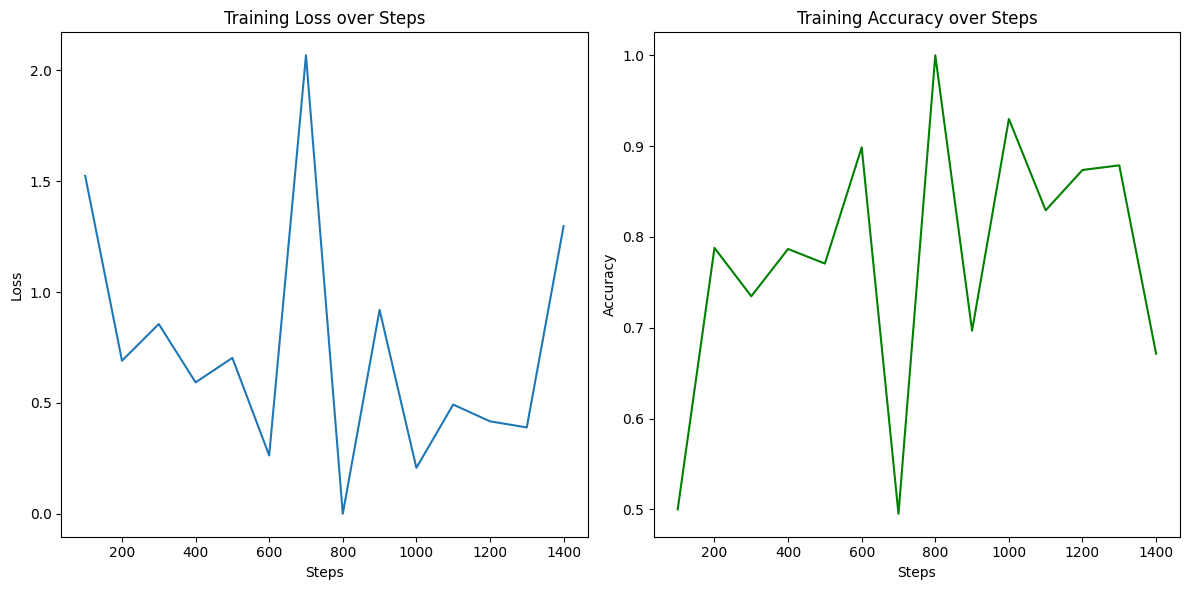

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-nUCieC3wXae9nYuctJ6qIEKm",
      "created_at": 1693063637,
      "level": "info",
      "message": "Step 1500/2100: training loss=0.57",
      "data": {
        "step": 1500,
        "train_loss": 0.5677338242530823,
        "train_mean_token_accuracy": 0.8282828330993652
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1500 | Loss: 0.5677338242530823 | Accuracy: 0.8282828330993652


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

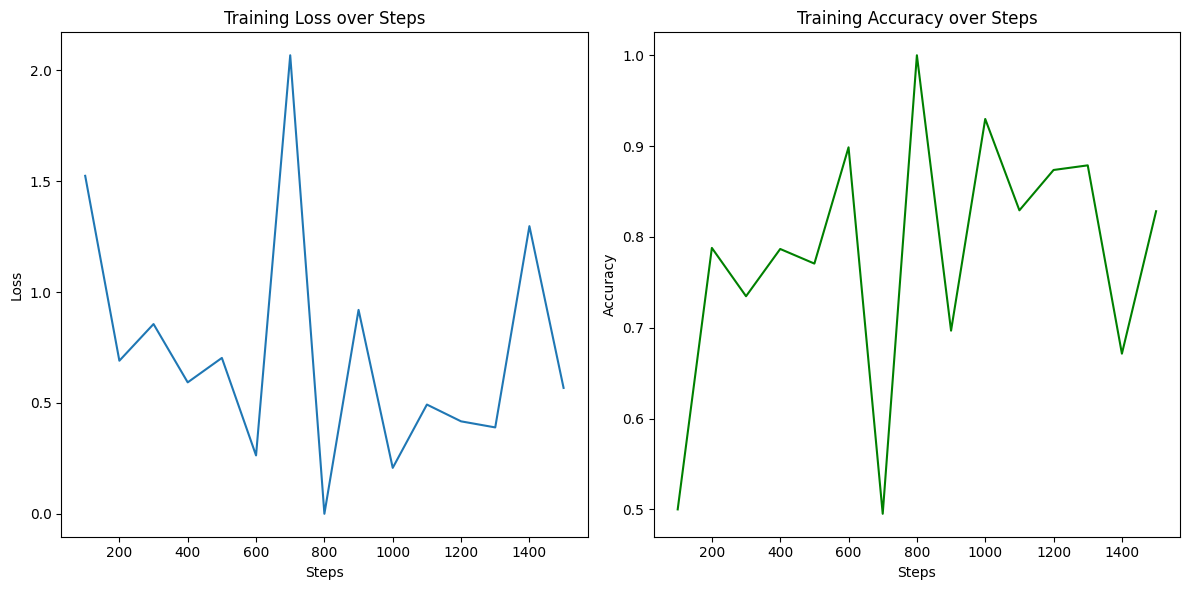

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-nUCieC3wXae9nYuctJ6qIEKm",
      "created_at": 1693063637,
      "level": "info",
      "message": "Step 1500/2100: training loss=0.57",
      "data": {
        "step": 1500,
        "train_loss": 0.5677338242530823,
        "train_mean_token_accuracy": 0.8282828330993652
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1500 | Loss: 0.5677338242530823 | Accuracy: 0.8282828330993652


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

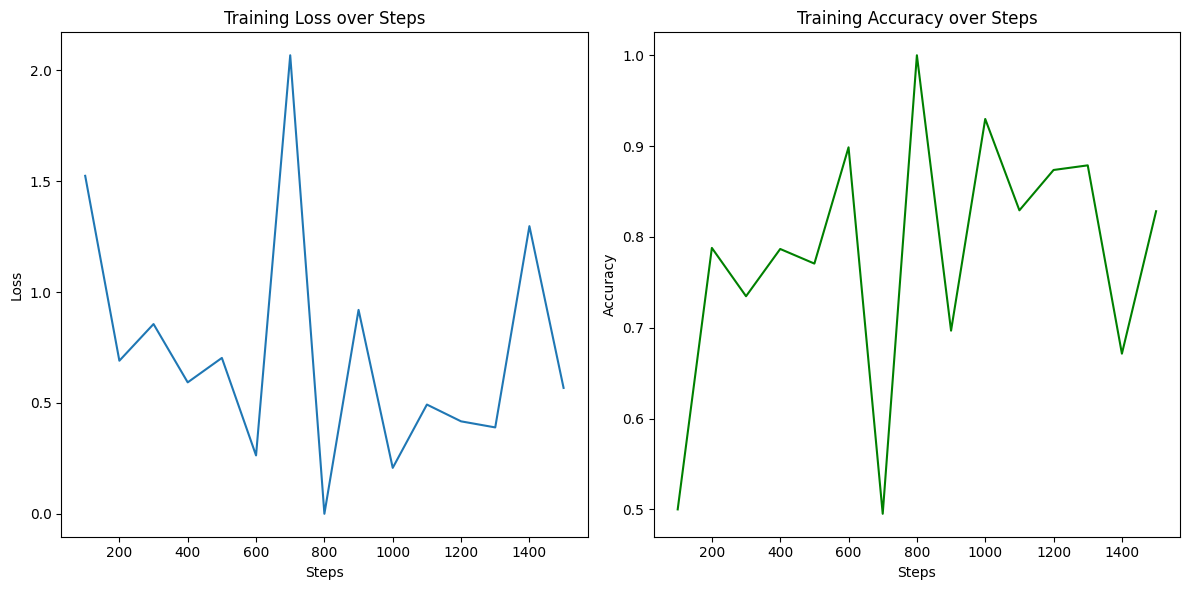

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-nUCieC3wXae9nYuctJ6qIEKm",
      "created_at": 1693063637,
      "level": "info",
      "message": "Step 1500/2100: training loss=0.57",
      "data": {
        "step": 1500,
        "train_loss": 0.5677338242530823,
        "train_mean_token_accuracy": 0.8282828330993652
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1500 | Loss: 0.5677338242530823 | Accuracy: 0.8282828330993652


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

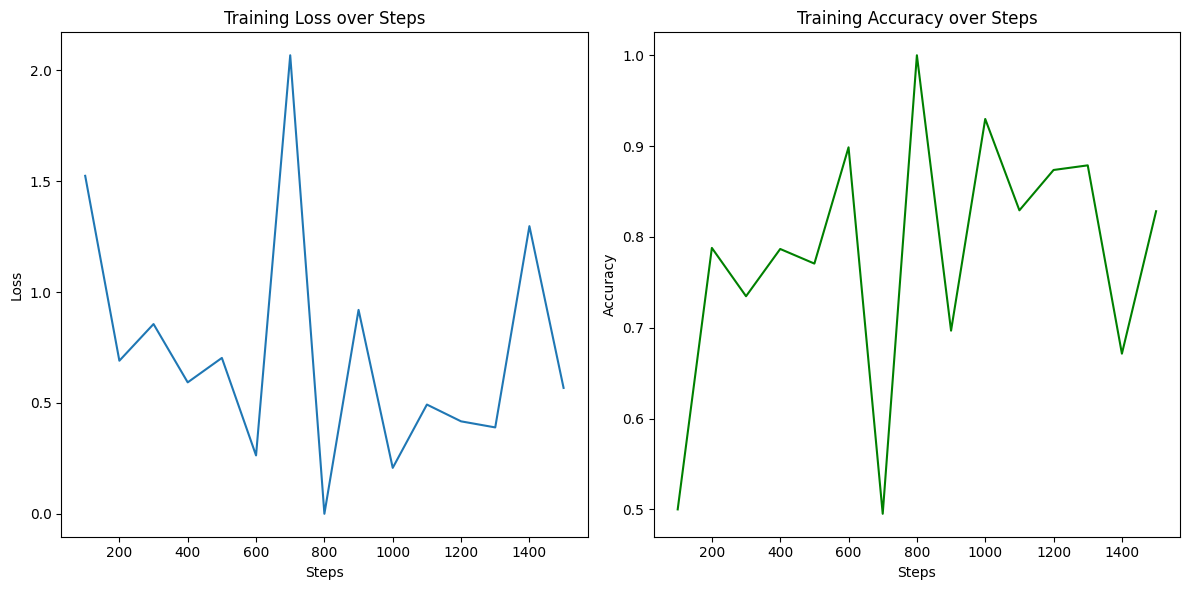

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-nUCieC3wXae9nYuctJ6qIEKm",
      "created_at": 1693063637,
      "level": "info",
      "message": "Step 1500/2100: training loss=0.57",
      "data": {
        "step": 1500,
        "train_loss": 0.5677338242530823,
        "train_mean_token_accuracy": 0.8282828330993652
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1500 | Loss: 0.5677338242530823 | Accuracy: 0.8282828330993652


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

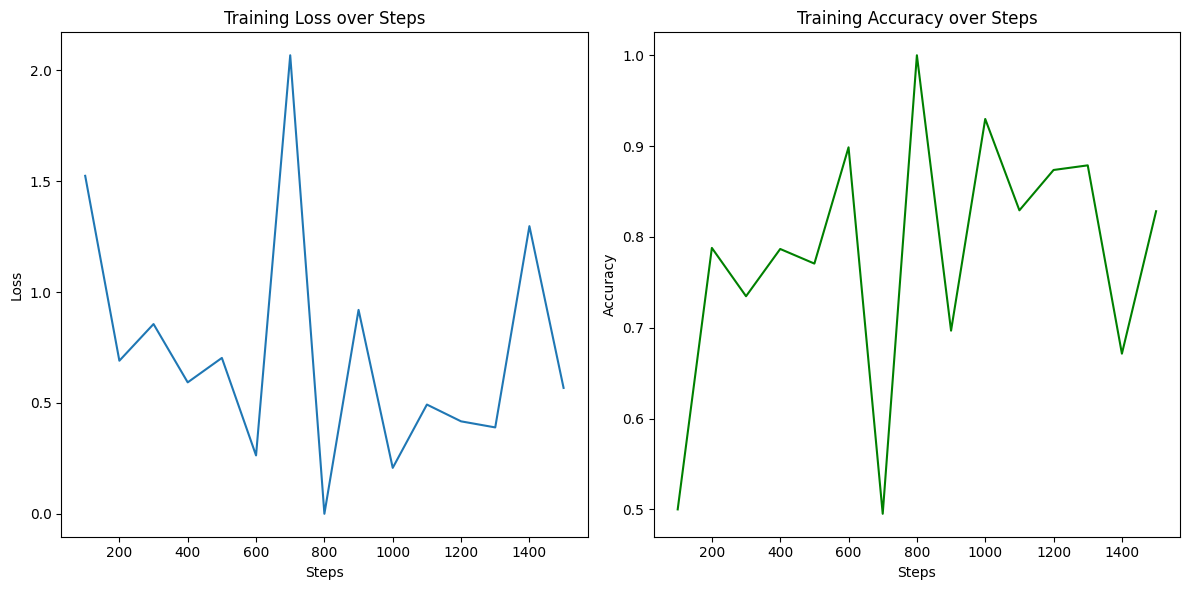

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-GhCEzgbPQOvymcqt0v9dTOGg",
      "created_at": 1693063760,
      "level": "info",
      "message": "Step 1600/2100: training loss=0.28",
      "data": {
        "step": 1600,
        "train_loss": 0.2828480005264282,
        "train_mean_token_accuracy": 0.9097744226455688
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1600 | Loss: 0.2828480005264282 | Accuracy: 0.9097744226455688


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

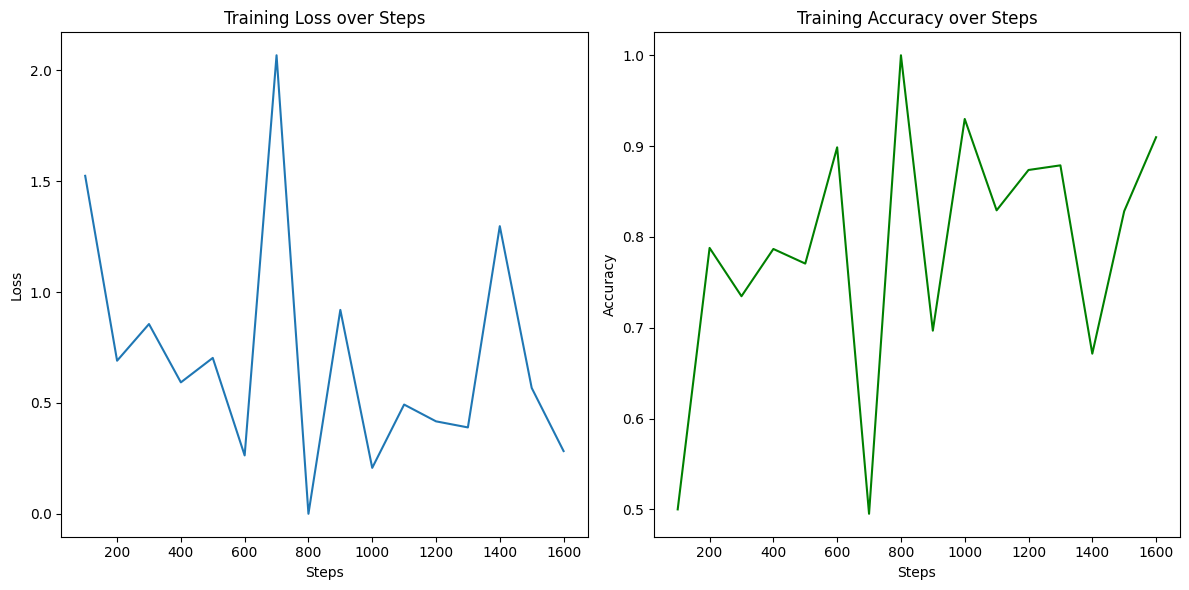

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-GhCEzgbPQOvymcqt0v9dTOGg",
      "created_at": 1693063760,
      "level": "info",
      "message": "Step 1600/2100: training loss=0.28",
      "data": {
        "step": 1600,
        "train_loss": 0.2828480005264282,
        "train_mean_token_accuracy": 0.9097744226455688
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1600 | Loss: 0.2828480005264282 | Accuracy: 0.9097744226455688


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

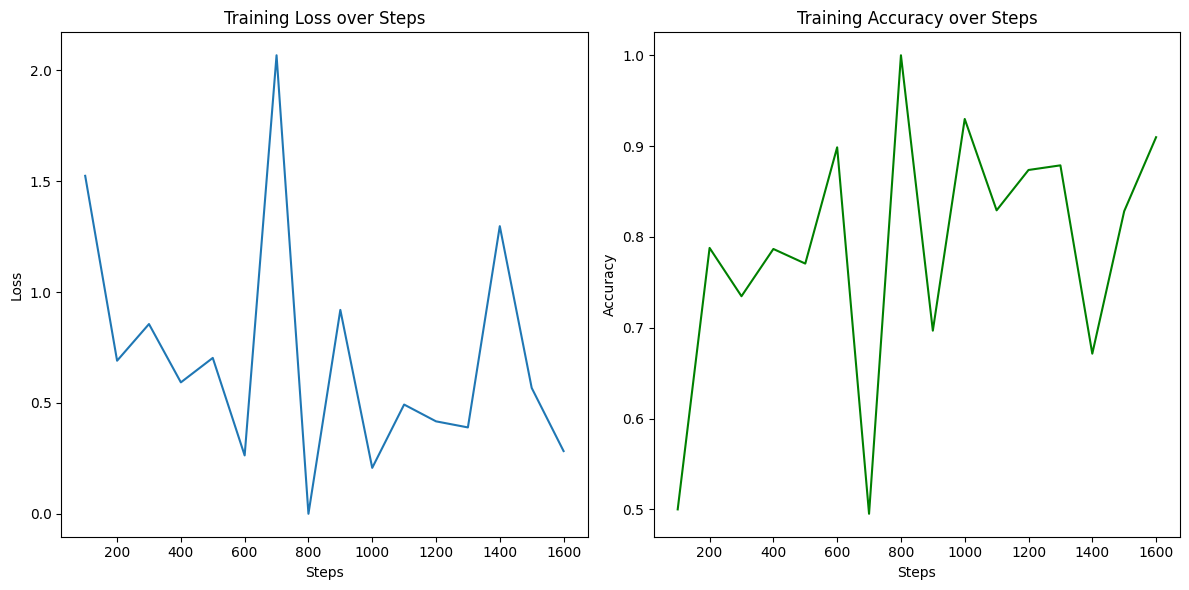

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-GhCEzgbPQOvymcqt0v9dTOGg",
      "created_at": 1693063760,
      "level": "info",
      "message": "Step 1600/2100: training loss=0.28",
      "data": {
        "step": 1600,
        "train_loss": 0.2828480005264282,
        "train_mean_token_accuracy": 0.9097744226455688
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1600 | Loss: 0.2828480005264282 | Accuracy: 0.9097744226455688


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

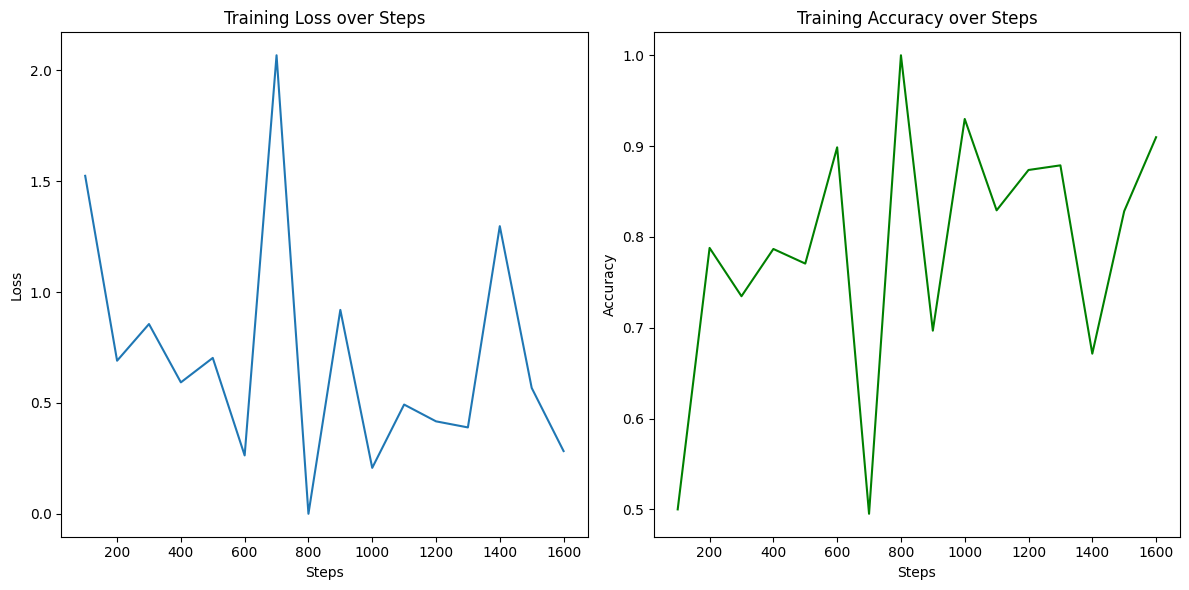

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-GhCEzgbPQOvymcqt0v9dTOGg",
      "created_at": 1693063760,
      "level": "info",
      "message": "Step 1600/2100: training loss=0.28",
      "data": {
        "step": 1600,
        "train_loss": 0.2828480005264282,
        "train_mean_token_accuracy": 0.9097744226455688
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1600 | Loss: 0.2828480005264282 | Accuracy: 0.9097744226455688


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

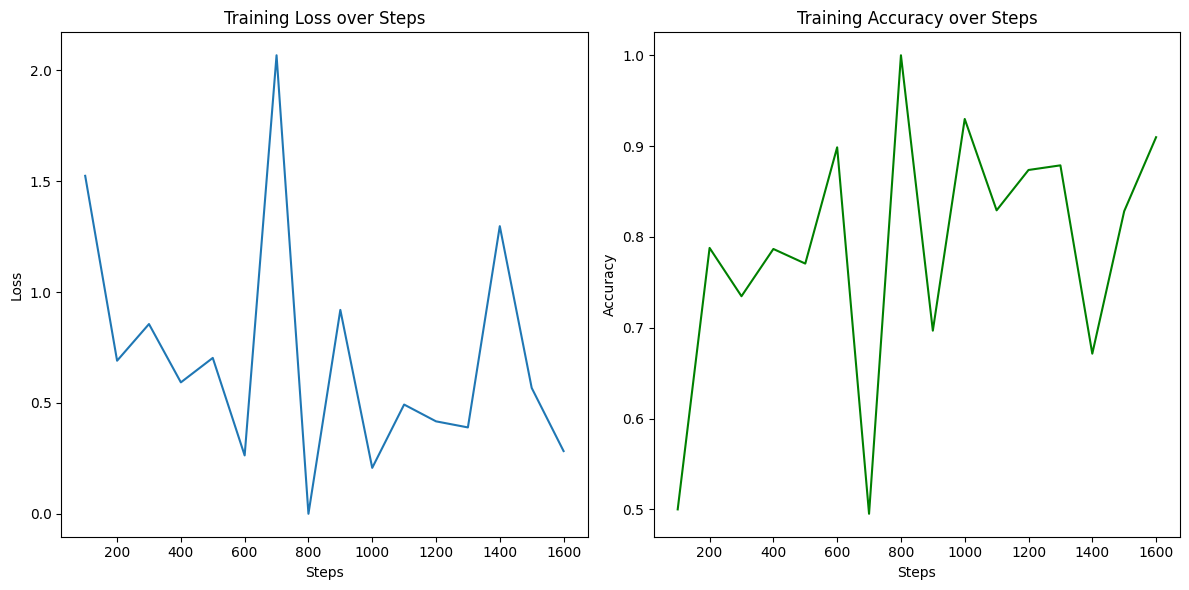

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-NbZgIss6FXLGsG89GsUHJ19P",
      "created_at": 1693063893,
      "level": "info",
      "message": "Step 1700/2100: training loss=0.26",
      "data": {
        "step": 1700,
        "train_loss": 0.2643193006515503,
        "train_mean_token_accuracy": 0.9151515364646912
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1700 | Loss: 0.2643193006515503 | Accuracy: 0.9151515364646912


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

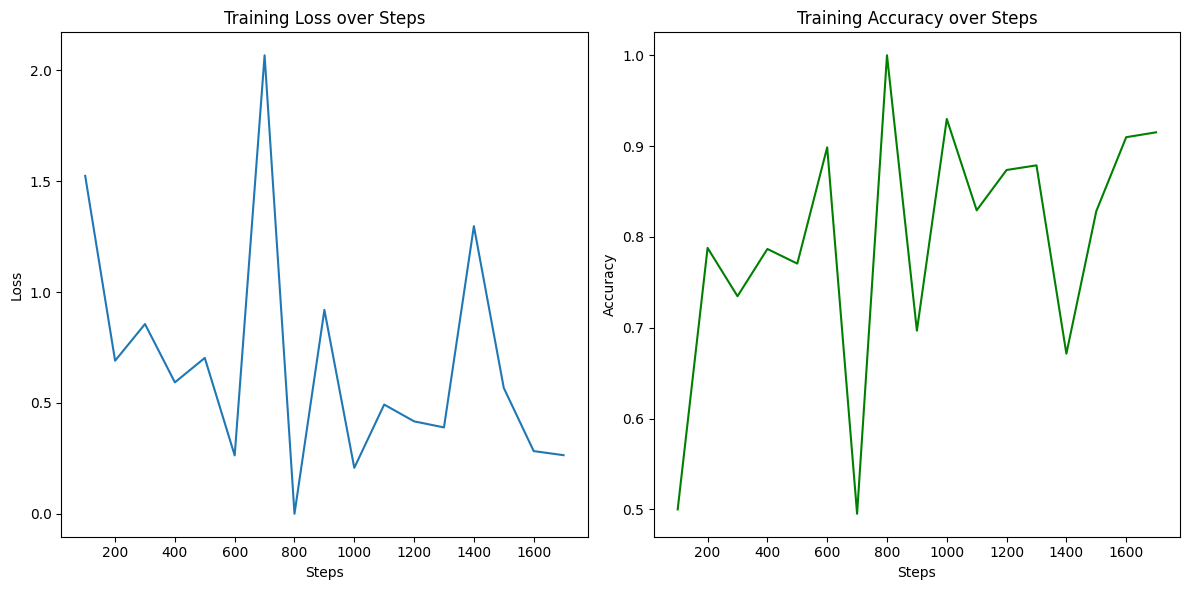

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-NbZgIss6FXLGsG89GsUHJ19P",
      "created_at": 1693063893,
      "level": "info",
      "message": "Step 1700/2100: training loss=0.26",
      "data": {
        "step": 1700,
        "train_loss": 0.2643193006515503,
        "train_mean_token_accuracy": 0.9151515364646912
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1700 | Loss: 0.2643193006515503 | Accuracy: 0.9151515364646912


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

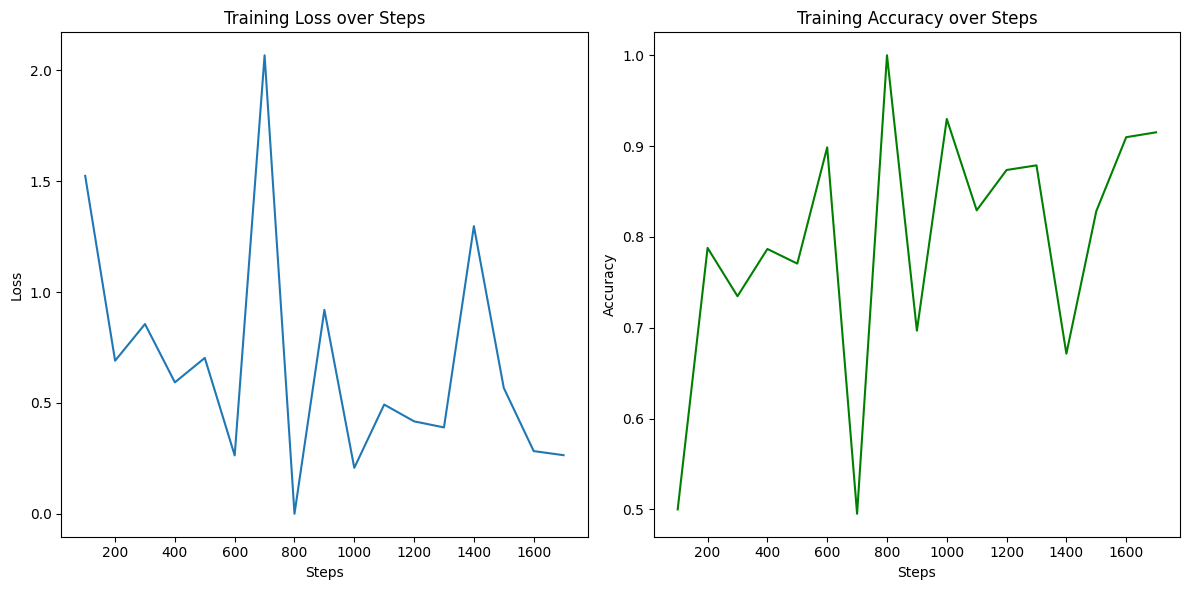

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-NbZgIss6FXLGsG89GsUHJ19P",
      "created_at": 1693063893,
      "level": "info",
      "message": "Step 1700/2100: training loss=0.26",
      "data": {
        "step": 1700,
        "train_loss": 0.2643193006515503,
        "train_mean_token_accuracy": 0.9151515364646912
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1700 | Loss: 0.2643193006515503 | Accuracy: 0.9151515364646912


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

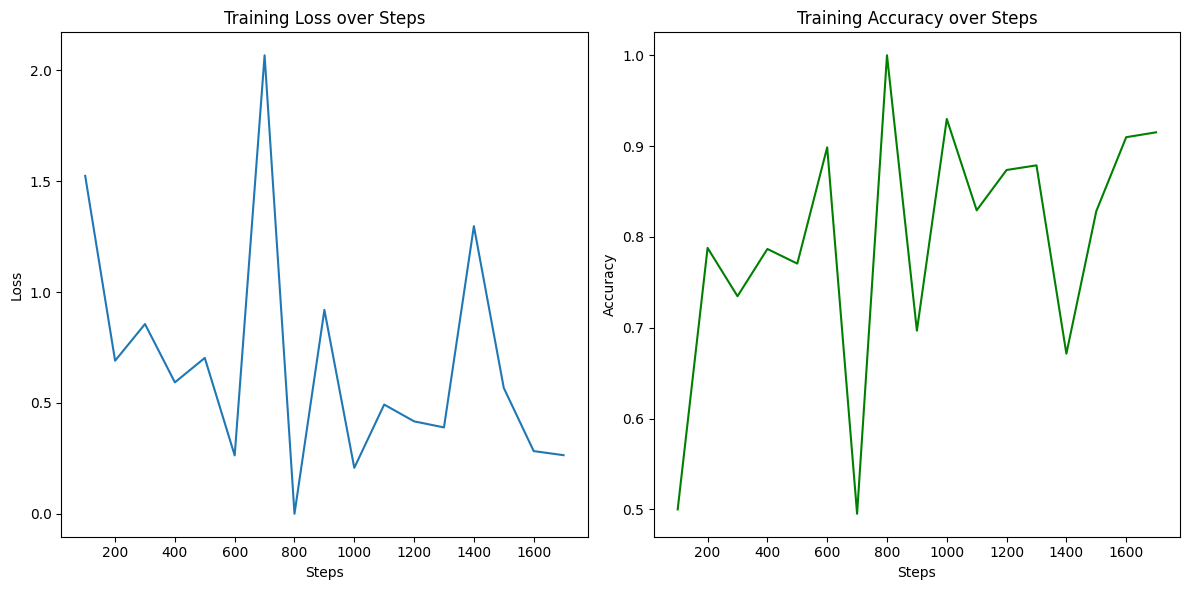

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-NbZgIss6FXLGsG89GsUHJ19P",
      "created_at": 1693063893,
      "level": "info",
      "message": "Step 1700/2100: training loss=0.26",
      "data": {
        "step": 1700,
        "train_loss": 0.2643193006515503,
        "train_mean_token_accuracy": 0.9151515364646912
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1700 | Loss: 0.2643193006515503 | Accuracy: 0.9151515364646912


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

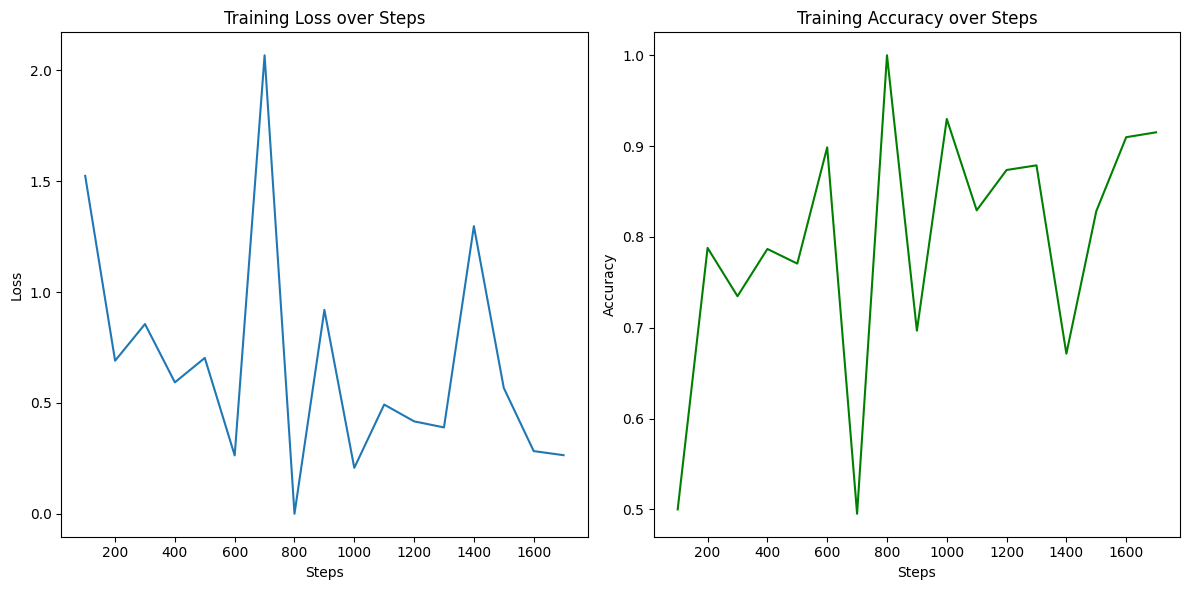

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-LHOdzUvlpeVevePAHKYjzs9D",
      "created_at": 1693064013,
      "level": "info",
      "message": "Step 1800/2100: training loss=0.42",
      "data": {
        "step": 1800,
        "train_loss": 0.4230378270149231,
        "train_mean_token_accuracy": 0.8188405632972717
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1800 | Loss: 0.4230378270149231 | Accuracy: 0.8188405632972717


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

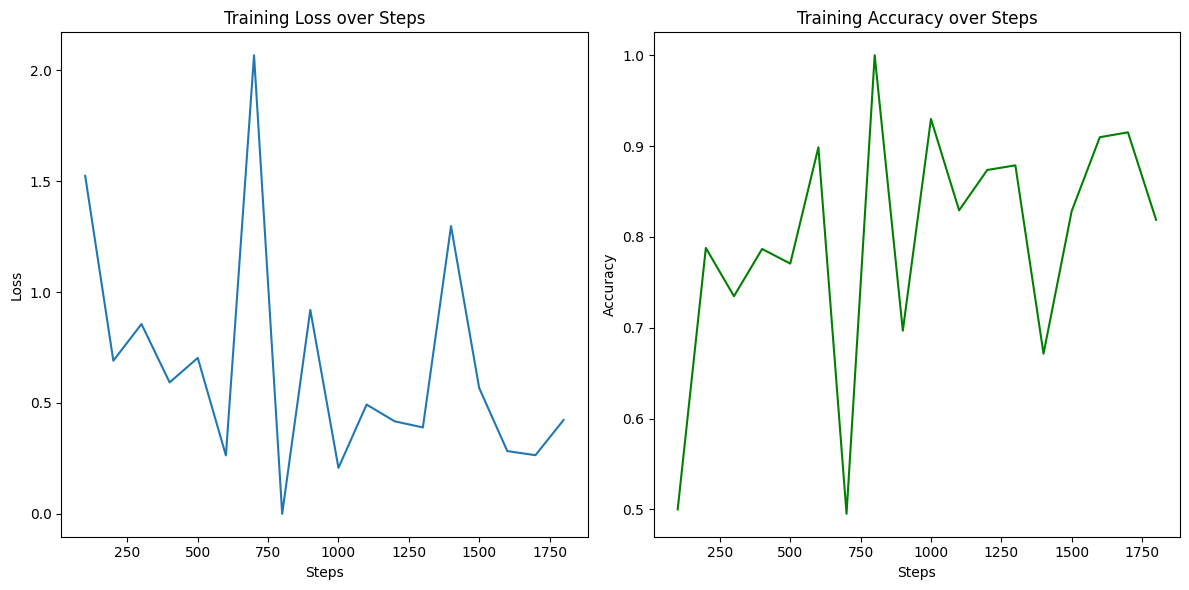

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-LHOdzUvlpeVevePAHKYjzs9D",
      "created_at": 1693064013,
      "level": "info",
      "message": "Step 1800/2100: training loss=0.42",
      "data": {
        "step": 1800,
        "train_loss": 0.4230378270149231,
        "train_mean_token_accuracy": 0.8188405632972717
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1800 | Loss: 0.4230378270149231 | Accuracy: 0.8188405632972717


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

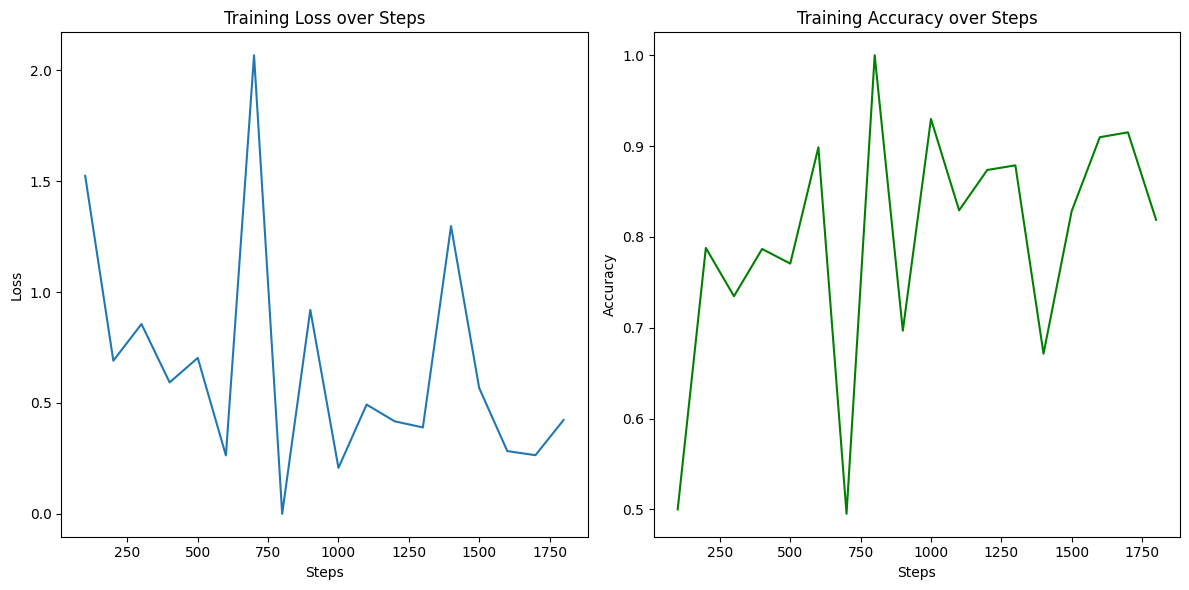

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-LHOdzUvlpeVevePAHKYjzs9D",
      "created_at": 1693064013,
      "level": "info",
      "message": "Step 1800/2100: training loss=0.42",
      "data": {
        "step": 1800,
        "train_loss": 0.4230378270149231,
        "train_mean_token_accuracy": 0.8188405632972717
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1800 | Loss: 0.4230378270149231 | Accuracy: 0.8188405632972717


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

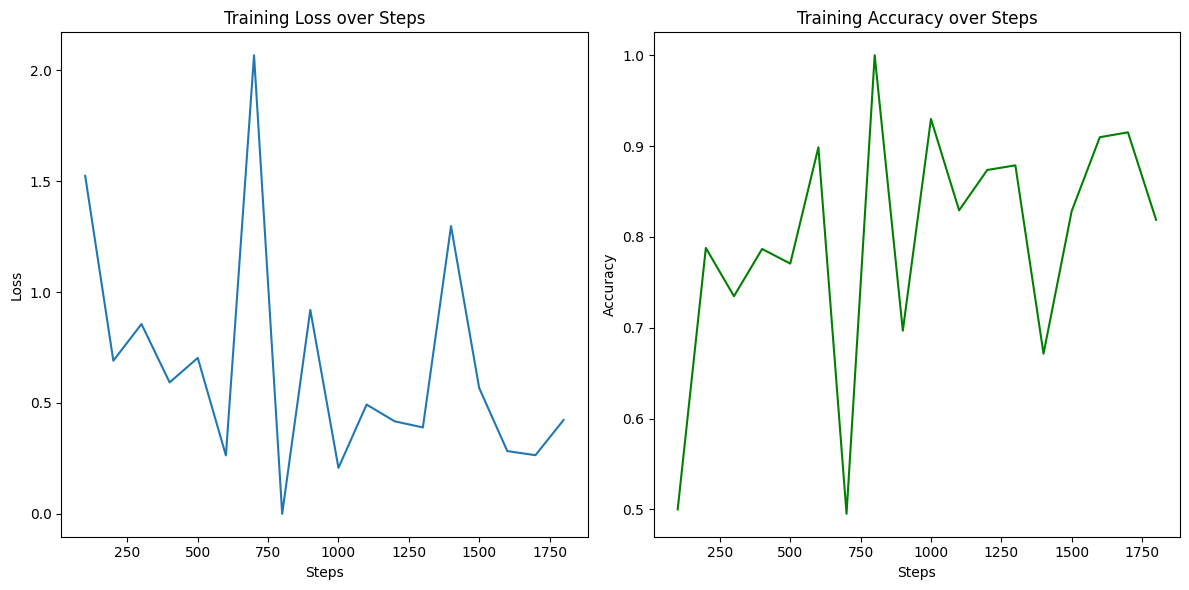

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-LHOdzUvlpeVevePAHKYjzs9D",
      "created_at": 1693064013,
      "level": "info",
      "message": "Step 1800/2100: training loss=0.42",
      "data": {
        "step": 1800,
        "train_loss": 0.4230378270149231,
        "train_mean_token_accuracy": 0.8188405632972717
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1800 | Loss: 0.4230378270149231 | Accuracy: 0.8188405632972717


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

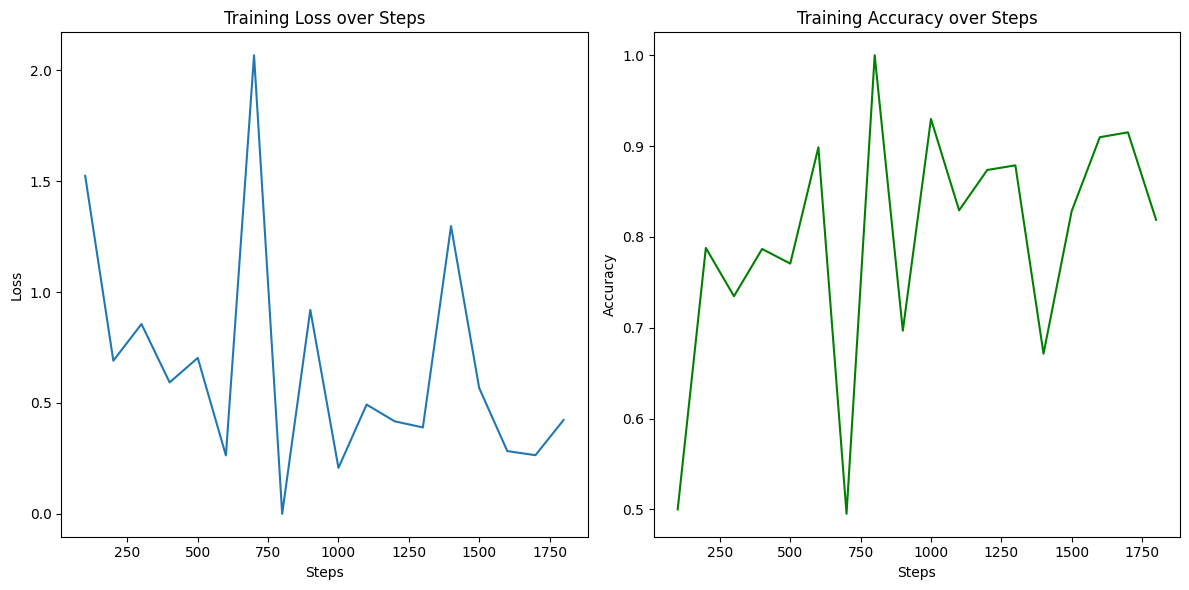

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-TTLwBu5Cw4xDJ6oELlrNWk00",
      "created_at": 1693064136,
      "level": "info",
      "message": "Step 1900/2100: training loss=0.40",
      "data": {
        "step": 1900,
        "train_loss": 0.40395388007164,
        "train_mean_token_accuracy": 0.8652482032775879
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1900 | Loss: 0.40395388007164 | Accuracy: 0.8652482032775879


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

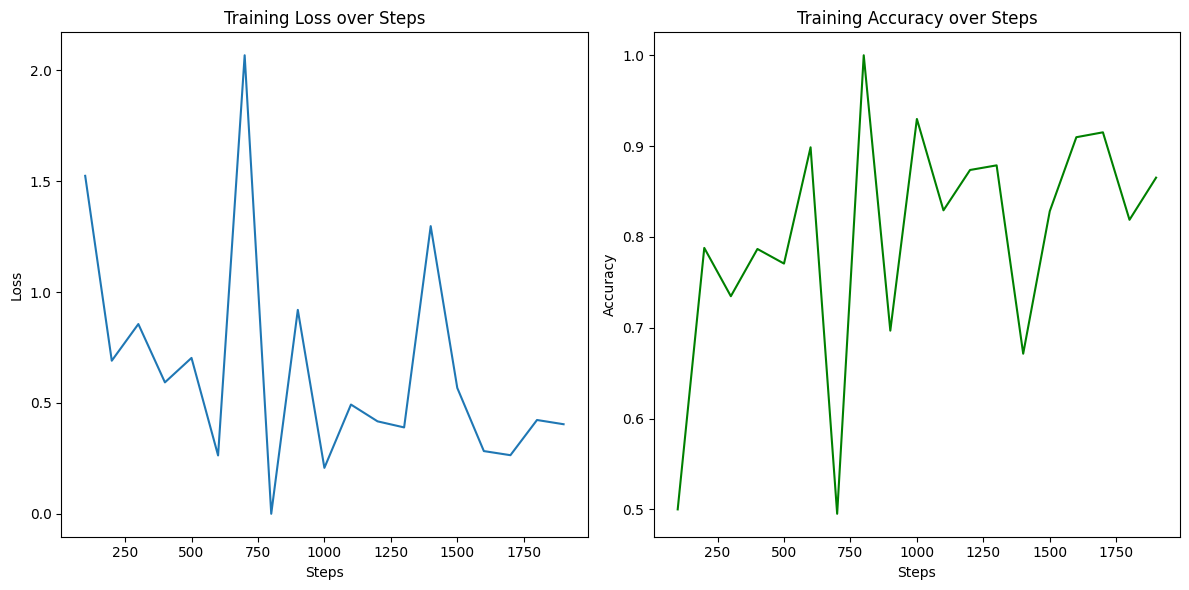

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-TTLwBu5Cw4xDJ6oELlrNWk00",
      "created_at": 1693064136,
      "level": "info",
      "message": "Step 1900/2100: training loss=0.40",
      "data": {
        "step": 1900,
        "train_loss": 0.40395388007164,
        "train_mean_token_accuracy": 0.8652482032775879
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1900 | Loss: 0.40395388007164 | Accuracy: 0.8652482032775879


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

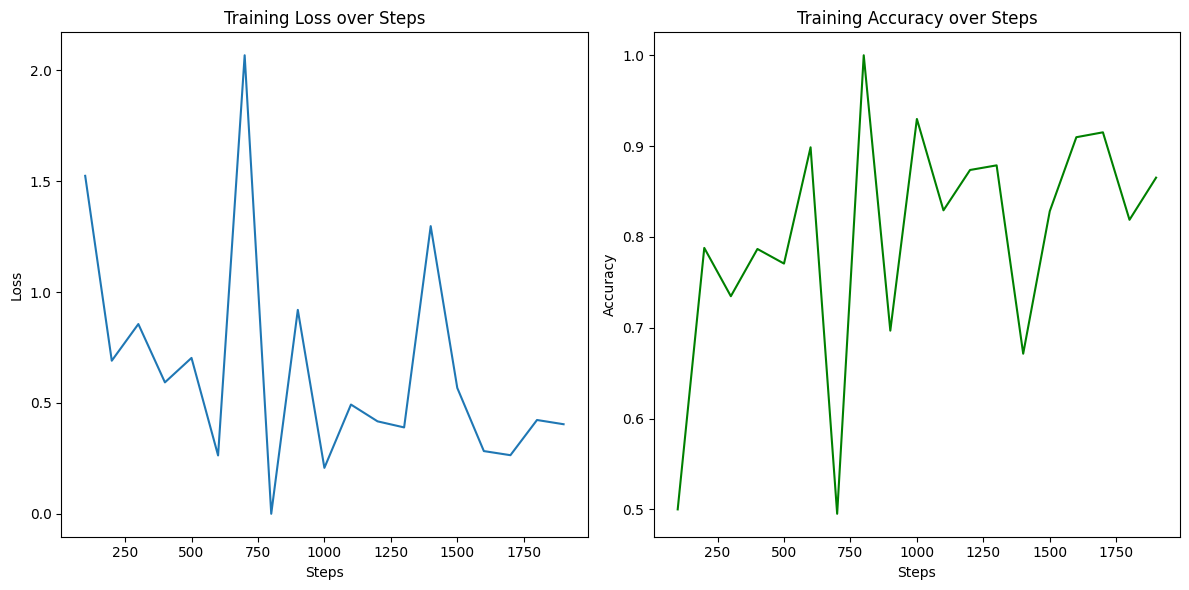

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-TTLwBu5Cw4xDJ6oELlrNWk00",
      "created_at": 1693064136,
      "level": "info",
      "message": "Step 1900/2100: training loss=0.40",
      "data": {
        "step": 1900,
        "train_loss": 0.40395388007164,
        "train_mean_token_accuracy": 0.8652482032775879
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1900 | Loss: 0.40395388007164 | Accuracy: 0.8652482032775879


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

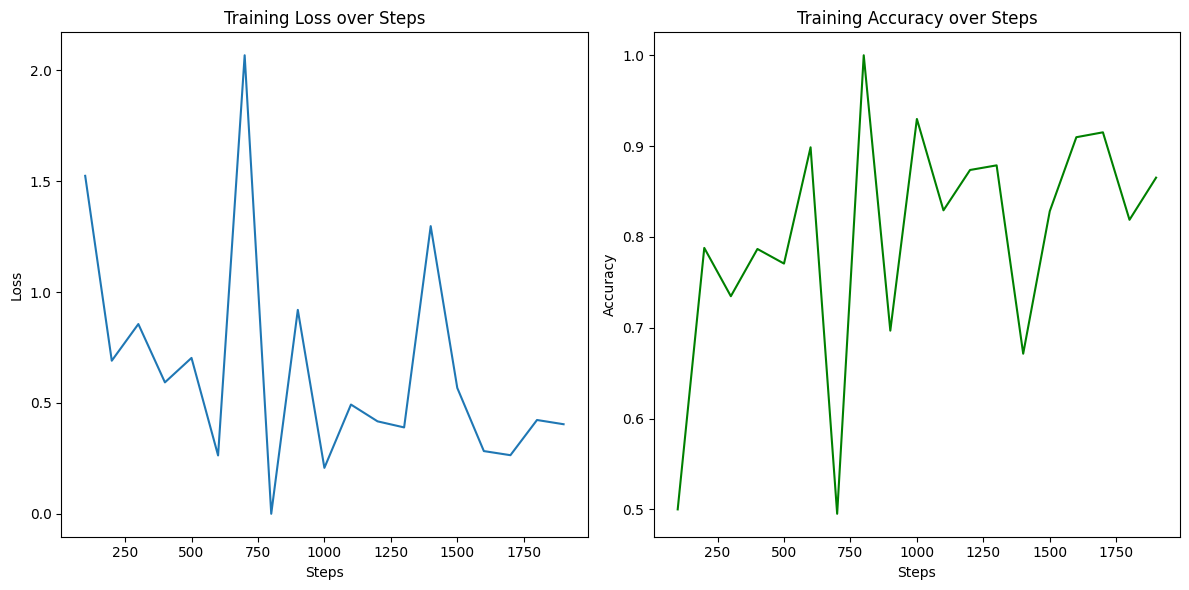

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-TTLwBu5Cw4xDJ6oELlrNWk00",
      "created_at": 1693064136,
      "level": "info",
      "message": "Step 1900/2100: training loss=0.40",
      "data": {
        "step": 1900,
        "train_loss": 0.40395388007164,
        "train_mean_token_accuracy": 0.8652482032775879
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 1900 | Loss: 0.40395388007164 | Accuracy: 0.8652482032775879


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

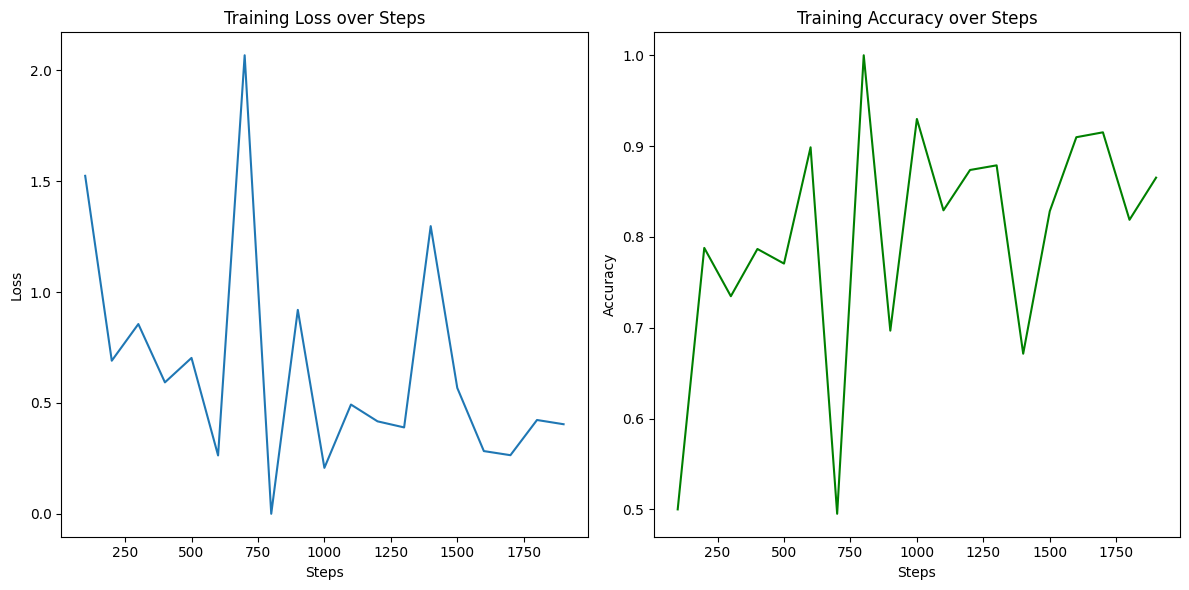

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-y8VkLsmI0HpD7muxNol97Deo",
      "created_at": 1693064257,
      "level": "info",
      "message": "Step 2000/2100: training loss=1.79",
      "data": {
        "step": 2000,
        "train_loss": 1.7884645462036133,
        "train_mean_token_accuracy": 0.5316455960273743
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 2000 | Loss: 1.7884645462036133 | Accuracy: 0.5316455960273743


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

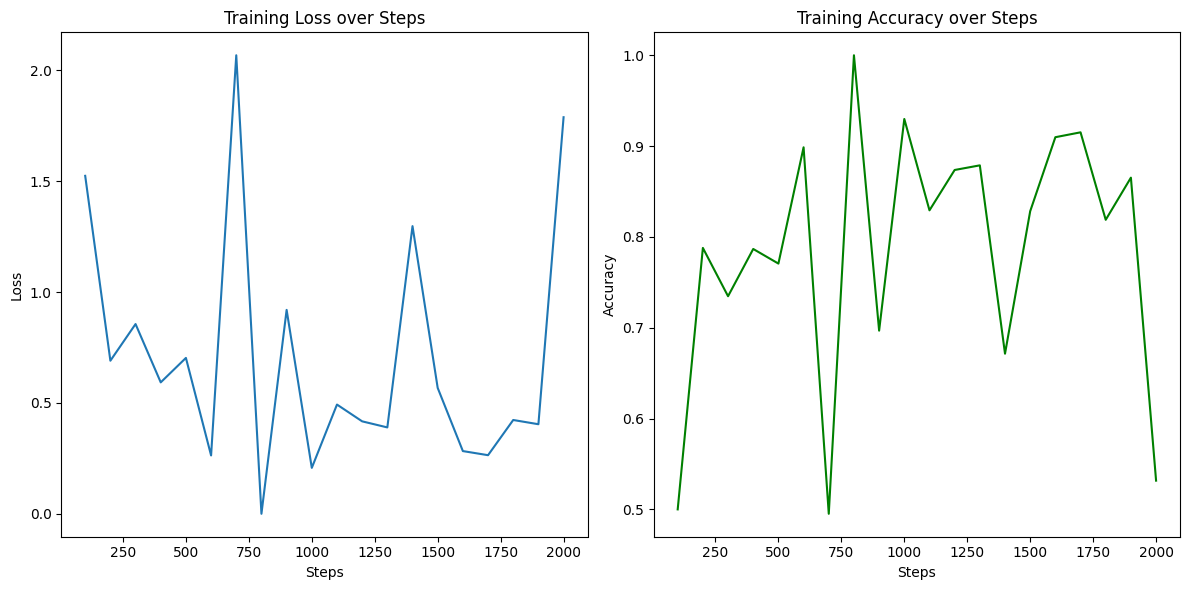

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-y8VkLsmI0HpD7muxNol97Deo",
      "created_at": 1693064257,
      "level": "info",
      "message": "Step 2000/2100: training loss=1.79",
      "data": {
        "step": 2000,
        "train_loss": 1.7884645462036133,
        "train_mean_token_accuracy": 0.5316455960273743
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 2000 | Loss: 1.7884645462036133 | Accuracy: 0.5316455960273743


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

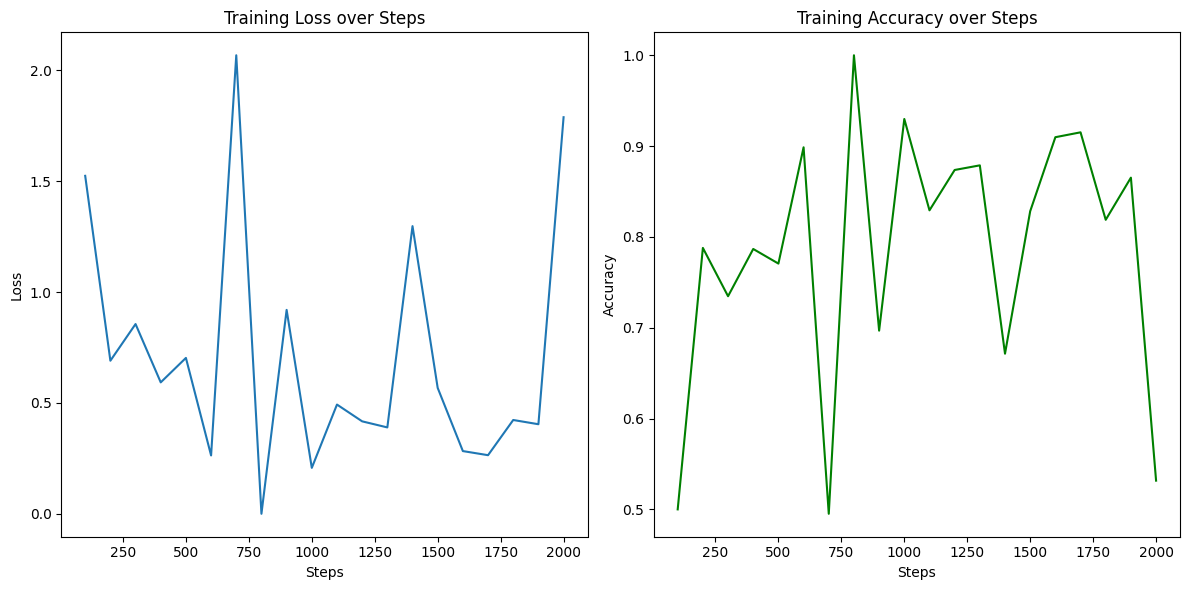

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-y8VkLsmI0HpD7muxNol97Deo",
      "created_at": 1693064257,
      "level": "info",
      "message": "Step 2000/2100: training loss=1.79",
      "data": {
        "step": 2000,
        "train_loss": 1.7884645462036133,
        "train_mean_token_accuracy": 0.5316455960273743
      },
      "type": "metrics"
    }
  ],
  "has_more": true
}
Step: 2000 | Loss: 1.7884645462036133 | Accuracy: 0.5316455960273743


<ipython-input-38-23dc1312aac5>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)


<Figure size 640x480 with 0 Axes>

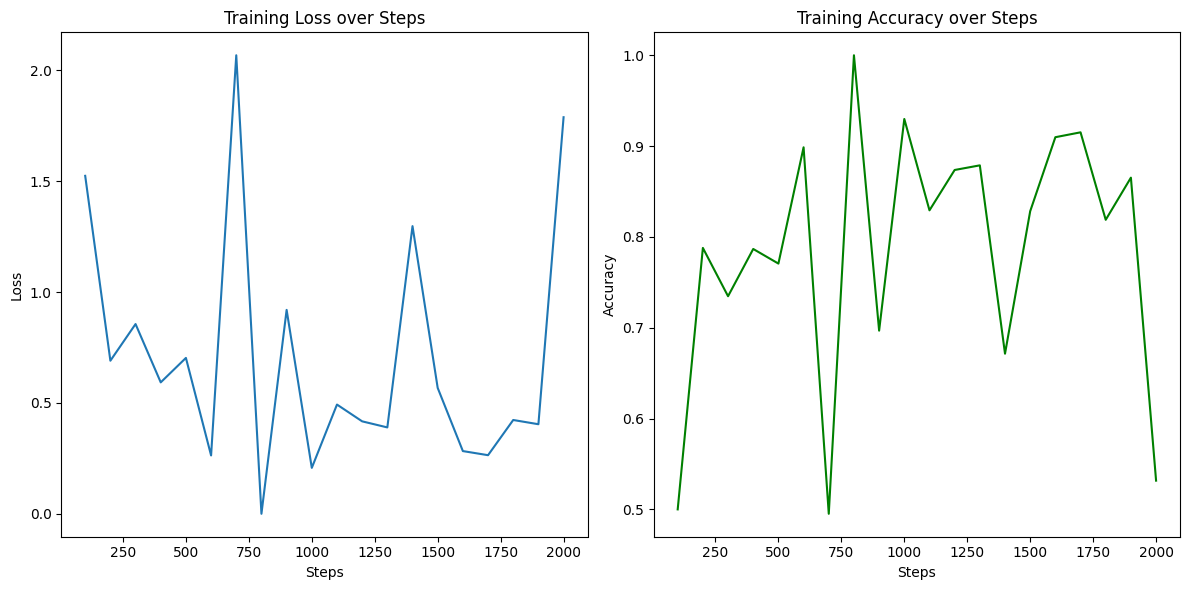

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-AYH5bajDxLwNu6Udhago1kq5",
      "created_at": 1693064383,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-id3G4U0WogYqGVMjuuZYFcmH",
      "created_at": 1693064385,
      "level": "info",
      "message": "Fine-tuning job successfully completed",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-id3G4U0WogYqGVMjuuZYFcmH",
      "created_at": 1693064385,
      "level": "info",
      "message": "Fine-tuning job successfully completed",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": true
}
{
  "objec

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [38]:
import time
import openai
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored

''' You can search all my videos and find the code download links to all projects at www.echohive.live '''

# Initialize an empty DataFrame
df = pd.DataFrame(columns=["Step", "Loss", "Accuracy"])

job_id = fine_tuning_job_ID

while True:
    # Retrieve the job
    job = openai.FineTuningJob.list_events(id=job_id, limit=1)
    print(job)
    if job.data[0]["data"]:

        step = job.data[0]["data"]["step"]
        train_loss = job.data[0]["data"]["train_loss"]
        accuracy = job.data[0]["data"]["train_mean_token_accuracy"]

        # Print the current step, loss, and accuracy in a single line with termcolor
        print(colored(f"Step: {step} | Loss: {train_loss} | Accuracy: {accuracy}", "green"))


        # Append data to the DataFrame
        df = df.append({"Step": step, "Loss": train_loss, "Accuracy": accuracy}, ignore_index=True)
        # save the DataFrame to a CSV file
        df.to_csv("training_progress.csv", index=False)

        # Plotting
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(df["Step"], df["Loss"], label="Train Loss")
        plt.title("Training Loss over Steps")
        plt.xlabel("Steps")
        plt.ylabel("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(df["Step"], df["Accuracy"], label="Train Accuracy", color="green")
        plt.title("Training Accuracy over Steps")
        plt.xlabel("Steps")
        plt.ylabel("Accuracy")

        plt.tight_layout()
        plt.draw()
        plt.pause(1)  # pause for a brief moment to allow the plot to update

        # Clear the current plot to prepare for the next update
        plt.clf()

    time.sleep(30)


In [55]:
openai.FineTuningJob.retrieve(fine_tuning_job_ID)

<FineTuningJob fine_tuning.job id=ftjob-DDgbZCd3Kzgfz1VbaxYO7rlI at 0x7aab241bdfd0> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-DDgbZCd3Kzgfz1VbaxYO7rlI",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693061533,
  "finished_at": 1693064385,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg",
  "organization_id": "org-h5B0ahlHzJHWTVOx8vC442tb",
  "result_files": [
    "file-PR7LfiQSNXPl9CPGxjQazgZC"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-qfEbp4Gh16nMQgb85ejS5dvY",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": 7666122
}

In [56]:
openai.FineTuningJob.retrieve(fine_tuning_job_ID)["fine_tuned_model"]


'ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg'

In [57]:
fine_tuned_model_ID = openai.FineTuningJob.retrieve(fine_tuning_job_ID)["fine_tuned_model"]
#
fine_tuned_model_ID

'ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg'

In [52]:
df

Step      Loss  Accuracy
0    100.0  1.524132  0.500000
1    100.0  1.524132  0.500000
2    100.0  1.524132  0.500000
3    100.0  1.524132  0.500000
4    200.0  0.690378  0.787879
..     ...       ...       ...
72  1900.0  0.403954  0.865248
73  1900.0  0.403954  0.865248
74  2000.0  1.788465  0.531646
75  2000.0  1.788465  0.531646
76  2000.0  1.788465  0.531646

[77 rows x 3 columns]

## Inferencing of the Fine Tuned Model

In [43]:
def answer_question(question, model_ID=fine_tuned_model_ID):

  message = [
              {
                  "role": "system",
                  "content": "You are the Yahoo platform user's assistant. Please reply users' answer using polite and respectful language.spectful language."
              },

              {
                  "role": "user",
                  "content": question
              }
            ]

  # Start inferencing
  model_completion = ChatCompletion.create(model=model_ID, messages=message)

  # Get the response
  response = model_completion.choices[0].message

  return response["content"]

In [44]:
import textwrap
wrapper = textwrap.TextWrapper(width=60)

In [46]:
ds_sample[900]['prompt']

'Summarize the following instructions: It can be difficult to edit your own writing. You’ve worked hard on it for weeks, months, or even years. When editing, you need to try to view your work objectively, as a reader would. So step away from the computer and give yourself a break from the manuscript. Focus on a different writing project or another activity and then return to the piece of writing with fresh eyes in several days.If you have waited until the last minute or were given a short deadline, you may not have time to do this. Getting a little distance and time from your work will help you read it more objectively and focus on what\'s actually on the page rather than what you think should be on the page.\nYou don\'t have to take day-long breaks. Even something as simple as moving to another task temporarily, going outside for a walk and a break, or calling a friend for a few minutes can help you "reset.";\n, While some writers find it easy to edit their work on a computer screen, 

In [47]:
question = ds_sample[900]['prompt']

## Response from the finetuned Model

In [48]:
response = answer_question(question, model_ID=fine_tuned_model_ID)

In [50]:
response

'To edit your own writing, take a break from the manuscript and try to view your work objectively. Edit in a different format, read aloud, consider your audience, focus on structure, check for accuracy, cut unnecessary content, reduce emphasis, proofread for specific errors, and get someone else to help.'

## Response from the base Turbo model

In [51]:
response_base = answer_question(question, model_ID="gpt-3.5-turbo")

In [53]:
response_base

'The instructions provide guidance on how to edit your own writing effectively. Here is a summary of the main points:\n\n1. Take a break from your writing to read it objectively later.\n2. Change the format of your writing to spot mistakes more easily.\n3. Read your work aloud to identify awkward phrasing.\n4. Put yourself in the shoes of your audience and make necessary changes.\n5. Edit the larger structure of your writing before focusing on individual sentences.\n6. Ensure your tone and voice match the form you are writing for.\n7. Be consistent with verb tense and point of view in your writing.\n8. Double-check facts and remove inaccurate statements.\n9. Make sentences clear and concise, avoiding unnecessary content.\n10. Evaluate and edit adverbs and adjectives for clarity and simplicity.\n11. Be confident and assertive in expressing your opinions.\n12. Proofread your work for grammar, spelling, and punctuation errors.\n13. Check for consistent capitalization and punctuation usage

## Evaluating Cost-Effectiveness

By fine-tuning, developers have reduced input prompts by up to 90%, resulting in faster API calls and potentially cutting costs. But, it’s essential to understand the financial implications. The cost breaks down into two primary buckets:

Training Cost: For every thousand tokens during the initial training, the charge is 0.8 cents.
Usage Cost: This divides further into input and output costs. The input cost for GPT-3.5 Turbo is 1.2 cents for every thousand tokens. More significantly, the output cost stands at 1.6 cents for the same token amount.
So, while fine-tuning may reduce prompt sizes, it does come at a steeper price. The trade-offs between customizability and cost need careful consideration.

## Evaluate the quality of the output

In [58]:
!pip install guardrail-ml==0.0.12
!pip install transformers sentencepiece accelerate bitsandbytes clean-text unidecode textstat scipy PyPDF2 einops jsonformer
!apt-get -qq install poppler-utils tesseract-ocr
%pip install -q --user --upgrade pillow
!pip install -q unstructured["local-inference"]==0.7.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.8 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=de9b70295577df769b946b56116fb883bd32369b29391538d669e75a3a6eaac0
  Store

In [59]:
from guardrail.client import run_metrics
from guardrail.client import run_simple_metrics
from guardrail.client import create_dataset
from guardrail.client import init_logs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Run Evaluation on Finetuned GPT-3.5-turbo

In [60]:
run_simple_metrics(output="To edit your own writing, take a break from the manuscript and try to view your work objectively. Edit in a different format, read aloud, consider your audience, focus on structure, check for accuracy, cut unnecessary content, reduce emphasis, proofread for specific errors, and get someone else to help.",
                   prompt= ds_sample[900]['prompt'],
                   model_uri="ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg")

{'automated_readability_index': '15.4',
 'dale_chall_readability_score': '10.01',
 'linsear_write_formula': '16.75',
 'gunning_fog': '16.33',
 'aggregate_reading_level': '17.0',
 'fernandez_huerta': '79.85',
 'szigriszt_pazos': '79.35',
 'gutierrez_polini': '38.13',
 'crawford': '3.9',
 'gulpease_index': '49.0',
 'osman': '47.62',
 'flesch_kincaid_grade': '14.0',
 'flesch_reading_ease': '38.15',
 'smog_index': '0.0',
 'coleman_liau_index': '12.02',
 'sentence_count': '2',
 'character_count': '256',
 'letter_count': '245',
 'polysyllable_count': '9',
 'monosyllable_count': '29',
 'difficult_words': '16',
 'syllable_count': '81',
 'lexicon_count': '49'}

In [66]:
run_metrics(output="To edit your own writing, take a break from the manuscript and try to view your work objectively. Edit in a different format, read aloud, consider your audience, focus on structure, check for accuracy, cut unnecessary content, reduce emphasis, proofread for specific errors, and get someone else to help.",
                   prompt= ds_sample[900]['prompt'],
                   model_uri="ft:gpt-3.5-turbo-0613:ai-planet::7rpfyXQg")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at d4data/bias-detection-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Token indices sequence length is longer than the specified maximum sequence length for this model (3081 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: ignored

In [61]:
import pandas as pd
import sqlite3

con = sqlite3.connect("logs.db")
df = pd.read_sql_query("SELECT * from logs", con)

In [62]:
df

timestamp  ... metric_value
0   2023-08-26 15:55:13  ...         15.4
1   2023-08-26 15:55:13  ...        10.01
2   2023-08-26 15:55:13  ...        16.75
3   2023-08-26 15:55:13  ...        16.33
4   2023-08-26 15:55:13  ...         17.0
5   2023-08-26 15:55:13  ...        79.85
6   2023-08-26 15:55:13  ...        79.35
7   2023-08-26 15:55:13  ...        38.13
8   2023-08-26 15:55:13  ...          3.9
9   2023-08-26 15:55:13  ...         49.0
10  2023-08-26 15:55:13  ...        47.62
11  2023-08-26 15:55:13  ...         14.0
12  2023-08-26 15:55:13  ...        38.15
13  2023-08-26 15:55:13  ...          0.0
14  2023-08-26 15:55:13  ...        12.02
15  2023-08-26 15:55:13  ...            2
16  2023-08-26 15:55:13  ...          256
17  2023-08-26 15:55:13  ...          245
18  2023-08-26 15:55:13  ...            9
19  2023-08-26 15:55:13  ...           29
20  2023-08-26 15:55:13  ...           16
21  2023-08-26 15:55:13  ...           81
22  2023-08-26 15:55:13  ...           49

[23 rows x 6 columns]

## Run the evaluation on the response from base GPT-3.5-turbo

In [63]:
run_simple_metrics(output="""The instructions provide guidance on how to edit your own writing effectively. Here is a summary of the main points:

1. Take a break from your writing to read it objectively later.
2. Change the format of your writing to spot mistakes more easily.
3. Read your work aloud to identify awkward phrasing.
4. Put yourself in the shoes of your audience and make necessary changes.
5. Edit the larger structure of your writing before focusing on individual sentences.
6. Ensure your tone and voice match the form you are writing for.
7. Be consistent with verb tense and point of view in your writing.
8. Double-check facts and remove inaccurate statements.
9. Make sentences clear and concise, avoiding unnecessary content.
10. Evaluate and edit adverbs and adjectives for clarity and simplicity.
11. Be confident and assertive in expressing your opinions.
12. Proofread your work for grammar, spelling, and punctuation errors.
13. Check for consistent capitalization and punctuation usage.
14. Beware of homophones and commonly confused words.
15. Avoid excessive emphasis through quotation marks, italics, or capital letters.
16. Read your writing backwards to catch spelling errors.
17. Seek feedback from others to gain a fresh perspective.

Remember to take your time, stay organized, and focus on one aspect at a time while editing your writing.""",
                   prompt= ds_sample[900]['prompt'],
                   model_uri="ft:gpt-3.5-turbo-0613")

{'automated_readability_index': '8.6',
 'dale_chall_readability_score': '10.53',
 'linsear_write_formula': '5.777777777777778',
 'gunning_fog': '9.51',
 'aggregate_reading_level': '11.0',
 'fernandez_huerta': '99.82',
 'szigriszt_pazos': '97.39',
 'gutierrez_polini': '42.7',
 'crawford': '2.5',
 'gulpease_index': '64.5',
 'osman': '59.3',
 'flesch_kincaid_grade': '7.5',
 'flesch_reading_ease': '60.51',
 'smog_index': '10.4',
 'coleman_liau_index': '10.65',
 'sentence_count': '20',
 'character_count': '1130',
 'letter_count': '1085',
 'polysyllable_count': '32',
 'monosyllable_count': '133',
 'difficult_words': '60',
 'syllable_count': '342',
 'lexicon_count': '216'}

In [64]:
con = sqlite3.connect("logs.db")
df = pd.read_sql_query("SELECT * from logs", con)

In [65]:
df

timestamp  ...       metric_value
0   2023-08-26 15:55:13  ...               15.4
1   2023-08-26 15:55:13  ...              10.01
2   2023-08-26 15:55:13  ...              16.75
3   2023-08-26 15:55:13  ...              16.33
4   2023-08-26 15:55:13  ...               17.0
5   2023-08-26 15:55:13  ...              79.85
6   2023-08-26 15:55:13  ...              79.35
7   2023-08-26 15:55:13  ...              38.13
8   2023-08-26 15:55:13  ...                3.9
9   2023-08-26 15:55:13  ...               49.0
10  2023-08-26 15:55:13  ...              47.62
11  2023-08-26 15:55:13  ...               14.0
12  2023-08-26 15:55:13  ...              38.15
13  2023-08-26 15:55:13  ...                0.0
14  2023-08-26 15:55:13  ...              12.02
15  2023-08-26 15:55:13  ...                  2
16  2023-08-26 15:55:13  ...                256
17  2023-08-26 15:55:13  ...                245
18  2023-08-26 15:55:13  ...                  9
19  2023-08-26 15:55:13  ...                 29
20  2023-08-26 15:55:13  ...                 16
21  2023-08-26 15:55:13  ...                 81
22  2023-08-26 15:55:13  ...                 49
23  2023-08-26 15:57:33  ...                8.6
24  2023-08-26 15:57:33  ...              10.53
25  2023-08-26 15:57:33  ...  5.777777777777778
26  2023-08-26 15:57:33  ...               9.51
27  2023-08-26 15:57:33  ...               11.0
28  2023-08-26 15:57:33  ...              99.82
29  2023-08-26 15:57:33  ...              97.39
30  2023-08-26 15:57:33  ...               42.7
31  2023-08-26 15:57:33  ...                2.5
32  2023-08-26 15:57:33  ...               64.5
33  2023-08-26 15:57:33  ...               59.3
34  2023-08-26 15:57:33  ...                7.5
35  2023-08-26 15:57:33  ...              60.51
36  2023-08-26 15:57:33  ...               10.4
37  2023-08-26 15:57:33  ...              10.65
38  2023-08-26 15:57:33  ...                 20
39  2023-08-26 15:57:33  ...               1130
40  2023-08-26 15:57:33  ...               1085
41  2023-08-26 15:57:33  ...                 32
42  2023-08-26 15:57:33  ...                133
43  2023-08-26 15:57:33  ...                 60
44  2023-08-26 15:57:33  ...                342
45  2023-08-26 15:57:33  ...                216

[46 rows x 6 columns]